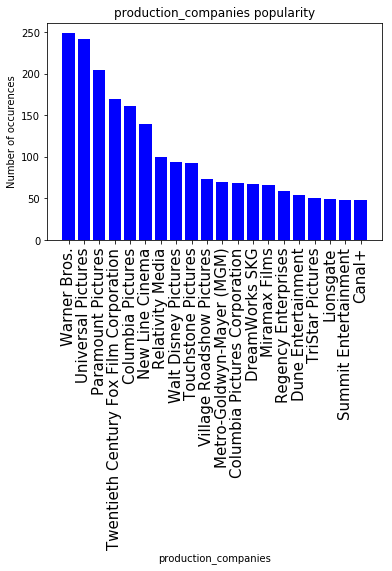

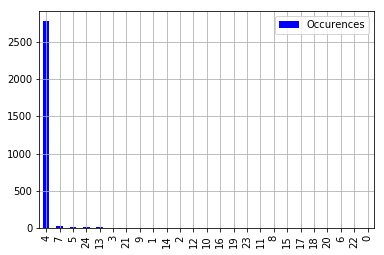

In [6]:
from utils import *
from models import *

In [7]:
# A reminder of our features
data.columns

Index(['budget', 'keywords', 'revenue', 'cast', 'crew', 'year', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Drama',
       'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime',
       'Science Fiction', 'Family', 'Fantasy', 'Horror', 'Mystery',
       'Animation', 'History', 'War', 'Music', 'Documentary', 'Western',
       'genres_others', 'grade', 'ratio', 'oscar_score',
       'United States of America', 'United Kingdom', 'Germany', 'France',
       'production_countries_others', 'language_de', 'language_en',
       'language_es', 'language_fr', 'language_others', 'language_zh',
       'short_time', 'medium_time', 'quite_long_time', 'long_time'],
      dtype='object')

<div class="alert alert-success">
Preparation of the regressions and the classifications
</div>


In [8]:
def get_data_from_db_by_gender(ds) :
    # We suppose that ds is already ordered by the year
    # It will return all the database split by genres
    
    db = ds.copy()
    i_first = np.where(db.columns == "Drama")[0][0]
    i_last = np.where(db.columns == 'genres_others')[0][0]   
    liste_genre = [ db.columns[i] for i in range(i_first, i_last + 1)]
    data_genres = []
    
    for i,name in enumerate(liste_genre) :
        current_db =  db[db[name] == 1]
        current_db = current_db.drop(liste_genre,1)
        data_genres.append(current_db)
    return data_genres,liste_genre    

def get_data_from_db_by_gender_n(ds,n) :
    # It will return all the n first databases split by genres
    data_genres,liste_genre = get_data_from_db_by_gender(ds)
    print(liste_genre[:n])
    return data_genres[:n],liste_genre[:n]
    

# Creation of our database for each genre
# We only use it now for the vizualisation
data_genres,liste_genre = get_data_from_db_by_gender(data)


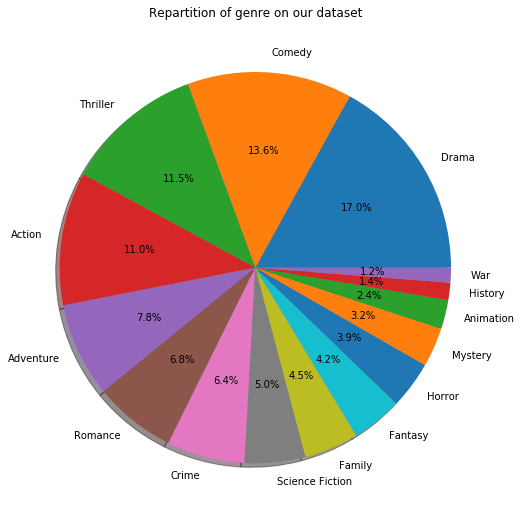

In [9]:
def plot_gender(data_genres,liste_genre) :
    # Plot the gender repartition through our dataset
    # We plot only the 15 first ones because otherwise we don't see everything in the plot
    sizes = []
    for x in data_genres[:15] :
        current_size = x.shape[0]
        sizes.append(current_size)
    fig = plt.figure(figsize=(9,9))
    plt.pie(sizes, labels=liste_genre[:15],autopct='%1.1f%%',shadow=True)
    plt.title("Repartition of genre on our dataset")
    plt.show()
    
# Vizualisation of the proportion of the genre
plot_gender(data_genres,liste_genre)

In [10]:
# Keywords : gets the average note of a given keyword
# Then : we make the average of each keyword for a given movie
# As we have a grade for each keyword, we will take the average for a given movie of all keywords



### Convert the column into dictionnary and get all the popularity_rate for each 
def get_popularity_by_name(ds,name) :
    # Return a list with the different json file in the column name and the count of it
    genres = []
    popularities = []
    for index,x in enumerate(ds[name]) :
        dictionnary = json.loads(x)
        current_grade = np.array(ds["grade"])[index]
        for y in dictionnary :
            if not (y.get("name") in genres) :
                genres.append(y.get("name"))
                partial_pop = [current_grade]
                popularities.append(partial_pop)
            else :
                popularities[genres.index(y.get("name"))].append(current_grade)
    
    average_pop = []
    for x in popularities :
        average_pop.append(np.mean(x))
    return genres,average_pop



def sort_two_lists(liste1,liste2) :
    # Sort the two lists with liste2 to be ordered
    indexes = np.argsort(liste2)
    liste_res_1 = np.flip(np.array(liste1)[indexes],axis=0)
    liste_res_2 = np.flip(np.array(liste2)[indexes],axis=0)
    return liste_res_1,liste_res_2


def plot_bar(x,y,x_name,y_name,title) :
    # Plots as a bar
    plt.xticks(rotation=90, fontsize = 15)
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.bar(x,y,  align = 'center', color='b')
    plt.title(title)
    plt.show()


def plot_popularity_keyword(N) :
    # Plot the N first keywords
    
    keyword,popularity = get_popularity_by_name(data,"keywords")
    keyword,popularity = sort_two_lists(keyword,popularity)
    keyword ,popularity = keyword[:N],popularity[:N]
    plot_bar(keyword,popularity,"Keywords","Popularity","Popularity of keywords")

    
def convert_keyword_grade(x,K,P) :
    # Applies P[index] with index indicating where is K in the instance x
    dictionnary = json.loads(x)
    liste_grade = []
    for y in dictionnary :
        index = np.where(K == y.get("name"))[0][0]
        liste_grade.append(P[index])
    return np.mean(liste_grade)
    
    
def process_by_grade(ds,name) :
    # Grades the given name by taking the average 
    X = ds.copy()
    keyword,popularity = get_popularity_by_name(X,name)
    keyword,popularity = sort_two_lists(keyword,popularity)
    new_name =  name+'_grade'
    X[new_name] = X[name]
    X[new_name]= X[new_name].apply(convert_keyword_grade, K = keyword, P = popularity)
    X = X.drop(name, axis=1)
    return X
    
    
def process_grade_genre(liste_genres) :
    # Returns two dataframe with the train and test
    # It adds the grade for the features keywords, cast and crew
    liste_to_process = ['keywords','cast','crew']
    liste_train, liste_test = [],[]
    for df in liste_genres : 
        train, test = train_test_split(df, test_size=0.2, shuffle = False)
        for x in liste_to_process :
            train = process_by_grade(train,x)
            test = process_by_grade(test,x)
        liste_train.append(train)
        liste_test.append(test)    
    return liste_train, liste_test




In [11]:
### We need to drop the instances where the keywords_grade is null
def drop_nan_grade(ds) :
    X = ds.copy()
    indexes = X.keywords_grade[X.keywords_grade.isnull()].index
    X = X.drop(indexes)
    X = X.reset_index(drop=True)
    return X

def get_clean_value(train, test) :
    # Return the train and dataset where we drawback the nan values for the grade
    new_train, new_test = [],[]
    for index, x in enumerate(train) :
        new_train.append(drop_nan_grade(x))
        new_test.append(drop_nan_grade(test[index]))
    return new_train,new_test


In [12]:
from sklearn.model_selection import train_test_split
def split_data(df,df1, label) :
    # Splits the inputs into training data and test data according to the label

    X_train = df.drop(label, 1).values
    y_train = df[label].values
    X_test = df1.drop(label, 1).values
    y_test = df1[label].values
    
    
    return X_train, X_test, y_train, y_test


In [13]:
# Class that will allow us to facilitate the use of parameters 
class SKlearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        #params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        # Trains the classifier
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        # Predicts the output given a dataset
        return self.clf.predict(x)
    
    def fit(self,x,y):
        # Fits the given data and the output
        return self.clf.fit(x,y)


Here we'll define the coefficient of determination, which we're going to call it the Score for a Regressor : 

$$ R^{2} = 1 - \frac{ \sum_{i} y_{i} - \hat y_{i} }{\sum_{i} y_{i} - \bar y_{i}}$$
where $y_{i}$ is the true output, $\hat y_{i}$ is the predicted one and $\bar y_{i}$ is the mean of the real output

In [14]:
# Validation step : we do this only to get the best parameters from our models
# Then, we'll keep the best classifier / regressor for testing it with the test set
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

# Number of folds for the validation step
NFOLDS = 5
# We use a time separation : our data is time-dependent
tscv = TimeSeriesSplit(n_splits=NFOLDS)

def get_oof(clf, x_train, y_train) :
    # Out of fold : returns the average score after doing TimeSeriesSplit
    # This is only made for regressors (we'll use another criteria for the classifiers)
    oof_score = np.zeros( (NFOLDS))
    for i,(train_index, test_index) in enumerate(tscv.split(x_train)) :
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        y_te = y_train[test_index]
        clf.fit(x_tr,y_tr)        
        oof_y_predict = clf.predict(x_te)
        # Coefficient of determination defined above 
        oof_score[i] = r2_score(y_te,oof_y_predict)        

    return np.mean(oof_score)

def get_score(model, x_train, y_train, x_test, y_test) :
    # Get the final score after getting the best parameters
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    return r2_score(y_test, y_pred)



In [15]:
# Compute the grade for keywords, crew and cast for all the data
# As we don't want to cheat, we can't compute the grade for all the data and make it in both the train and 
# the test. 
# We compute here the grade for each of these categories for all the data
# Then, we'll compute it for only the train set
# For the test set, it will have access to the all data. So we'll keep all the dataset to give the grade 


liste_all_grade = []
for x in ['keywords','cast','crew'] :
        liste_all_grade.append(process_by_grade(data,x))

In [16]:
# Class to get the split of our data depending on genre, removing some features, etc
# It will focus on the computation of the keyword_grade, cast_grade and crew_grade
from sklearn.model_selection import train_test_split
import copy


class Preprocess:
    def __init__(self, dataset) :
        # We initialize our preprocess with a dataset
        # It will have a train and test part after spliting the dataset into these two subsets
        self.ds = sort_by_column(dataset, ['year']) 
        self.data_genre = None
        self.train, self.test = [],[]
        
    def split_by_genre(self,n):
        # We return only the n first genre
        # It splits the data by genre
        self.data_genre , _ = get_data_from_db_by_gender_n(self.ds,n)
    
    def split_train_test(self) :
        # It will split the data into train and test sets
        # It has 20% of test and 80% of the data for the train
        if self.data_genre is None :
            train, test = train_test_split(self.ds, test_size=0.2)
            self.train, self.test = [train], [test]
        else :
            train_g, test_g = [],[]
            for df in self.data_genre :
                train, test = train_test_split(df, test_size=0.2)
                train_g.append(train)
                test_g.append(test)
            self.train, self.test = train_g, test_g

    def compute_grade(self,liste_all) :
        # Compute grade for the keywords, cast and crew for the train and the test
        # It will only compute the following grade from the train set to give a grade 
        # For the test set, it will keep all the dataset to give the grade
        liste_to_process = ['keywords','cast','crew']
        liste_train, liste_test = [],[]
        for index,data in enumerate(self.train) :
            for i,x in enumerate(liste_to_process) :            
                if i == 0 :
                    train = data.copy()
                    test = self.test[index].copy()
                train = process_by_grade(train,x)
                test[x+'_grade'] = liste_all[i][x+'_grade'][test.index]
                test.drop(x,axis=1, inplace = True)
            liste_train.append(train)
            liste_test.append(test)
        liste_train, liste_test = get_clean_value(liste_train, liste_test)
        self.train, self.test = liste_train, liste_test
        
        
        
        
            

In [17]:
# We get our work from our previous work for preprocessing the data
pre_process = Preprocess(data)
# We split it into train and test
pre_process.split_train_test()
# Then we compute the grade for the 3 categories keywords, crew and cast
pre_process.compute_grade(liste_all_grade)


In [229]:
# Prints the values of revenue in order to use it after for discretization
print(pre_process.ds.revenue.describe())

count    2.895000e+03
mean     1.289517e+08
std      1.923806e+08
min      5.000000e+00
25%      1.928311e+07
50%      6.127945e+07
75%      1.556332e+08
max      2.787965e+09
Name: revenue, dtype: float64


* Discretization functions

In [230]:

def discretize_grade_100(liste_ds) :
    # It will create 100 label for the grade
    # Multiplie by 10 and then take the int of the grade
    new_ds = []
    for df in liste_ds :
        new_df = df.copy()
        new_df.grade = df.grade * 10
        new_df.grade = new_df.grade.apply(lambda x : int(x))
        new_ds.append(new_df)
    return new_ds

def labelize(x) :
    # It will create labels between 1 and 19
    if x<1 :
        return 1
    elif x>=1 and x<1.5 :
        return 2
    elif x>=1.5 and x<2 :
        return 3
    elif x>=2 and x<2.5 :
        return 4
    elif x>=2.5 and x<3 :
        return 5
    elif x>=3 and x<3.5 :
        return 6
    elif x>=3.5 and x<4 :
        return 7
    elif x>=4 and x<4.5 :
        return 8
    elif x>=4.5 and x<5 :
        return 9
    elif x>=5  and x<5.5 :
        return 10
    elif x>=5.5 and x<6 :
        return 11
    elif x>=6 and x<6.5 :
        return 12
    elif x>=6.5 and x<7 :
        return 13
    elif x>=7 and x<7.5 :
        return 14
    elif x>=7.5 and x<8 :
        return 15
    elif x>=8 and x<8.5 :
        return 16
    elif x>=8.5 and x<9 :
        return 17
    elif x>=9 and x<9.5 :
        return 18
    elif x>=9.5 :
        return 19

def labelize_revenue(x): 
    # It splits the revenue into 3 categories : low revenue, middle revenue and high revenue
    # We took 25% and 75% of the revenue (as shown in the previous cell)
    if x <= 19283110 :
        return 1
    elif x> 19283110 and x<=155633200 :
        return 2
    else :
        return 3
    
    
def discretize_grade_20(liste_ds) :
    # Discretize the grade into 20 categories
    new_ds = []
    for df in liste_ds :
        new_df = df.copy()
        new_df.grade = new_df.grade.apply(labelize)
        new_ds.append(new_df)
    return new_ds


def discretize_revenue(liste_ds) :
    # Discretization of the revenue into 3 classes : low, medium and high
    new_ds = []
    for df in liste_ds :
        new_df = df.copy()
        new_df.revenue = new_df.revenue.apply(labelize_revenue)
        new_ds.append(new_df)
    return new_ds

    



In [231]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# Creation of an other class in order to print the features, change the label, delete some features, ...

class Dataset :
    # Initialization with a Preprocess object
    def __init__(self, pre_process) :
        self.pre_process = copy.deepcopy(pre_process)
        # Data where grade is the label
        self.grade_set = []
        # Data where ratio is the label
        self.ratio_set = []
        # Data where revenue is the label
        self.revenue_set = []
        self.scaler = StandardScaler() 
        
    def remove_feature(self,name_begin, name_end) :
        # It will remove features from name_begin until name_en
        for n,ds in enumerate(self.pre_process.train) :
            i_min = ds.columns.get_loc(name_begin) 
            i_max = ds.columns.get_loc(name_end)
            index = [i for i in range(i_min, i_max+1)]
            ds.drop(ds.columns[index], axis=1, inplace=True)
            self.pre_process.test[n].drop(ds.columns[index], axis=1, inplace=True)
            
    def print_features(self) :
        # Prints the features
        print(self.pre_process.train[0].columns)
    
    def set_sets(self):
        # It will split the data according to the 3 differents labels
        # It corresponds to self.grade_set, self.ratio_set and self.revenue_set
        for index,x in enumerate(self.pre_process.train) :
            # Returns X_train, X_test, y_train, y_test
            data_t_g , data_te_g = x.copy(), self.pre_process.test[index].copy()
            data_t_g.drop(['ratio', 'revenue'], axis = 1, inplace = True)
            data_te_g.drop(['ratio', 'revenue'], axis = 1, inplace = True)
            self.grade_set.append(split_data(data_t_g,data_te_g, 'grade'))
            data_t_r , data_te_r = x.copy(), self.pre_process.test[index].copy()
            data_t_r.drop(['grade', 'revenue'], axis = 1, inplace = True)
            data_te_r.drop(['grade', 'revenue'], axis = 1, inplace = True)
            self.ratio_set.append(split_data(data_t_r,data_te_r, 'ratio'))
            data_t_re , data_te_re = x.copy(), self.pre_process.test[index].copy()
            data_t_re.drop(['grade', 'ratio'], axis = 1, inplace = True)
            data_te_re.drop(['grade', 'ratio'], axis = 1, inplace = True)
            self.revenue_set.append(split_data(data_t_re,data_te_re, 'revenue'))     
        
    def discretize(self, n) :
    # It will discretize the grade.
    # If n == 0, it will create 100 labels otherwise 20 labels
        if n == 0 :
            for index, x in enumerate(self.pre_process.train) :
                x.grade = discretize_grade_100(self.pre_process.train)[0].grade
                self.pre_process.test[index].grade = discretize_grade_100(self.pre_process.test)[0].grade
        else :
            for index, x in enumerate(self.pre_process.train) :
                x.grade = discretize_grade_20(self.pre_process.train)[0].grade
                self.pre_process.test[index].grade = discretize_grade_20(self.pre_process.test)[0].grade
    def discretize_revenue(self) :
        for index, x in enumerate(self.pre_process.train) :
            x.revenue = discretize_revenue(self.pre_process.train)[0].revenue
            self.pre_process.test[index].revenue = discretize_revenue(self.pre_process.test)[0].revenue
            
            
    def inter_scalar(self, n) :
        # If n == 0, it will normalize
        # Else, it will denormalize
        liste_data = [self.grade_set ,self.ratio_set ,self.revenue_set] 
        new_liste = []
        for data in liste_data :
            new_data = []
            for x_train, x_test, y_train, y_test in data :
                if n == 0 :
                    self.scaler.fit(np.concatenate((x_train,x_test)))
                    new_data.append([self.scaler.transform(x_train),\
                                     self.scaler.transform(x_test), y_train,y_test])
                else :
                    new_data.append([self.scaler.inverse_transform(x_train),\
                                     self.scaler.inverse_transform(x_test), y_train,y_test])
            new_liste.append(new_data)
        self.grade_set = new_liste[0]
        self.ratio_set = new_liste[1]
        self.revenue_set = new_liste[2]
    
    def normalize(self ):
        # Normalization of the data 
        self.inter_scalar(0)
        
    def denormalize(self) :
        # Denormalization of the data
        self.inter_scalar(1)
        
        
    def get_grade_data(self,index) :
        # Returns the data where grade is the label
        return self.grade_set[index]
    
    def get_ratio_data(self, index) :
        # Returns the data where ratio is the label
        return self.ratio_set[index]
    
    def get_revenue_data(self, index) :
        # Returns the data where revenue is the label
        return self.revenue_set[index]
        
    def plot_correl_matrix(self,index) :
        # Plots the correlation matrix
        # Index will tell which of the train set it will print
        # Useful when there are a split by genre
        # If there are no split by genre, takes 0 will work 
        f, ax = plt.subplots(figsize=(9, 9))
        sns.heatmap(self.pre_process.train[index].corr(), vmax=1, square=True)
    def plot_par_correl_matrix(self, index) :
        # Does the same as the previous function but will only keep the label columns
        f, ax = plt.subplots(figsize=(25, 15))
        sns.heatmap(self.pre_process.train[index].corr()[['grade','revenue','ratio']], vmax=1, square=True)
                        

In [232]:
# Creation of the data 
dataset_all = Dataset(pre_process)
dataset_all.set_sets()
dataset_all.normalize()


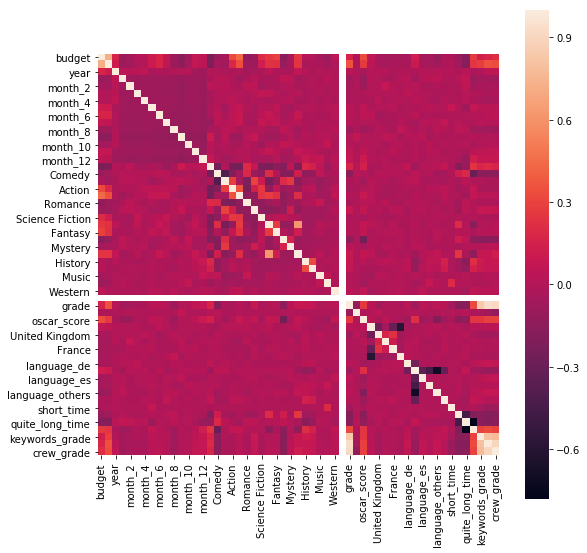

In [233]:
# Prints the correlation matrix
dataset_all.plot_correl_matrix(0)


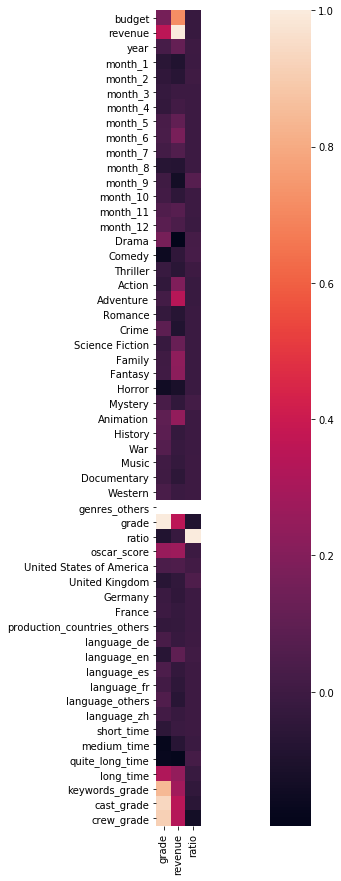

In [234]:
# Prints only the revelant columns
dataset_all.plot_par_correl_matrix(0)


In [235]:
# Prints the revelant features that we'll keep for the moment
dataset_all.print_features()


Index(['budget', 'revenue', 'year', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'Drama', 'Comedy', 'Thriller', 'Action',
       'Adventure', 'Romance', 'Crime', 'Science Fiction', 'Family', 'Fantasy',
       'Horror', 'Mystery', 'Animation', 'History', 'War', 'Music',
       'Documentary', 'Western', 'genres_others', 'grade', 'ratio',
       'oscar_score', 'United States of America', 'United Kingdom', 'Germany',
       'France', 'production_countries_others', 'language_de', 'language_en',
       'language_es', 'language_fr', 'language_others', 'language_zh',
       'short_time', 'medium_time', 'quite_long_time', 'long_time',
       'keywords_grade', 'cast_grade', 'crew_grade'],
      dtype='object')


In [236]:
# We split our dataset into training set and testing set
# We create it for each different label
# Here there's no split of genre

X_train_r, X_test_r , y_train_r , y_test_r = dataset_all.get_ratio_data(0)
X_train_re, X_test_re , y_train_re , y_test_re = dataset_all.get_revenue_data(0)
X_train_g, X_test_g , y_train_g , y_test_g = dataset_all.get_grade_data(0)

In [237]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor



# Class to do regression and to vizualise it easily
class Regressors :
    def __init__(self,X_train, y_train, X_test, y_test ) :
        # We'll mention in this class the regressior as an index to simplify
        # All the function will use "index" that corresponds to the respective regressor in this list
        self.regressors_name = ['Linear Regression', 'KNeighborsRegressor' ,\
                   'Stochastic Gradient Descent Regressor ' ,\
                   'Multi Layer Perceptron Regressor' ,\
                   'Descision Tree Regression',\
                  'Random Forest Regressor',\
                  'Support Vector Regressor ']
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # List with all the different parameters of the regressors
        self.list_param = [0 for i in range (len(self.regressors_name)) ]
        # List with all the score on the testing set
        self.list_score = np.zeros((1,len(self.regressors_name)))[0]
        # List with all the score on the training set after cross validation
        self.liste_oof_score = np.zeros((1,len(self.regressors_name)))[0]
        # List of all the regressors
        self.classifiers = [0 for i in range (len(self.regressors_name)) ]
        # List of all the functions that give the classifier with the good parameters
        # We need to take into account that, as we compute the best parameters through the training set,
        # it could lead to overfitting
        # We take the risk for when we'll deal with the genre 
        self.functions = [None for i in range(len(self.regressors_name))]
        
    def get_oof_score(self,index) :
        # Returns the score after cross validation on the training set
        clfr = SKlearnHelper(clf= self.classifiers[index], params = self.list_param[index]) 
        oof_score = get_oof(clfr, self.X_train,self.y_train)
        self.liste_oof_score[index] = oof_score
        return oof_score
    
    def get_score(self, index) :
        # Returns the real score on the testing set
        clfr = SKlearnHelper(clf= self.classifiers[index], params = self.list_param[index]) 
        score = get_score(clfr,self.X_train,self.y_train,self.X_test,self.y_test) 
        self.list_score[index] = score
        return score
    
    def set_classifier(self, index, clf) :
        # Sets the classifier
        self.classifiers[index] = clf
    
    def set_param(self, index, param) :
        # Sets the parameter at a specific classifier
        
        self.list_param[index] = param
        if (self.classifiers[index] is not None ):
            self.get_oof_score(index)
            self.get_score(index)
    
    def print_classifier_scores(self, index) :
        # Prints both the score after cross validation on the training set and the score on the testing set
        if (self.list_score[index] == 0 or self.liste_oof_score[index] == 0) :
            self.get_oof_score(index)
            self.get_score(index)    
        print("Score cross validation with " + self.regressors_name[index], self.liste_oof_score[index])
        print("Score for generalization with "+ self.regressors_name[index], self.list_score[index])
        
    def set_function(self, index, func) :
        # Sets the function that will return a regressor with good parameters
        self.functions[index] = func
    
    def function(self,index) :
        # It will create the regressor with the good parameters according to some criteria 
        if self.functions[index] is not None :
            param,clf = self.functions[index](self.X_train, self.y_train, True)
            self.set_param(index,param)
            self.set_classifier(index, clf)
            print("Parameters : ",param)
            
    def set_regressors(self, liste_regressor) :
        # Sets all the regressors
        for index, x in enumerate(liste_regressor) :
            self.set_classifier(index, x)
        
    def set_functions(self,liste_function):
        # Sets all the function of the regressors
        for index, x in enumerate(liste_function) :
            self.set_function(index, x)
    
    def print_best_regressor(self) :
        # It will prints the best regressors (for the training set) and returns its score with the testing set
        index = np.argmax(self.liste_oof_score)
        answer = "Best regressor : " + str(self.regressors_name[index]) +\
        " for a score : " + str(self.list_score[index])
        return answer
    
    
    def print_all_score(self) :
        # Prints all the score on the testing set for all the regressors
        print("Score for the different regressors ")
        score_regressors = {}
        score_regressors['Score'] = self.list_score
        score_class_df = pd.DataFrame(score_regressors, index =self.regressors_name)        
        print(score_class_df)        
        sns.set_color_codes("muted")
        score_class_df['Regressors'] = self.regressors_name
        sns.barplot(x='Score', y='Regressors', data=score_class_df, color="b")
        plt.xlabel('Score')
        plt.title('Regression Score')
        plt.show()

    def plot_prediction(self,name) :
        # It takes the model that maximizes the scores
        # Then, it will plot a graph with the real values and the predicted ones 
        # On the x axis, it will be the ith instance
        index = np.argmax(self.liste_oof_score)
        clf = self.classifiers[index]
        print("Regressor chosen :",self.regressors_name[index])
        params = self.list_param[index]
        classifier = SKlearnHelper(clf=clf, params = params)
        classifier.fit(self.X_train, self.y_train)
        y_predict = classifier.predict(self.X_test)
        f, ax = plt.subplots(figsize=(8, 8))
        plt.scatter([i for i in range(len(y_predict))] ,y_predict, color='b', label="Prediction",\
                   marker='+')
        plt.scatter([i for i in range(len(y_predict))],self.y_test,color='r',label="Real Value",\
                    marker='+')
        plt.xlabel("Number of instance")
        plt.ylabel(name)
        plt.title("Comparaison of the model with the real values")
        plt.legend()
        plt.show()


        
       
        
            
        
        
            

<div class="alert alert-success">
Use of ratio as label for regression
</div>


In [238]:
# Creation of our Regressor class
regressors = Regressors(X_train_r, y_train_r, X_test_r, y_test_r,)

In [239]:
# List of all the regressors that we're going to use
liste_regressor =  [LinearRegression,KNeighborsRegressor,SGDRegressor,MLPRegressor,DecisionTreeRegressor,\
                   RandomForestRegressor,SVR]
# List of all the functions that return the best regressor 
liste_function = [0,get_knn, get_sgdr, get_mlpr,get_dtr, get_rfr, 0 ]

In [240]:
# We set the previous information
regressors.set_regressors(liste_regressor)
regressors.set_functions(liste_function)

* Linear Regression

In [241]:
param_lr = {
    'normalize':False
}
regressors.set_param(0, param_lr)
# Prints the score for cross validation and for generalization
regressors.print_classifier_scores(0)

Score cross validation with Linear Regression -8.45829995662e+23
Score for generalization with Linear Regression -0.0100703413301


* KNeighborsRegressor

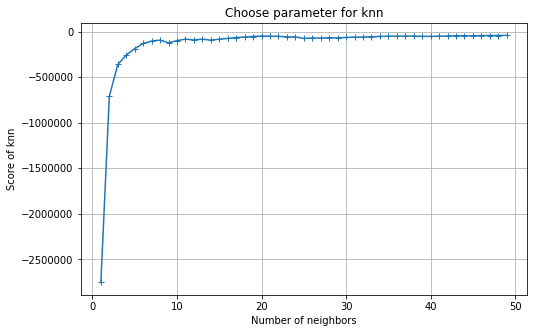

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}


In [242]:
# Fits the best parameters for the model
regressors.function(1)


In [243]:
# We choose the best parameters in order not to overfit
param_knn = {
    'algorithm':'auto',
    'n_neighbors':50
}
regressors.set_param(1, param_knn)
regressors.print_classifier_scores(1)

Score cross validation with KNeighborsRegressor -40291.1160606
Score for generalization with KNeighborsRegressor -0.00303972143086


* Stochastic Gradient Descent Regressor 

In [244]:
# Fits the best parameters for the model
regressors.function(2)



Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -40209.871407 -40220.544376 -40207.988538
huber                           -0.010406     -0.010417     -0.010404
epsilon_insensitive             -0.008899     -0.008795     -0.008738
squared_epsilon_insensitive -49365.494350 -49370.749960 -49364.567031
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l2', 'max_iter': 1000}


In [245]:
# Prints the results
regressors.print_classifier_scores(2)

Score cross validation with Stochastic Gradient Descent Regressor  -0.0087383759145
Score for generalization with Stochastic Gradient Descent Regressor  -0.00177625907952


* Multi Layer Perceptron Regressor

In [246]:
# Fits the best parameters for the model
regressors.function(3)


Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-1745275.5196023029, -2495936.4503547144, -140.36752975813005]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'constant', 'random_state': 1, 'hidden_layer_sizes': (50, 1)}


In [247]:
# Prints the results
regressors.print_classifier_scores(3)

Score cross validation with Multi Layer Perceptron Regressor -140.367529758
Score for generalization with Multi Layer Perceptron Regressor -0.00154913660731


* Descision Tree Regression 

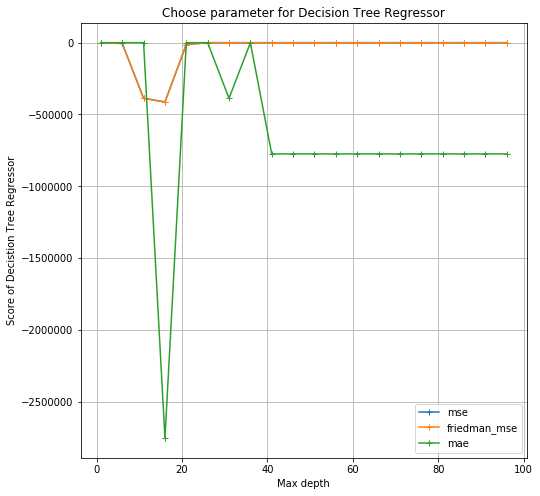

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}


In [248]:
# Fits the best parameters for the model
regressors.function(4)  

In [249]:
# Prints the results
regressors.print_classifier_scores(4)

Score cross validation with Descision Tree Regression -0.0126427795748
Score for generalization with Descision Tree Regression -0.00177610683246


* RandomForestRegressor

Max depth : 3
Number of estimators : 1


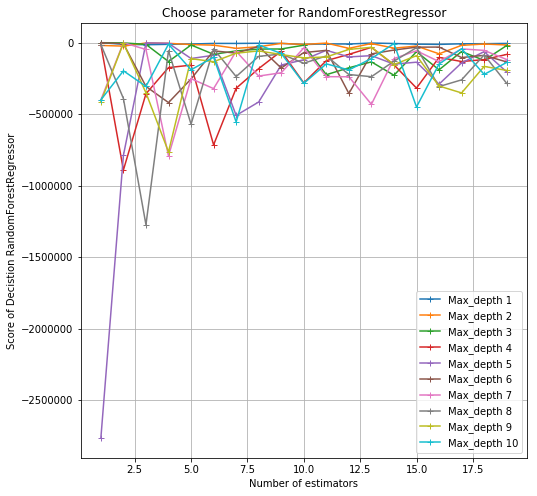

Parameters :  {'max_features': 'auto', 'max_depth': 3, 'n_estimators': 1}


In [250]:
# Fits the best parameters for the model
regressors.function(5)

In [251]:
param_rfr = {
    'n_estimators': 7, 'max_features': 'auto', 'random_state': 1, 'max_depth': 1
}
regressors.set_param(5, param_rfr)

In [252]:
# Prints the results
regressors.print_classifier_scores(5)

Score cross validation with Random Forest Regressor -3081.76661901
Score for generalization with Random Forest Regressor -0.159755604903


* Support Vector Regression

In [253]:
# Use of a linear SVR 
param_svr = {
    'kernel':'linear'
}
regressors.set_param(6,param_svr)



In [254]:
# Prints the results
regressors.print_classifier_scores(6)

Score cross validation with Support Vector Regressor  -0.00844772148451
Score for generalization with Support Vector Regressor  -0.00177625329057


Score for the different regressors 
                                           Score
Linear Regression                      -0.010070
KNeighborsRegressor                    -0.003040
Stochastic Gradient Descent Regressor  -0.001776
Multi Layer Perceptron Regressor       -0.001549
Descision Tree Regression              -0.001776
Random Forest Regressor                -0.159756
Support Vector Regressor               -0.001776


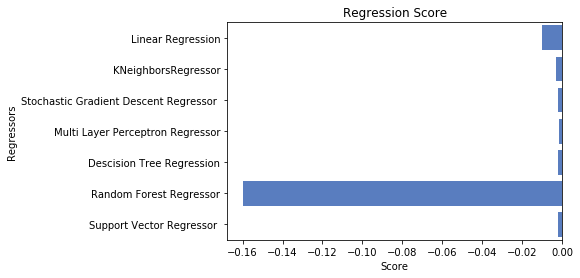

In [255]:
# Prints all the results together
regressors.print_all_score()

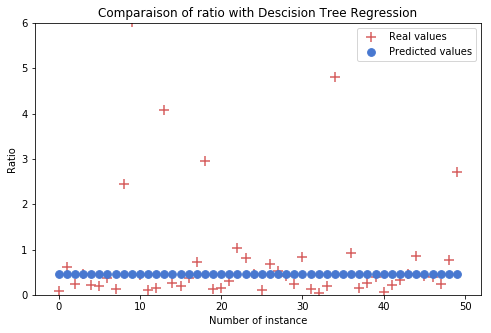

In [256]:
plot_predict_real(regressors, 50, "Ratio", "Descision Tree Regression", [0,6],4)

<div class="alert alert-success">
Use of revenue as label for regression
</div>


In [257]:
# Creates a Regressor instance to to regression with the revenue
regressor_revenue = Regressors(X_train_re, y_train_re, X_test_re, y_test_re,)

In [258]:
# Set the regressors and the functions that compute the best parameters for each regressor
regressor_revenue.set_regressors(liste_regressor)
regressor_revenue.set_functions(liste_function)

* Linear Regression


In [259]:

param_lr = {
    'normalize':False
}
regressor_revenue.set_param(0, param_lr)
regressor_revenue.print_classifier_scores(0)


Score cross validation with Linear Regression -4.77715073133e+25
Score for generalization with Linear Regression 0.526892845757


* KNeighborsRegressor


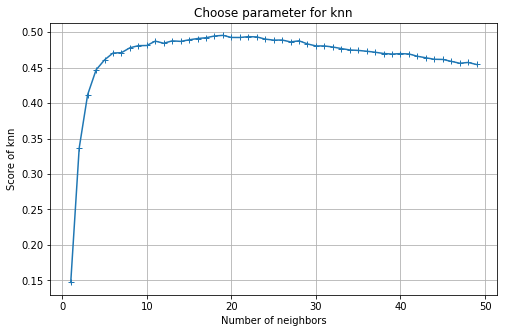

Parameters :  {'n_neighbors': 19, 'algorithm': 'auto'}


In [260]:
# Computes the best k parameter
regressor_revenue.function(1)


In [261]:
# We choose the best parameters in order to not overfit

regressor_revenue.set_param(1, param_knn)
regressor_revenue.print_classifier_scores(1)


Score cross validation with KNeighborsRegressor 0.454219504229
Score for generalization with KNeighborsRegressor 0.458515213504


* Stochastic Gradient Descent Regressor 


In [262]:
# Computes the best loss and penalty functions
regressor_revenue.function(2)

Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.538574  0.538437  0.538597
huber                         -0.517934 -0.517934 -0.517934
epsilon_insensitive           -0.517930 -0.517930 -0.517930
squared_epsilon_insensitive    0.540127  0.540009  0.540147
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'max_iter': 1000}


In [263]:
regressor_revenue.print_classifier_scores(2)


Score cross validation with Stochastic Gradient Descent Regressor  0.540146562095
Score for generalization with Stochastic Gradient Descent Regressor  -2559.15950527


* Multi Layer Perceptron Regressor


In [264]:
# Computes the best solver
regressor_revenue.function(3)


Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.082891580023714467, -106645314233.09097, -0.51785932932360246]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 'constant', 'random_state': 1, 'hidden_layer_sizes': (50, 1)}


In [265]:
regressor_revenue.print_classifier_scores(3)

Score cross validation with Multi Layer Perceptron Regressor 0.0828915800237
Score for generalization with Multi Layer Perceptron Regressor 0.26852502998



* Descision Tree Regression 


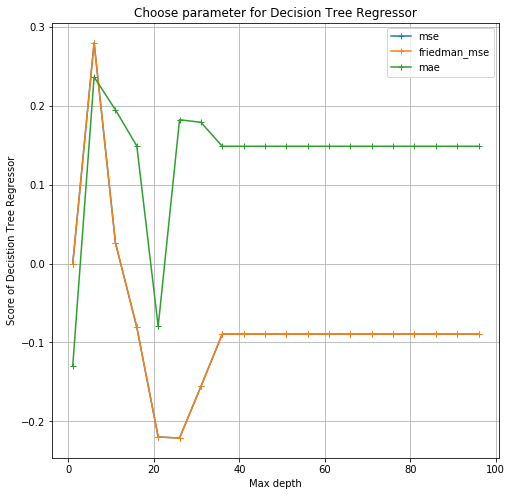

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 6, 'random_state': 1}


In [266]:
# Computes the best number of max depth
regressor_revenue.function(4)
        


In [267]:
regressor_revenue.print_classifier_scores(4)

Score cross validation with Descision Tree Regression 0.280165008026
Score for generalization with Descision Tree Regression 0.216131445376



* RandomForestRegressor

Max depth : 6
Number of estimators : 19


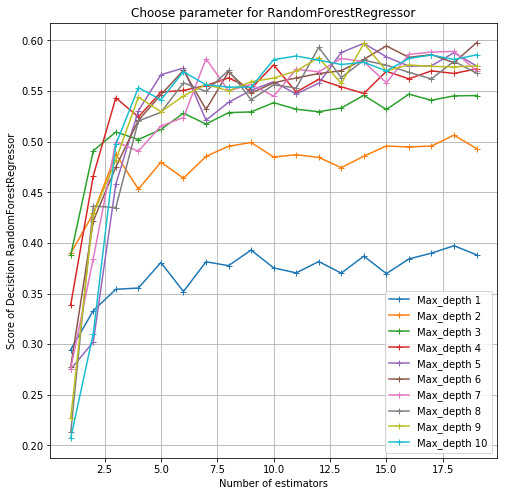

Parameters :  {'max_features': 'auto', 'max_depth': 6, 'n_estimators': 19}


In [268]:
# Computes the best number of max depth and the number of estimators
regressor_revenue.function(5)


In [269]:
param_rfr_re = {
    'max_depth':6,
    'random_state':1,
    'max_features':'auto',
    'n_estimators':10
    
}
regressor_revenue.set_param(5,param_rfr_re)

In [270]:

regressor_revenue.print_classifier_scores(5)


Score cross validation with Random Forest Regressor 0.565888954557
Score for generalization with Random Forest Regressor 0.600986604533


* Support Vector Regression


In [271]:

param_svr = {
    'kernel':'linear'
}
regressor_revenue.set_param(6,param_svr)
regressor_revenue.print_classifier_scores(6)


Score cross validation with Support Vector Regressor  -0.13775413151
Score for generalization with Support Vector Regressor  -0.108389831486


Score for the different regressors 
                                              Score
Linear Regression                          0.526893
KNeighborsRegressor                        0.458515
Stochastic Gradient Descent Regressor  -2559.159505
Multi Layer Perceptron Regressor           0.268525
Descision Tree Regression                  0.216131
Random Forest Regressor                    0.600987
Support Vector Regressor                  -0.108390


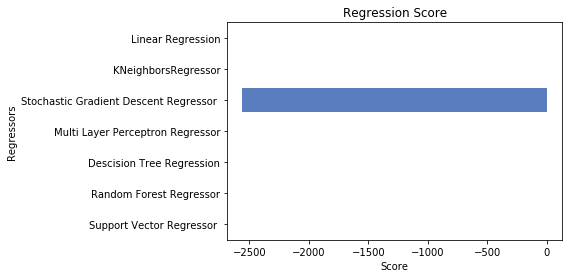

In [272]:
regressor_revenue.print_all_score()

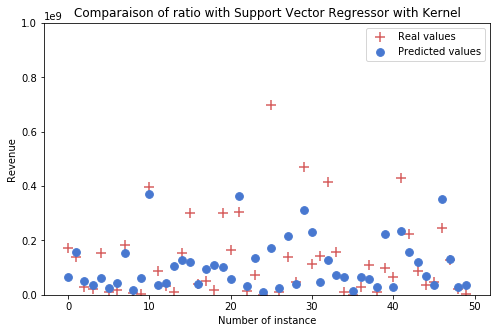

In [273]:
# Plots the predicted versus the real values for the 50 first ones


plot_predict_real(regressor_revenue, 50, "Revenue","Support Vector Regressor with Kernel",\
                  [0,10**9],5)




<div class="alert alert-success">
Use of grade as label for regression
</div>


In [274]:
# Initialization
regressor_grade = Regressors(X_train_g, y_train_g, X_test_g, y_test_g)

In [275]:
# Makes the function and the parameters initialisation
regressor_grade.set_regressors(liste_regressor)
regressor_grade.set_functions(liste_function)

* Linear Regression


In [276]:

param_lr = {
    'normalize':False
}
regressor_grade.set_param(0, param_lr)
regressor_grade.print_classifier_scores(0)


Score cross validation with Linear Regression -1.02272904037e+25
Score for generalization with Linear Regression 0.911235313728



* KNeighborsRegressor

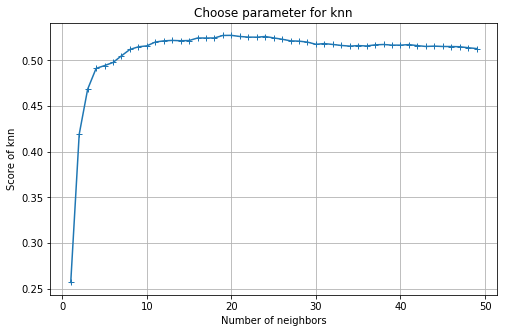

Parameters :  {'n_neighbors': 20, 'algorithm': 'auto'}


In [277]:

regressor_grade.function(1)


In [278]:

regressor_grade.print_classifier_scores(1)


Score cross validation with KNeighborsRegressor 0.527403461965
Score for generalization with KNeighborsRegressor 0.549936213395


* Stochastic Gradient Descent Regressor 



In [279]:

regressor_grade.function(2)



Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.879530  0.880244  0.879396
huber                          0.353900  0.366820  0.344105
epsilon_insensitive            0.878803  0.881239  0.877719
squared_epsilon_insensitive    0.877076  0.877862  0.876931
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}


In [280]:
regressor_grade.print_classifier_scores(2)



Score cross validation with Stochastic Gradient Descent Regressor  0.881239085808
Score for generalization with Stochastic Gradient Descent Regressor  0.906604840144



* Multi Layer Perceptron Regressor


In [281]:
regressor_grade.function(3)



Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.78610293639019246, 0.6126280576765526, 0.57677093992633277]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 'constant', 'random_state': 1, 'hidden_layer_sizes': (50, 1)}


In [282]:


regressor_grade.print_classifier_scores(3)


Score cross validation with Multi Layer Perceptron Regressor 0.78610293639
Score for generalization with Multi Layer Perceptron Regressor 0.888749508918




* Descision Tree Regression 


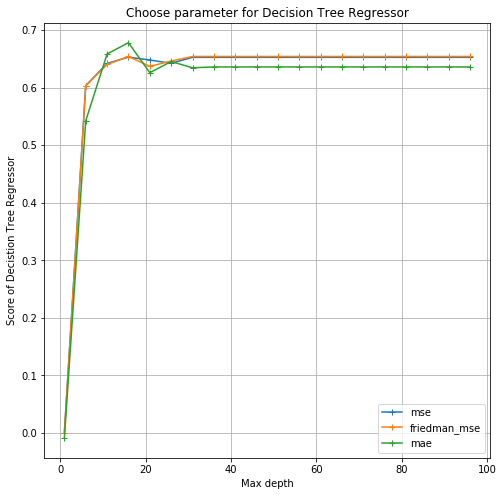

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 16, 'random_state': 1}


In [283]:
regressor_grade.function(4)
        


In [284]:
regressor_grade.print_classifier_scores(4)


Score cross validation with Descision Tree Regression 0.677962002064
Score for generalization with Descision Tree Regression 0.642991181394



* RandomForestRegressor


Max depth : 10
Number of estimators : 19


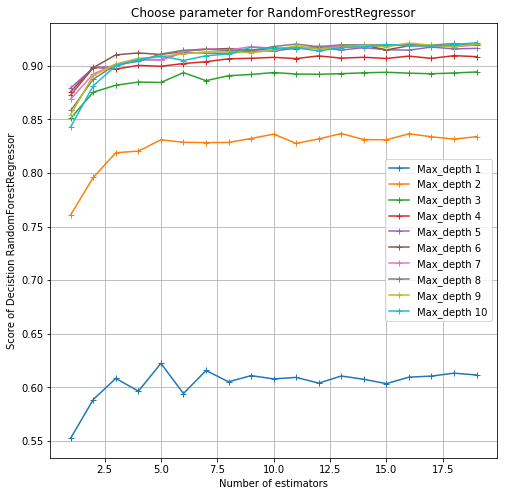

Parameters :  {'max_features': 'auto', 'max_depth': 10, 'n_estimators': 19}


In [285]:

regressor_grade.function(5)


In [286]:

param_rfr_re = {
    'max_depth':5,
    'random_state':1,
    'max_features':'auto',
    'n_estimators':5
    
}
regressor_grade.set_param(5,param_rfr_re)


regressor_grade.print_classifier_scores(5)


Score cross validation with Random Forest Regressor 0.911664678222
Score for generalization with Random Forest Regressor 0.894917771561



* Support Vector Regression


In [287]:

param_svr = {
    'kernel':'linear'
}
regressor_grade.set_param(6,param_svr)
regressor_grade.print_classifier_scores(6)


Score cross validation with Support Vector Regressor  0.916049744146
Score for generalization with Support Vector Regressor  0.910217469023


Score for the different regressors 
                                           Score
Linear Regression                       0.911235
KNeighborsRegressor                     0.549936
Stochastic Gradient Descent Regressor   0.906605
Multi Layer Perceptron Regressor        0.888750
Descision Tree Regression               0.642991
Random Forest Regressor                 0.894918
Support Vector Regressor                0.910217


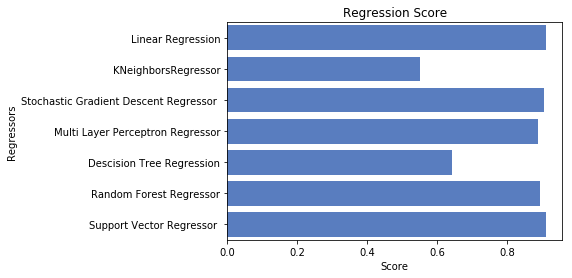

In [288]:
# Prints all the previous results 
regressor_grade.print_all_score()


Regressor chosen : Support Vector Regressor 


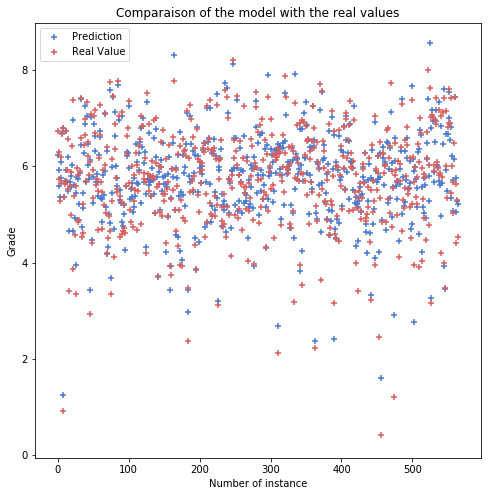

In [289]:
regressor_grade.plot_prediction("Grade")

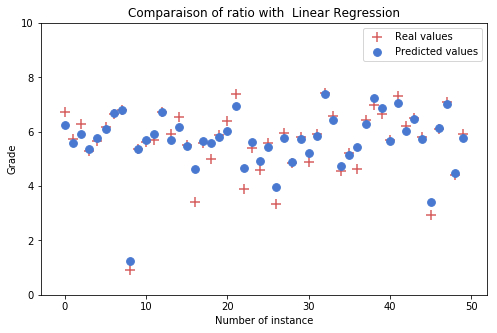

In [290]:
# Plots the predicted versus the real values for the 50 first ones

plot_predict_real(regressor_grade, 50, "Grade"," Linear Regression",\
                  [0,10],6)




<div class="alert alert-success">
We'll then split our data into genre sets
</div>


In [291]:
# Creates a new preprocess in order to create the split by genre
pre_process_genre = Preprocess(data)
# Splits by genre : we only keep the 8 first genres
pre_process_genre.split_by_genre(8)
# We split it into train and test
pre_process_genre.split_train_test()

['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime', 'Science Fiction']


In [292]:
# Computes the keywords_grade, cast_grade and crew_grade
pre_process_genre.compute_grade(liste_all_grade)

In [293]:
# Creates the dataset to remove some features and normalize
dataset_genre = Dataset(pre_process_genre)
# Creates the three labels : ratio, revenue and grade
dataset_genre.set_sets()
# Normalization
dataset_genre.normalize()


Genre :  Drama


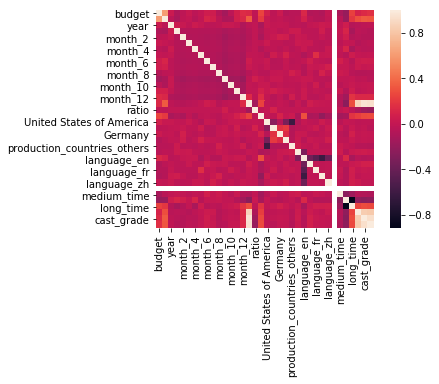

Genre :  Comedy


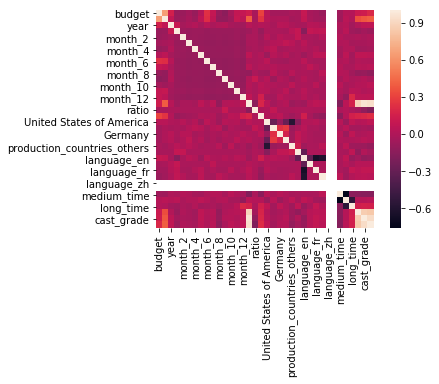

Genre :  Thriller


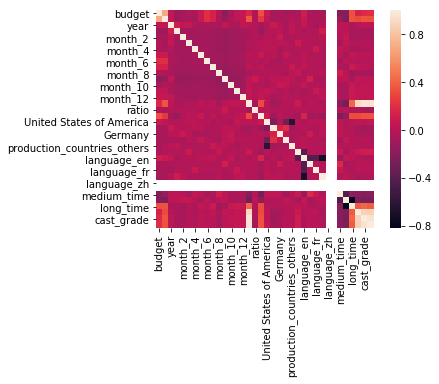

Genre :  Action


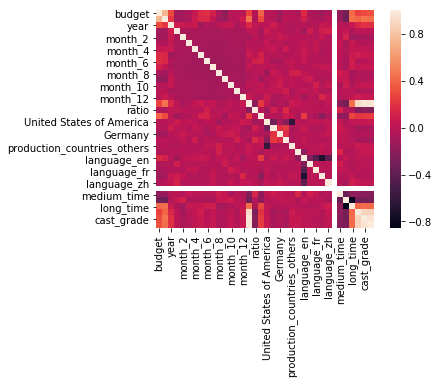

Genre :  Adventure


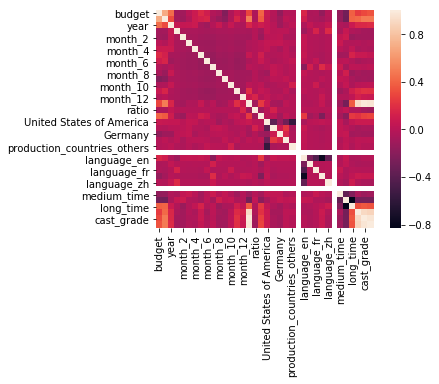

Genre :  Romance


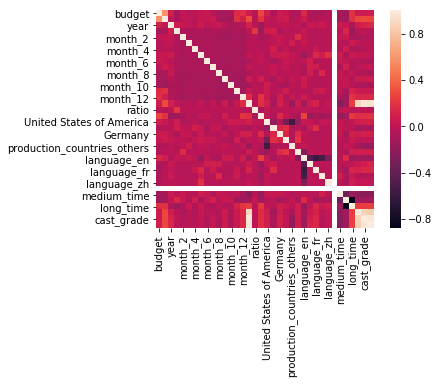

Genre :  Crime


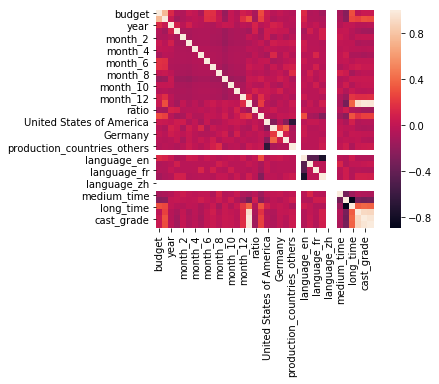

Genre :  Science Fiction


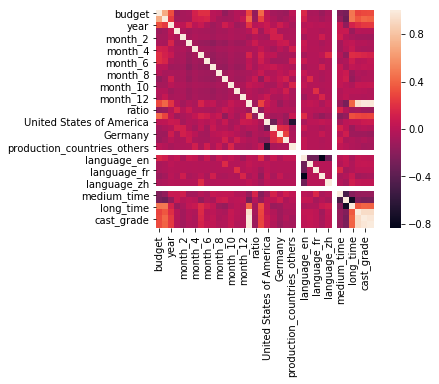

In [294]:
# List of all the genre used
liste_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance','Crime',\
               'Science Fiction']

# List of the values of the correlation matrix by genre
liste_corr_genre = [dataset_genre.pre_process.train[i].corr() for i in range(len(liste_genres))] 
# We plot the different matrix correlation
for index, x in enumerate(liste_corr_genre) :
    print("Genre : ",liste_genres[index])
    sns.heatmap(x, vmax=1, square=True)
    plt.show()
    
        
        

In [295]:
def compare_genre_regression(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_regressors = []
    for i in range(len(liste_genres)) :
        X_train, X_test, y_train, y_test = dataset_genre.get_grade_data(i)
        print(liste_genres[i])
        regressor = Regressors(X_train, y_train, X_test, y_test)
        regressor.set_regressors(liste_regressor)
        regressor.set_functions(liste_function)
        param_lr = {
            'normalize':False
        }
        regressor.set_param(0, param_lr)
        param_svr = {
            'kernel':'linear'
        }
        regressor.set_param(6,param_svr)
        for j in range(len(liste_regressor)) :
            if not(j == 0 or  j == 6) :
                regressor.function(j)
                regressor.print_classifier_scores(j)
        print("For regressor : ", liste_genres[i])
        regressor.print_all_score()
        liste_regressors.append(regressor)
        answer.append(regressor.print_best_regressor())
    return answer , liste_regressors


Drama


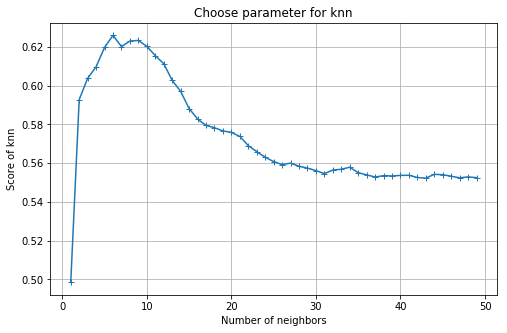

Parameters :  {'n_neighbors': 6, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.6260393709
Score for generalization with KNeighborsRegressor 0.583775376762
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.940525  0.940592  0.940515
huber                         -0.503228 -0.469225 -0.506162
epsilon_insensitive            0.946080  0.946073  0.946056
squared_epsilon_insensitive    0.938970  0.939045  0.938959
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.946079991464
Score for generalization with Stochastic Gradient Descent Regressor  0.853738762678
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.8129890402097063, 0.75734456464171074, 0.31694993023405987]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 'con

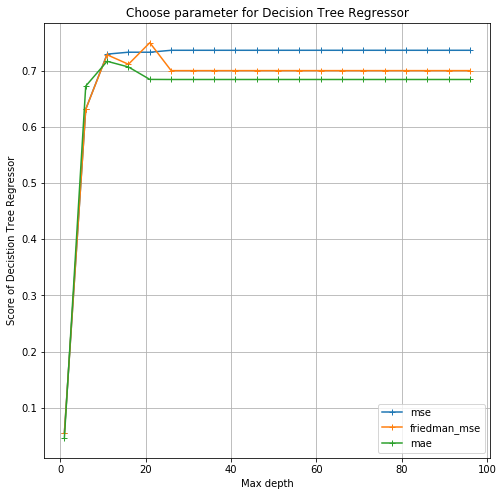

Parameters :  {'criterion': 'friedman_mse', 'max_features': 'log2', 'max_depth': 21, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.749580306669
Score for generalization with Descision Tree Regression 0.623358574194
Max depth : 9
Number of estimators : 14


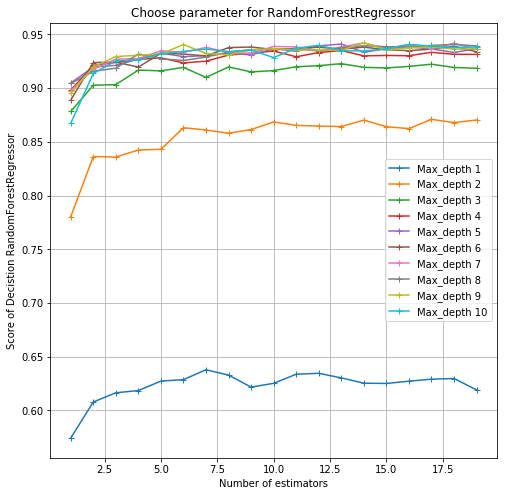

Parameters :  {'max_features': 'auto', 'max_depth': 9, 'n_estimators': 14}
Score cross validation with Random Forest Regressor 0.934582807098
Score for generalization with Random Forest Regressor 0.877460627875
For regressor :  Drama
Score for the different regressors 
                                           Score
Linear Regression                       0.859404
KNeighborsRegressor                     0.583775
Stochastic Gradient Descent Regressor   0.853739
Multi Layer Perceptron Regressor        0.831766
Descision Tree Regression               0.623359
Random Forest Regressor                 0.877461
Support Vector Regressor                0.859252


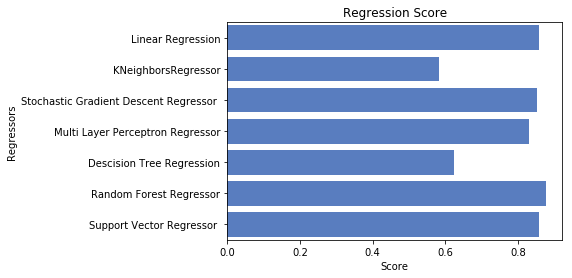

Comedy


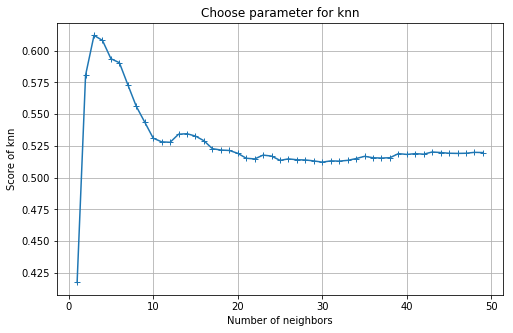

Parameters :  {'n_neighbors': 3, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.611959796307
Score for generalization with KNeighborsRegressor 0.515231603403
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.640375  0.641266  0.640218
huber                         -1.369209 -1.345251 -1.372476
epsilon_insensitive            0.648282  0.643076  0.645469
squared_epsilon_insensitive    0.639431  0.640197  0.639299
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.648281808171
Score for generalization with Stochastic Gradient Descent Regressor  0.770632221064
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.53535504266720091, 0.35212647819435994, 0.071130029334737305]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 

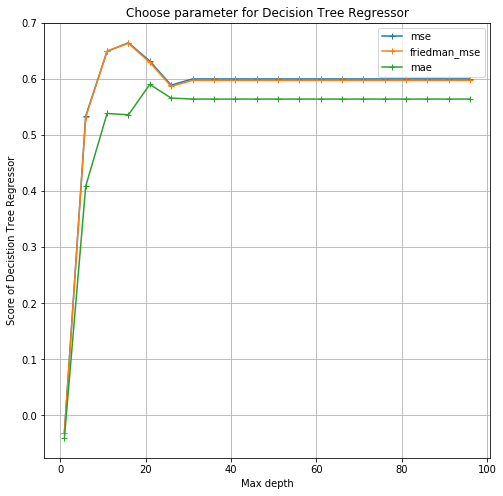

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 16, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.664947160018
Score for generalization with Descision Tree Regression 0.591584037476
Max depth : 9
Number of estimators : 13


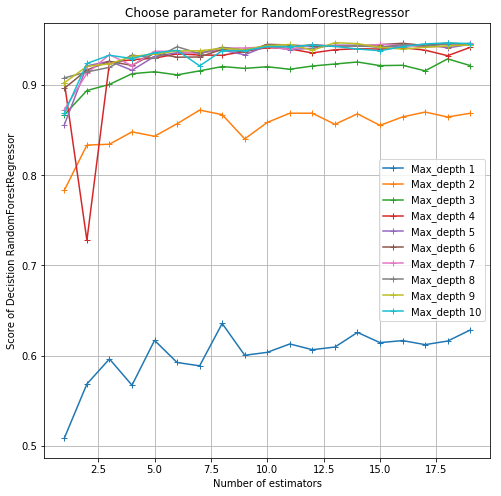

Parameters :  {'max_features': 'auto', 'max_depth': 9, 'n_estimators': 13}
Score cross validation with Random Forest Regressor 0.942247825481
Score for generalization with Random Forest Regressor 0.787268879468
For regressor :  Comedy
Score for the different regressors 
                                           Score
Linear Regression                       0.781859
KNeighborsRegressor                     0.515232
Stochastic Gradient Descent Regressor   0.770632
Multi Layer Perceptron Regressor        0.741727
Descision Tree Regression               0.591584
Random Forest Regressor                 0.787269
Support Vector Regressor                0.780078


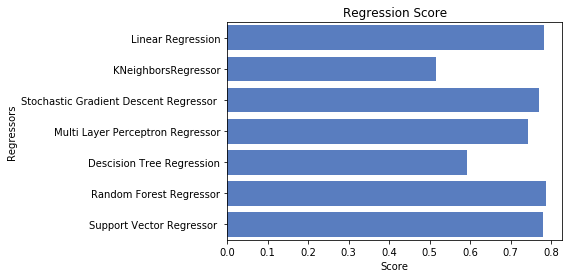

Thriller


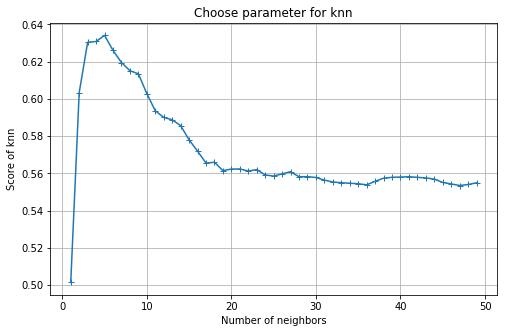

Parameters :  {'n_neighbors': 5, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.63414829087
Score for generalization with KNeighborsRegressor 0.547481132133
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.276251  0.277392  0.276050
huber                         -3.274087 -3.236255 -3.281157
epsilon_insensitive            0.271283  0.273696  0.268739
squared_epsilon_insensitive    0.268228  0.268974  0.268096
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.277392468208
Score for generalization with Stochastic Gradient Descent Regressor  0.866023062684
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.75870068724527828, 0.47509794101857389, -0.028522422052209652]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 'constant', 'ra

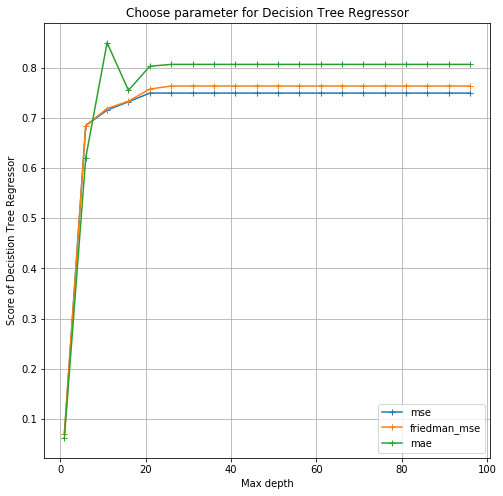

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 11, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.84952516901
Score for generalization with Descision Tree Regression 0.808550740113
Max depth : 8
Number of estimators : 8


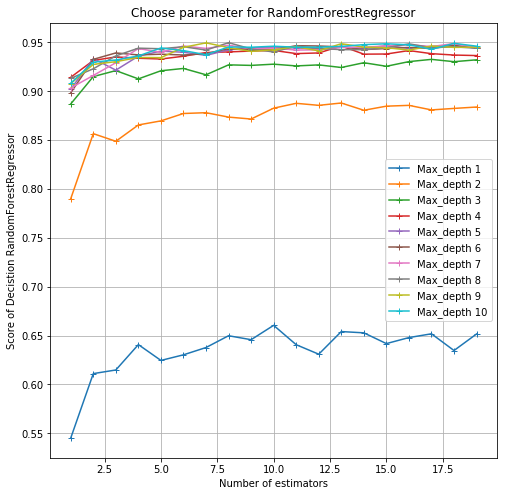

Parameters :  {'max_features': 'auto', 'max_depth': 8, 'n_estimators': 8}
Score cross validation with Random Forest Regressor 0.942930333896
Score for generalization with Random Forest Regressor 0.891014073678
For regressor :  Thriller
Score for the different regressors 
                                           Score
Linear Regression                       0.864999
KNeighborsRegressor                     0.547481
Stochastic Gradient Descent Regressor   0.866023
Multi Layer Perceptron Regressor        0.838011
Descision Tree Regression               0.808551
Random Forest Regressor                 0.891014
Support Vector Regressor                0.865925


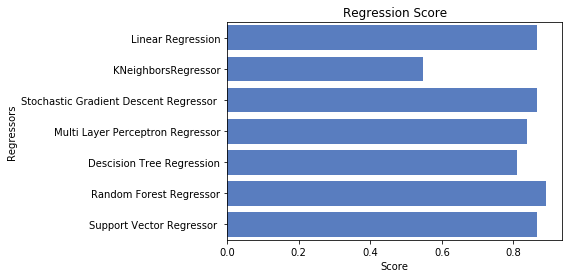

Action


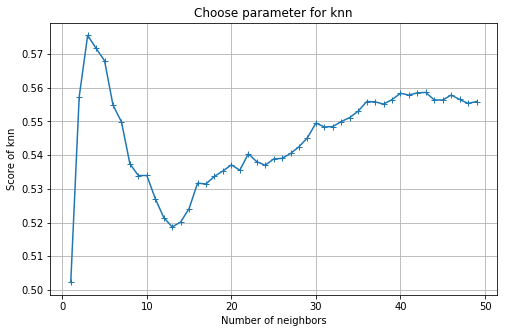

Parameters :  {'n_neighbors': 3, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.575506683409
Score for generalization with KNeighborsRegressor 0.579300862476
Score for different parameters : 
                             elasticnet         l1         l2
squared_loss                   0.716504   0.717379   0.716346
huber                         -3.022929  -3.036547  -3.036526
epsilon_insensitive            0.691614   0.706377   0.705755
squared_epsilon_insensitive  -44.259717 -44.184333 -44.273027
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.717379471705
Score for generalization with Stochastic Gradient Descent Regressor  0.876324946696
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.68224558985811656, 0.051646975761108792, -0.099829590713096245]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 'co

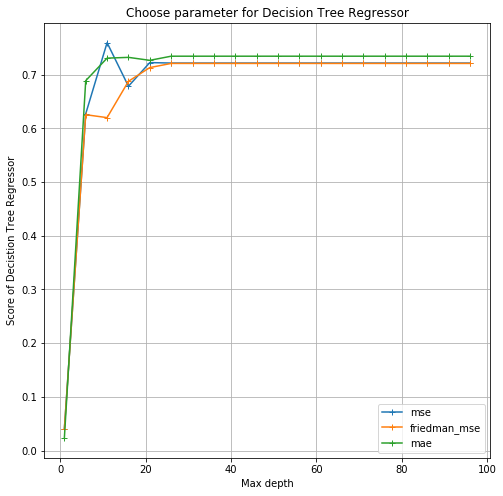

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 11, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.759480684842
Score for generalization with Descision Tree Regression 0.667922531955
Max depth : 9
Number of estimators : 18


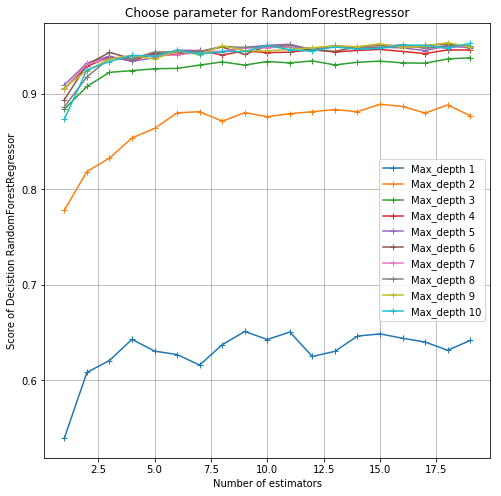

Parameters :  {'max_features': 'auto', 'max_depth': 9, 'n_estimators': 18}
Score cross validation with Random Forest Regressor 0.950442352405
Score for generalization with Random Forest Regressor 0.859538525072
For regressor :  Action
Score for the different regressors 
                                           Score
Linear Regression                       0.879689
KNeighborsRegressor                     0.579301
Stochastic Gradient Descent Regressor   0.876325
Multi Layer Perceptron Regressor        0.814055
Descision Tree Regression               0.667923
Random Forest Regressor                 0.859539
Support Vector Regressor                0.881403


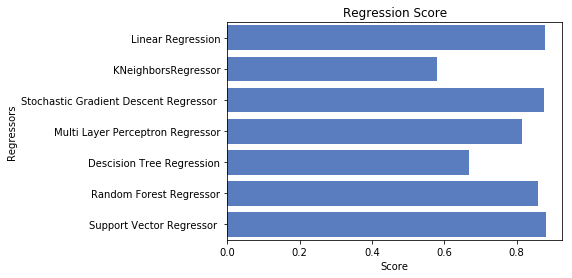

Adventure


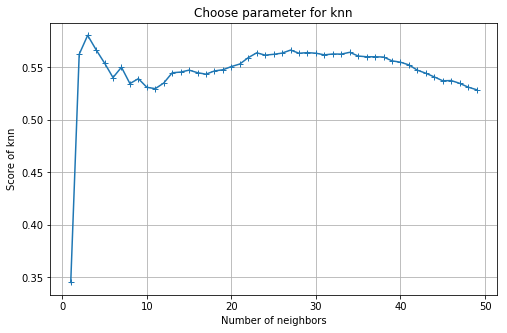

Parameters :  {'n_neighbors': 3, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.580613856809
Score for generalization with KNeighborsRegressor 0.532522484945
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.809736  0.810445  0.809607
huber                         -7.046721 -7.025187 -7.054295
epsilon_insensitive            0.847429  0.847001  0.847826
squared_epsilon_insensitive   -0.471772 -0.467717 -0.472489
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.847825533053
Score for generalization with Stochastic Gradient Descent Regressor  0.850845464264
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.5966683990167867, 0.31176217525298788, -0.78660308500230258]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 'constant

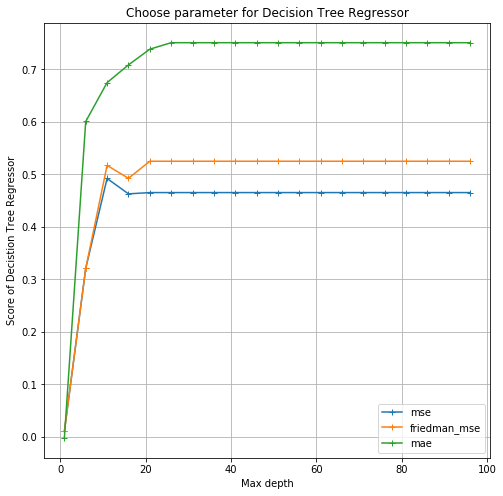

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 26, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.750758989726
Score for generalization with Descision Tree Regression 0.64754381624
Max depth : 8
Number of estimators : 15


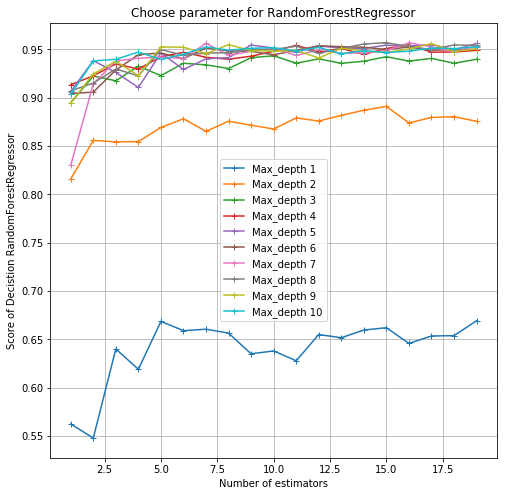

Parameters :  {'max_features': 'auto', 'max_depth': 8, 'n_estimators': 15}
Score cross validation with Random Forest Regressor 0.950530304905
Score for generalization with Random Forest Regressor 0.872931011621
For regressor :  Adventure
Score for the different regressors 
                                           Score
Linear Regression                       0.846449
KNeighborsRegressor                     0.532522
Stochastic Gradient Descent Regressor   0.850845
Multi Layer Perceptron Regressor        0.742781
Descision Tree Regression               0.647544
Random Forest Regressor                 0.872931
Support Vector Regressor                0.848975


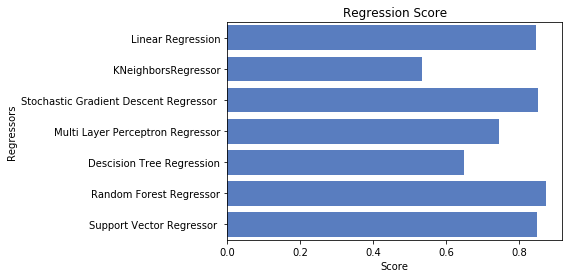

Romance


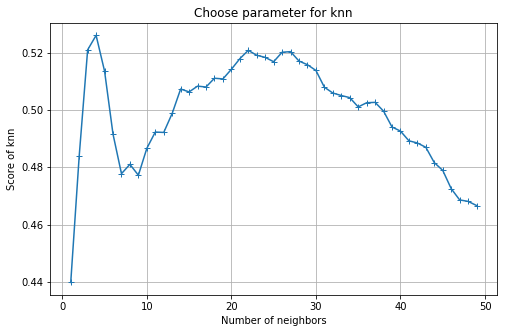

Parameters :  {'n_neighbors': 4, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.525983993933
Score for generalization with KNeighborsRegressor 0.506025616286
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.640518  0.641520  0.640342
huber                         -8.127632 -8.104124 -8.136264
epsilon_insensitive            0.702279  0.706627  0.700415
squared_epsilon_insensitive    0.674476  0.675285  0.674333
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.706627290315
Score for generalization with Stochastic Gradient Descent Regressor  0.791894117979
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.62242413334531133, 0.031775268043207495, -1.009661834195881]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 'constant

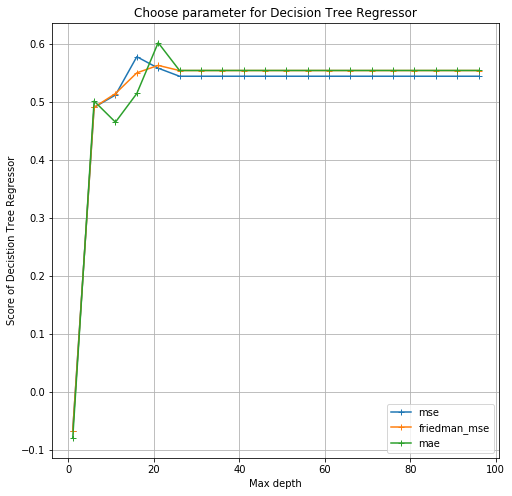

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 21, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.602044840907
Score for generalization with Descision Tree Regression 0.807448811206
Max depth : 9
Number of estimators : 5


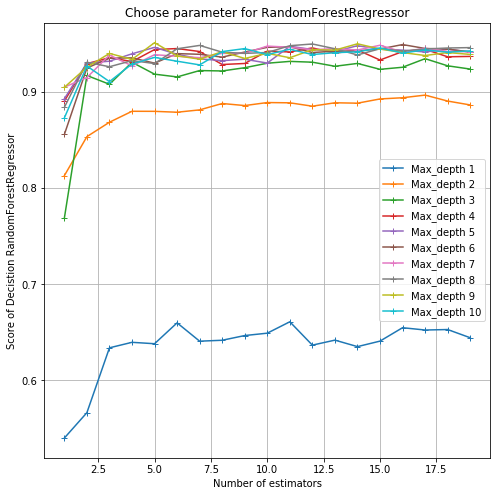

Parameters :  {'max_features': 'auto', 'max_depth': 9, 'n_estimators': 5}
Score cross validation with Random Forest Regressor 0.937744439048
Score for generalization with Random Forest Regressor 0.815417712575
For regressor :  Romance
Score for the different regressors 
                                           Score
Linear Regression                       0.809150
KNeighborsRegressor                     0.506026
Stochastic Gradient Descent Regressor   0.791894
Multi Layer Perceptron Regressor        0.734246
Descision Tree Regression               0.807449
Random Forest Regressor                 0.815418
Support Vector Regressor                0.801005


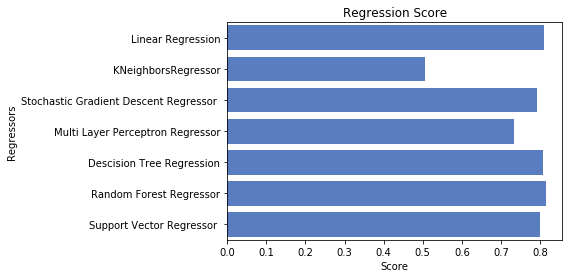

Crime


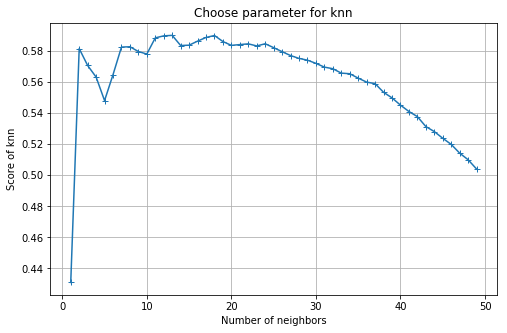

Parameters :  {'n_neighbors': 13, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.590017434833
Score for generalization with KNeighborsRegressor 0.406195269568
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                  -0.312694 -0.311632 -0.312881
huber                         -9.253381 -9.193590 -9.258938
epsilon_insensitive           -0.400238 -0.302102 -0.401373
squared_epsilon_insensitive   -0.260360 -0.259621 -0.260490
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.259620988139
Score for generalization with Stochastic Gradient Descent Regressor  0.788479644962
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.81018059824523569, 0.54999245035196631, -1.6856500786918034]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate':

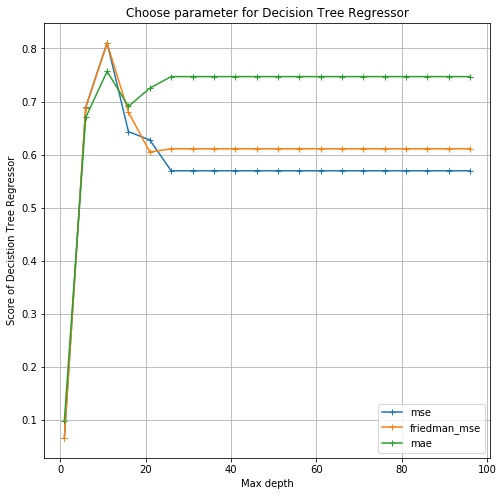

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 11, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.810810632806
Score for generalization with Descision Tree Regression 0.691513511984
Max depth : 7
Number of estimators : 11


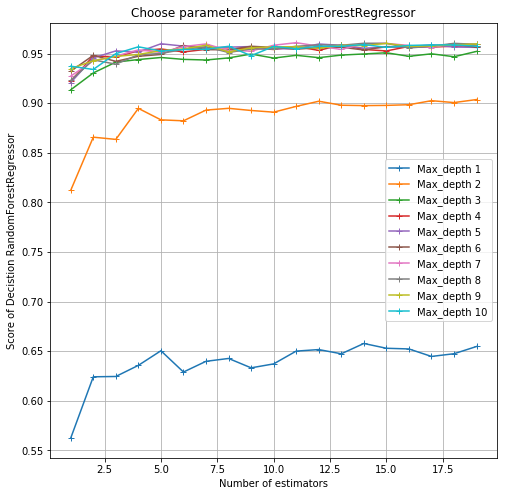

Parameters :  {'max_features': 'auto', 'max_depth': 7, 'n_estimators': 11}
Score cross validation with Random Forest Regressor 0.956814631278
Score for generalization with Random Forest Regressor 0.762625808151
For regressor :  Crime
Score for the different regressors 
                                           Score
Linear Regression                       0.787270
KNeighborsRegressor                     0.406195
Stochastic Gradient Descent Regressor   0.788480
Multi Layer Perceptron Regressor        0.692023
Descision Tree Regression               0.691514
Random Forest Regressor                 0.762626
Support Vector Regressor                0.785818


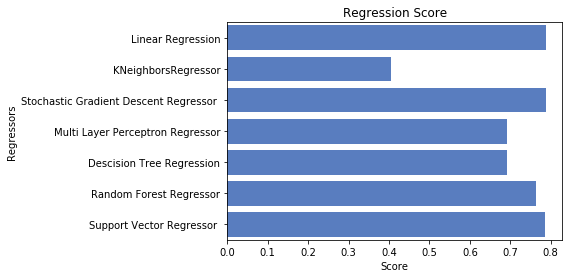

Science Fiction


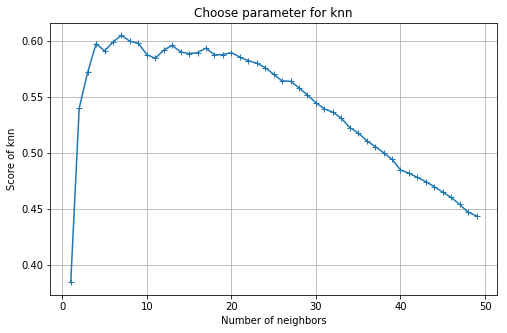

Parameters :  {'n_neighbors': 7, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.604614852146
Score for generalization with KNeighborsRegressor 0.380924842423
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.283611  0.285245  0.283324
huber                         -7.820414 -7.772630 -7.825226
epsilon_insensitive            0.302007  0.307980  0.297368
squared_epsilon_insensitive    0.302510  0.303754  0.302290
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.307979996606
Score for generalization with Stochastic Gradient Descent Regressor  0.824708729655
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [0.55805442944779382, 0.18026378974597551, -1.2248489090997106]
Parameters :  {'solver': 'lbfgs', 'shuffle': True, 'learning_rate': 'constant

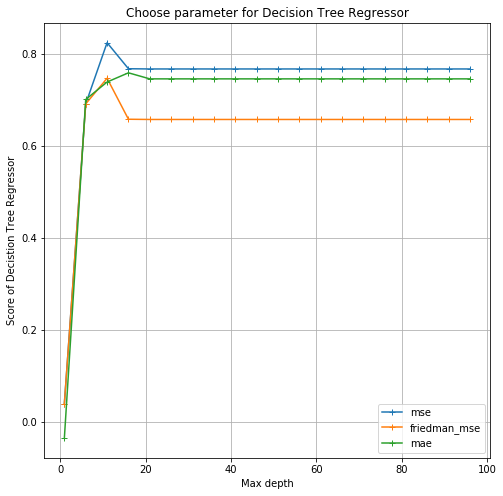

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 11, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.824748843106
Score for generalization with Descision Tree Regression 0.561469855518
Max depth : 6
Number of estimators : 14


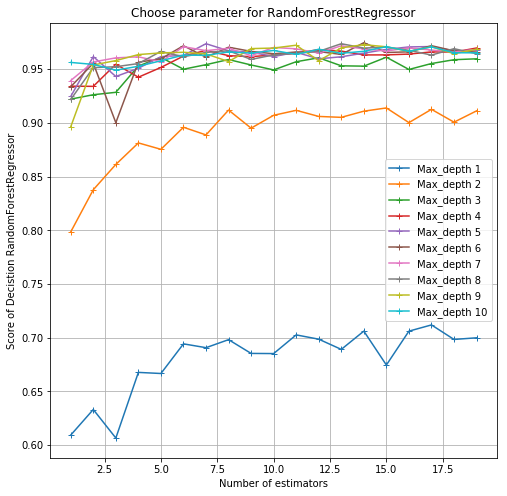

Parameters :  {'max_features': 'auto', 'max_depth': 6, 'n_estimators': 14}
Score cross validation with Random Forest Regressor 0.971754190228
Score for generalization with Random Forest Regressor 0.830133696475
For regressor :  Science Fiction
Score for the different regressors 
                                           Score
Linear Regression                       0.821075
KNeighborsRegressor                     0.380925
Stochastic Gradient Descent Regressor   0.824709
Multi Layer Perceptron Regressor        0.786546
Descision Tree Regression               0.561470
Random Forest Regressor                 0.830134
Support Vector Regressor                0.820548


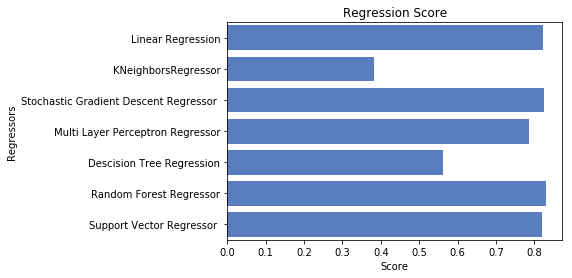

In [296]:
answer_grade, regressors_genre_grade = compare_genre_regression(liste_genres, dataset_genre)

In [297]:
print(answer_grade)

['Best regressor : Support Vector Regressor  for a score : 0.859251618157', 'Best regressor : Support Vector Regressor  for a score : 0.780078337407', 'Best regressor : Support Vector Regressor  for a score : 0.865925461719', 'Best regressor : Support Vector Regressor  for a score : 0.881403171038', 'Best regressor : Support Vector Regressor  for a score : 0.848974614325', 'Best regressor : Support Vector Regressor  for a score : 0.801005497691', 'Best regressor : Support Vector Regressor  for a score : 0.785817909201', 'Best regressor : Support Vector Regressor  for a score : 0.82054839882']


In [298]:
# It will plot the regressors, score for each genre
def plot_graph_genre(regressors,liste_genres) :
    liste_max_score = []
    liste_name_reg = []
    for index, regressor in enumerate(regressors) :
        max_score = np.max(regressor.list_score)
        index_max = np.argmax(regressor.list_score)
        name_reg = regressor.regressors_name[index_max]
        liste_max_score.append(max_score)
        liste_name_reg.append(name_reg)
    
    score_regressors = {}
    score_regressors['Score'] = liste_max_score
    score_regressors['Regressor used'] = liste_name_reg
    score_class_df = pd.DataFrame(score_regressors, index =liste_genres)        
    print(score_class_df)            


In [299]:
plot_graph_genre(regressors_genre_grade,liste_genres)

                                         Regressor used     Score
Drama                           Random Forest Regressor  0.877461
Comedy                          Random Forest Regressor  0.787269
Thriller                        Random Forest Regressor  0.891014
Action                        Support Vector Regressor   0.881403
Adventure                       Random Forest Regressor  0.872931
Romance                         Random Forest Regressor  0.815418
Crime            Stochastic Gradient Descent Regressor   0.788480
Science Fiction                 Random Forest Regressor  0.830134


In [300]:
def compare_genre_regression_re(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_regressors = []
    for i in range(len(liste_genres)) :
        X_train, X_test, y_train, y_test = dataset_genre.get_revenue_data(i)
        print(liste_genres[i])
        regressor = Regressors(X_train, y_train, X_test, y_test)
        regressor.set_regressors(liste_regressor)
        regressor.set_functions(liste_function)
        param_lr = {
            'normalize':False
        }
        regressor.set_param(0, param_lr)
        param_svr = {
            'kernel':'linear'
        }
        regressor.set_param(6,param_svr)
        for j in range(len(liste_regressor)) :
            if not(j == 0 or  j == 6) :
                regressor.function(j)
                regressor.print_classifier_scores(j)
        print("For regressor : ", liste_genres[i])
        regressor.print_all_score()
        liste_regressors.append(regressor)
        answer.append(regressor.print_best_regressor())
    return answer , liste_regressors


Drama


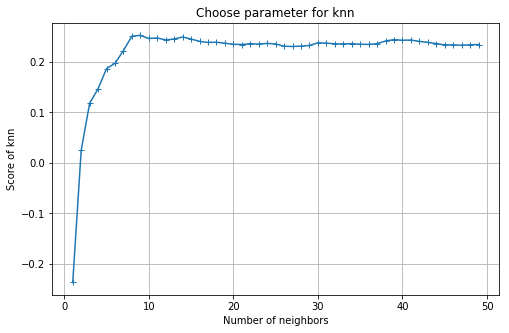

Parameters :  {'n_neighbors': 9, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.252847622673
Score for generalization with KNeighborsRegressor 0.329291545106
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.409569  0.409533  0.409576
huber                         -0.464919 -0.464919 -0.464919
epsilon_insensitive           -0.464916 -0.464916 -0.464916
squared_epsilon_insensitive    0.408301  0.408283  0.408304
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.409575817005
Score for generalization with Stochastic Gradient Descent Regressor  0.557775011037
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-1.6257058050347439, -237050377.74554339, -0.46491106679012206]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'constant', 'ran

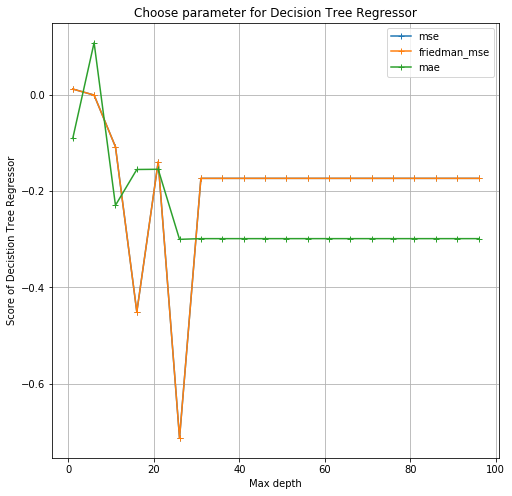

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 6, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.107857272409
Score for generalization with Descision Tree Regression 0.142632596658
Max depth : 5
Number of estimators : 13


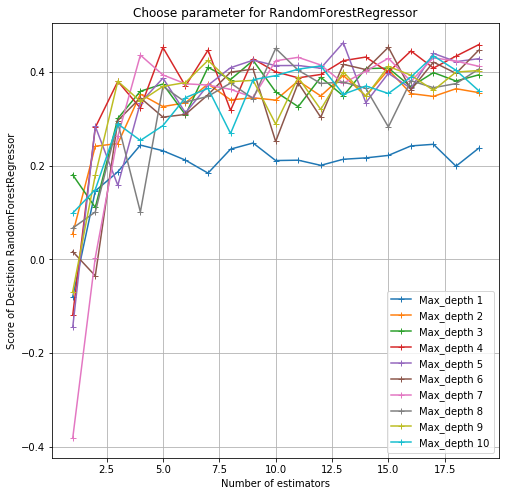

Parameters :  {'max_features': 'auto', 'max_depth': 5, 'n_estimators': 13}
Score cross validation with Random Forest Regressor 0.448479860299
Score for generalization with Random Forest Regressor 0.536910277653
For regressor :  Drama
Score for the different regressors 
                                           Score
Linear Regression                       0.558639
KNeighborsRegressor                     0.329292
Stochastic Gradient Descent Regressor   0.557775
Multi Layer Perceptron Regressor       -0.431967
Descision Tree Regression               0.142633
Random Forest Regressor                 0.536910
Support Vector Regressor               -0.090792


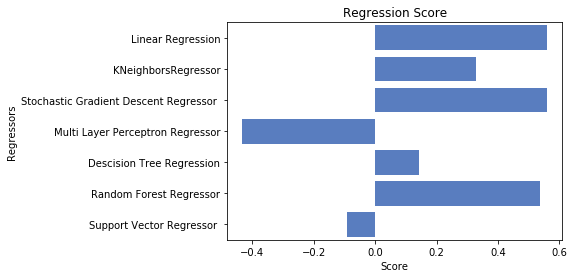

Comedy


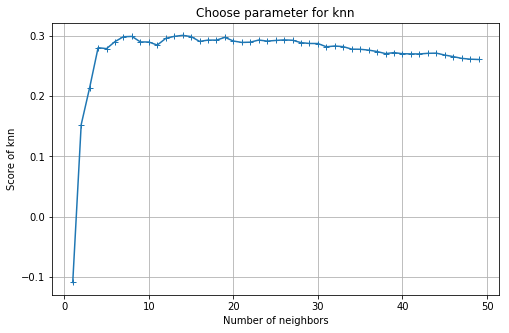

Parameters :  {'n_neighbors': 14, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.300733052214
Score for generalization with KNeighborsRegressor 0.260186088649
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.454405  0.454243  0.454433
huber                         -0.707695 -0.707695 -0.707695
epsilon_insensitive           -0.707693 -0.707693 -0.707693
squared_epsilon_insensitive    0.452167  0.452007  0.452195
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.454433156296
Score for generalization with Stochastic Gradient Descent Regressor  0.442073239177
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-3.7018607461607393, -1009811740.7280353, -0.70769211696978773]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'constant', 'ra

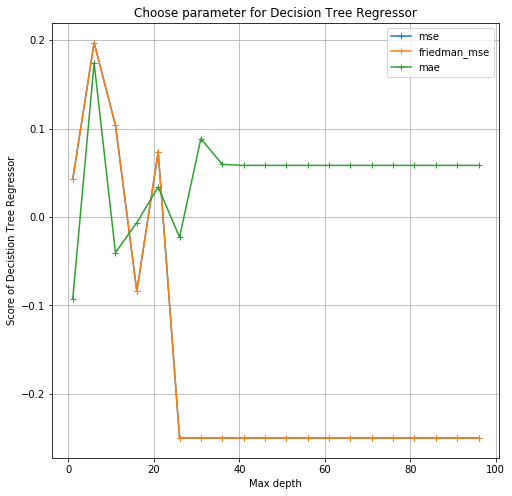

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 6, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.197069101331
Score for generalization with Descision Tree Regression 0.345875402711
Max depth : 9
Number of estimators : 18


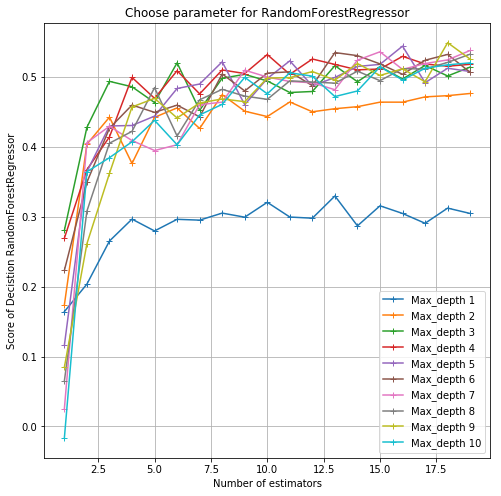

Parameters :  {'max_features': 'auto', 'max_depth': 9, 'n_estimators': 18}
Score cross validation with Random Forest Regressor 0.51785363441
Score for generalization with Random Forest Regressor 0.459628829895
For regressor :  Comedy
Score for the different regressors 
                                           Score
Linear Regression                       0.442195
KNeighborsRegressor                     0.260186
Stochastic Gradient Descent Regressor   0.442073
Multi Layer Perceptron Regressor       -0.481589
Descision Tree Regression               0.345875
Random Forest Regressor                 0.459629
Support Vector Regressor               -0.109692


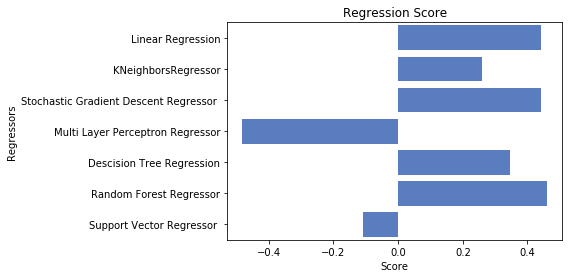

Thriller


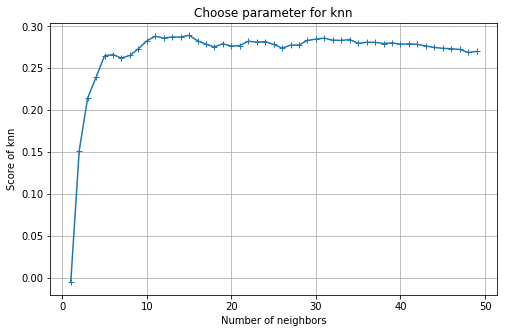

Parameters :  {'n_neighbors': 15, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.289254007947
Score for generalization with KNeighborsRegressor 0.331617851294
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.419488  0.419259  0.419528
huber                         -0.649569 -0.649569 -0.649569
epsilon_insensitive           -0.649567 -0.649567 -0.649567
squared_epsilon_insensitive    0.416449  0.416240  0.416486
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.419527842928
Score for generalization with Stochastic Gradient Descent Regressor  0.595458194613
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-1.2032468503243072, -6385310125.7329741, -0.64956668326658829]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'constant', 'ra

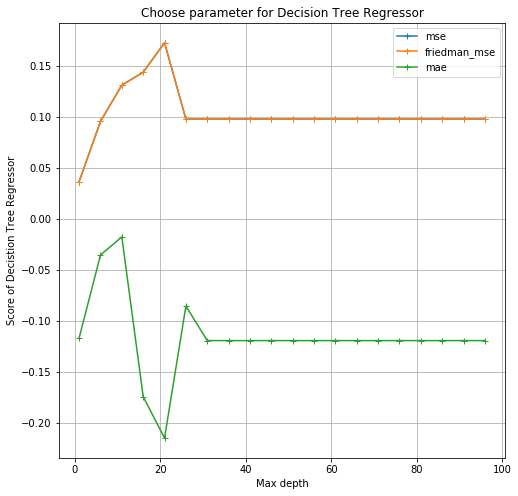

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 21, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.172410240848
Score for generalization with Descision Tree Regression 0.115253740114
Max depth : 4
Number of estimators : 18


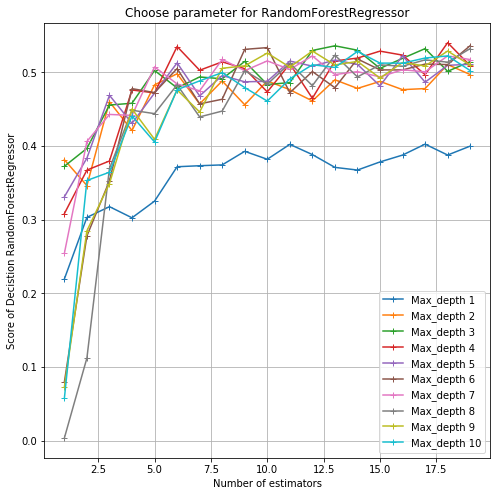

Parameters :  {'max_features': 'auto', 'max_depth': 4, 'n_estimators': 18}
Score cross validation with Random Forest Regressor 0.519081785689
Score for generalization with Random Forest Regressor 0.674397223027
For regressor :  Thriller
Score for the different regressors 
                                           Score
Linear Regression                       0.592946
KNeighborsRegressor                     0.331618
Stochastic Gradient Descent Regressor   0.595458
Multi Layer Perceptron Regressor       -0.378734
Descision Tree Regression               0.115254
Random Forest Regressor                 0.674397
Support Vector Regressor               -0.093425


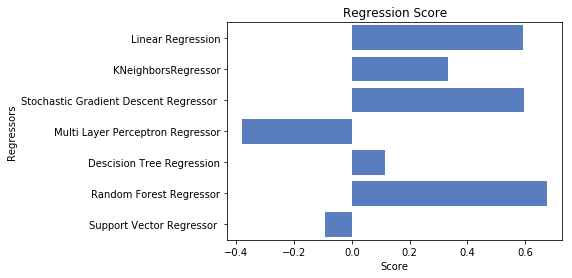

Action


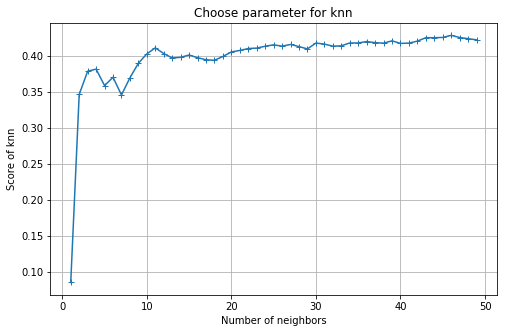

Parameters :  {'n_neighbors': 46, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.428430376923
Score for generalization with KNeighborsRegressor 0.335002609746
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.534787  0.534670  0.534808
huber                         -0.587558 -0.587558 -0.587558
epsilon_insensitive           -0.587557 -0.587557 -0.587557
squared_epsilon_insensitive    0.293091  0.292933  0.293119
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.534807985691
Score for generalization with Stochastic Gradient Descent Regressor  0.47533313545
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-0.92073510181003149, -116755854170.51822, -0.5875563060577127]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'constant', 'ran

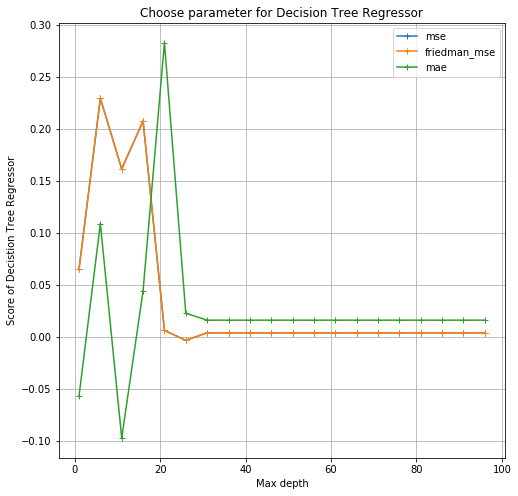

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 21, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.283068892318
Score for generalization with Descision Tree Regression -0.427425196144
Max depth : 7
Number of estimators : 8


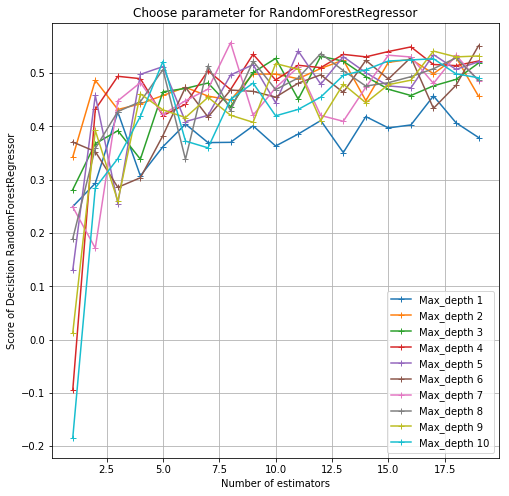

Parameters :  {'max_features': 'auto', 'max_depth': 7, 'n_estimators': 8}
Score cross validation with Random Forest Regressor 0.490672650267
Score for generalization with Random Forest Regressor 0.473556039276
For regressor :  Action
Score for the different regressors 
                                           Score
Linear Regression                       0.468019
KNeighborsRegressor                     0.335003
Stochastic Gradient Descent Regressor   0.475333
Multi Layer Perceptron Regressor       -0.844898
Descision Tree Regression              -0.427425
Random Forest Regressor                 0.473556
Support Vector Regressor               -0.137413


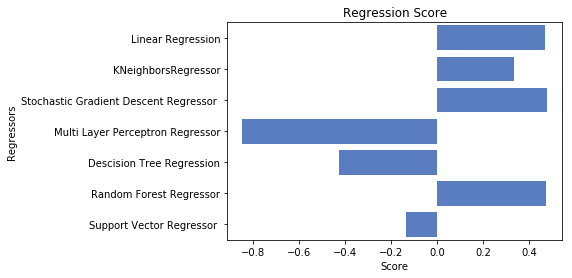

Adventure


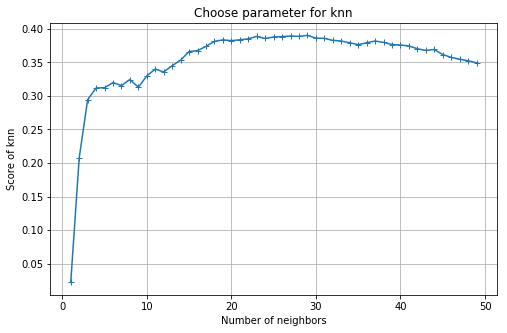

Parameters :  {'n_neighbors': 29, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.390229595764
Score for generalization with KNeighborsRegressor 0.254359695879
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.395500  0.395392  0.395519
huber                         -0.910158 -0.910158 -0.910158
epsilon_insensitive           -0.910157 -0.910157 -0.910157
squared_epsilon_insensitive    0.396015  0.395940  0.396028
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.39602795092
Score for generalization with Stochastic Gradient Descent Regressor  0.438981477307
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-1.124098418062508, -26689031569.172272, -0.91015737607946201]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'c

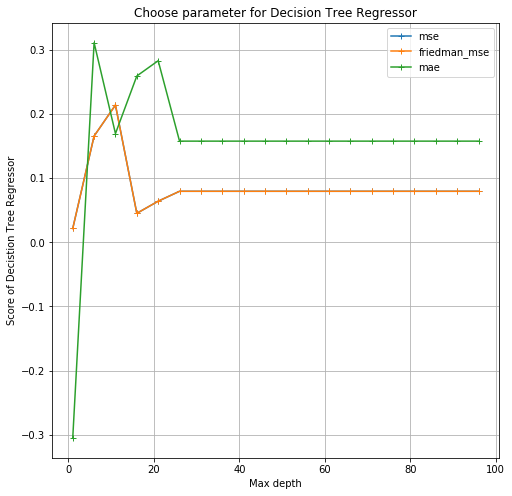

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 6, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.311049680798
Score for generalization with Descision Tree Regression 0.154989721867
Max depth : 4
Number of estimators : 16


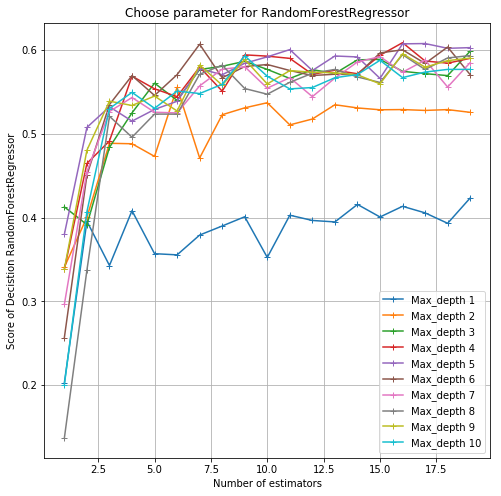

Parameters :  {'max_features': 'auto', 'max_depth': 4, 'n_estimators': 16}
Score cross validation with Random Forest Regressor 0.58891397665
Score for generalization with Random Forest Regressor 0.513008455448
For regressor :  Adventure
Score for the different regressors 
                                           Score
Linear Regression                       0.439949
KNeighborsRegressor                     0.254360
Stochastic Gradient Descent Regressor   0.438981
Multi Layer Perceptron Regressor       -0.514823
Descision Tree Regression               0.154990
Random Forest Regressor                 0.513008
Support Vector Regressor               -0.076513


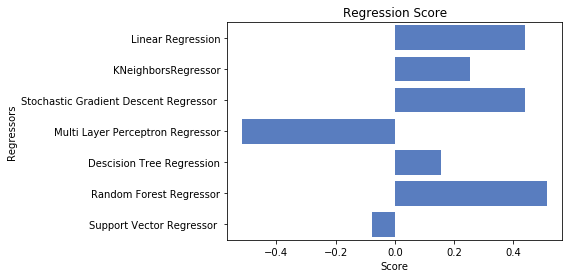

Romance


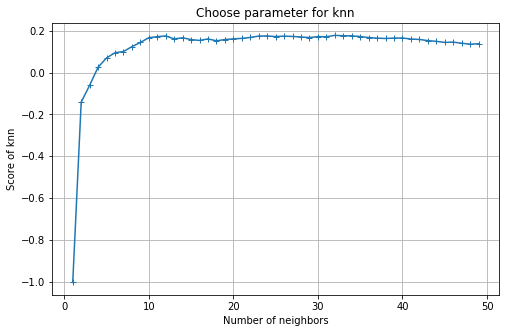

Parameters :  {'n_neighbors': 32, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.178026474675
Score for generalization with KNeighborsRegressor 0.177195135634
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.175228  0.175023  0.175263
huber                         -0.628457 -0.628457 -0.628457
epsilon_insensitive           -0.628455 -0.628455 -0.628455
squared_epsilon_insensitive    0.164384  0.164216  0.164413
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.175263393959
Score for generalization with Stochastic Gradient Descent Regressor  0.364466851547
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-7.4732251428185119, -482543396.7298485, -0.62845633058877437]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'constant', 'ran

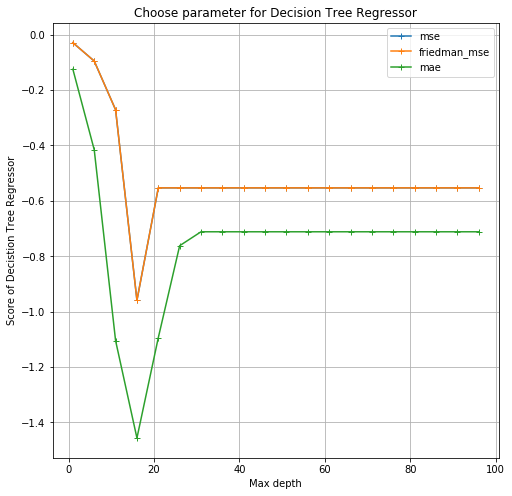

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0289504306758
Score for generalization with Descision Tree Regression -0.0847408608514
Max depth : 6
Number of estimators : 15


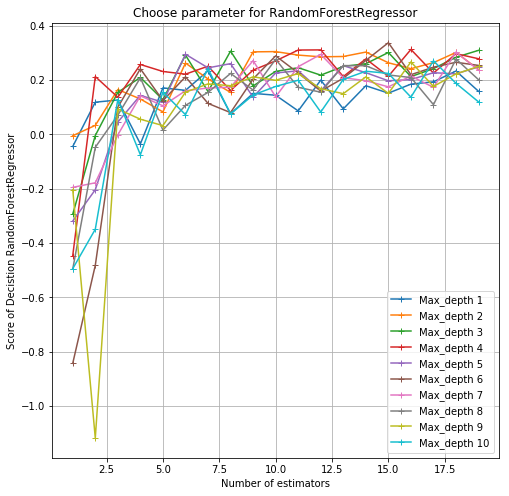

Parameters :  {'max_features': 'auto', 'max_depth': 6, 'n_estimators': 15}
Score cross validation with Random Forest Regressor 0.141678447161
Score for generalization with Random Forest Regressor 0.234187297543
For regressor :  Romance
Score for the different regressors 
                                           Score
Linear Regression                       0.366867
KNeighborsRegressor                     0.177195
Stochastic Gradient Descent Regressor   0.364467
Multi Layer Perceptron Regressor       -0.576998
Descision Tree Regression              -0.084741
Random Forest Regressor                 0.234187
Support Vector Regressor               -0.108701


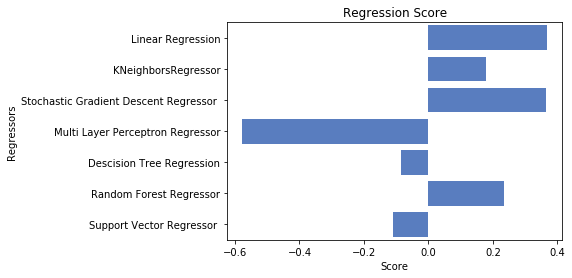

Crime


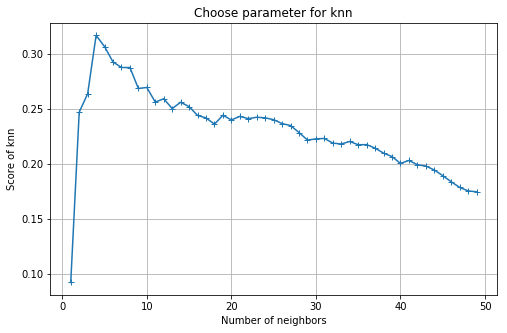

Parameters :  {'n_neighbors': 4, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.317102463387
Score for generalization with KNeighborsRegressor 0.144325957005
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.410587  0.410329  0.410632
huber                         -0.598332 -0.598332 -0.598332
epsilon_insensitive           -0.598330 -0.598330 -0.598330
squared_epsilon_insensitive    0.399621  0.399380  0.399664
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.410632458192
Score for generalization with Stochastic Gradient Descent Regressor  0.484200364187
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-0.63370256855652318, -1222506755.5592387, -0.59833088905787846]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'constant', 'ra

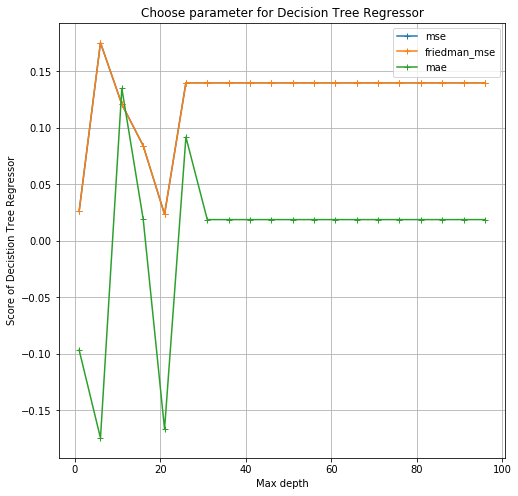

Parameters :  {'criterion': 'mse', 'max_features': 'log2', 'max_depth': 6, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.175303815764
Score for generalization with Descision Tree Regression -0.285130752224
Max depth : 5
Number of estimators : 13


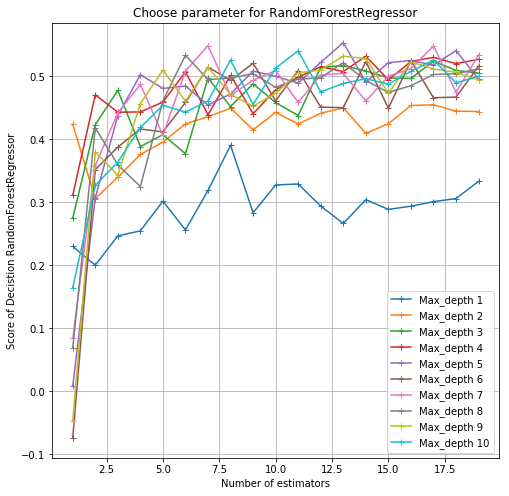

Parameters :  {'max_features': 'auto', 'max_depth': 5, 'n_estimators': 13}
Score cross validation with Random Forest Regressor 0.502607744716
Score for generalization with Random Forest Regressor 0.484294793162
For regressor :  Crime
Score for the different regressors 
                                           Score
Linear Regression                       0.485472
KNeighborsRegressor                     0.144326
Stochastic Gradient Descent Regressor   0.484200
Multi Layer Perceptron Regressor       -0.959895
Descision Tree Regression              -0.285131
Random Forest Regressor                 0.484295
Support Vector Regressor               -0.145976


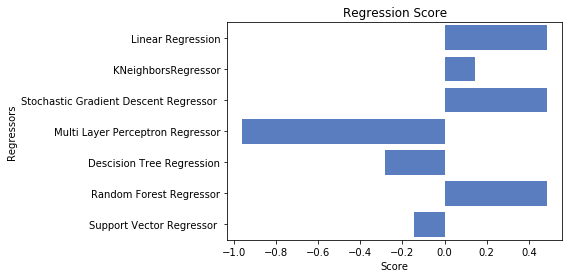

Science Fiction


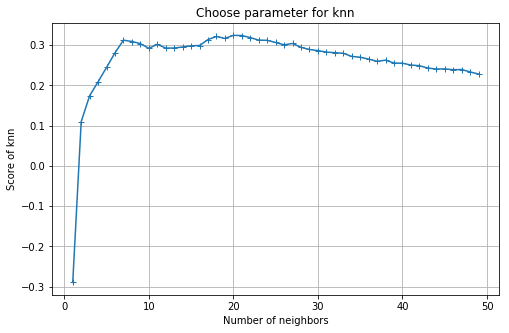

Parameters :  {'n_neighbors': 20, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor 0.324058278874
Score for generalization with KNeighborsRegressor 0.459416845913
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                   0.335258  0.335001  0.335303
huber                         -0.568063 -0.568063 -0.568063
epsilon_insensitive           -0.568062 -0.568062 -0.568062
squared_epsilon_insensitive    0.328169  0.327948  0.328208
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'squared_loss', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  0.335302781161
Score for generalization with Stochastic Gradient Descent Regressor  0.635913996957
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-1.602816409511862, -72640396915.991562, -0.56806284315159772]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'constant', 'ran

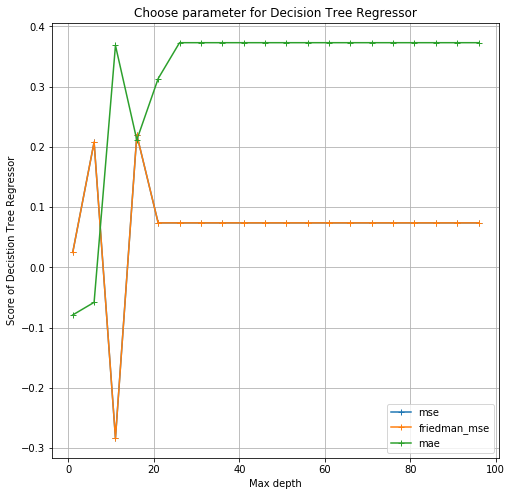

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 26, 'random_state': 1}
Score cross validation with Descision Tree Regression 0.372887258168
Score for generalization with Descision Tree Regression 0.368026334131
Max depth : 5
Number of estimators : 6


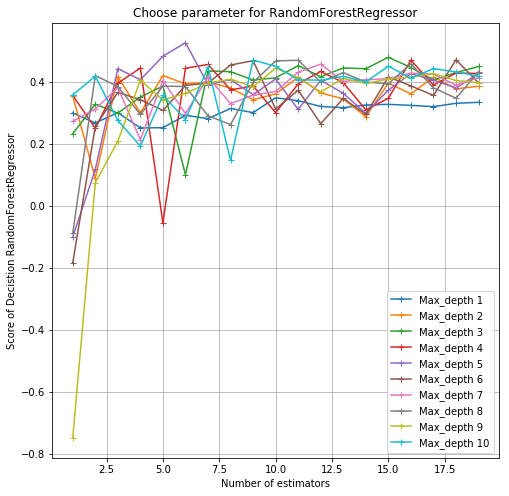

Parameters :  {'max_features': 'auto', 'max_depth': 5, 'n_estimators': 6}
Score cross validation with Random Forest Regressor 0.392922249619
Score for generalization with Random Forest Regressor 0.557503546537
For regressor :  Science Fiction
Score for the different regressors 
                                           Score
Linear Regression                       0.637479
KNeighborsRegressor                     0.459417
Stochastic Gradient Descent Regressor   0.635914
Multi Layer Perceptron Regressor       -0.597478
Descision Tree Regression               0.368026
Random Forest Regressor                 0.557504
Support Vector Regressor               -0.233888


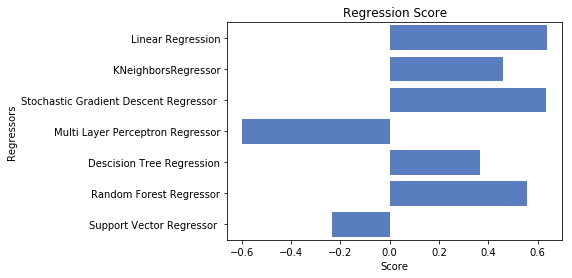

In [301]:
answer_revenue, regressors_revenue_grade = compare_genre_regression_re(liste_genres, dataset_genre)

In [302]:
print(answer_revenue)

['Best regressor : Random Forest Regressor for a score : 0.536910277653', 'Best regressor : Random Forest Regressor for a score : 0.459628829895', 'Best regressor : Random Forest Regressor for a score : 0.674397223027', 'Best regressor : Stochastic Gradient Descent Regressor  for a score : 0.47533313545', 'Best regressor : Random Forest Regressor for a score : 0.513008455448', 'Best regressor : KNeighborsRegressor for a score : 0.177195135634', 'Best regressor : Random Forest Regressor for a score : 0.484294793162', 'Best regressor : Random Forest Regressor for a score : 0.557503546537']


In [303]:
plot_graph_genre(regressors_revenue_grade,liste_genres)

                                         Regressor used     Score
Drama                                 Linear Regression  0.558639
Comedy                          Random Forest Regressor  0.459629
Thriller                        Random Forest Regressor  0.674397
Action           Stochastic Gradient Descent Regressor   0.475333
Adventure                       Random Forest Regressor  0.513008
Romance                               Linear Regression  0.366867
Crime                                 Linear Regression  0.485472
Science Fiction                       Linear Regression  0.637479


In [304]:
def compare_genre_regression_ratio(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_regressors = []
    for i in range(len(liste_genres)) :
        X_train, X_test, y_train, y_test = dataset_genre.get_ratio_data(i)
        print(liste_genres[i])
        regressor = Regressors(X_train, y_train, X_test, y_test)
        regressor.set_regressors(liste_regressor)
        regressor.set_functions(liste_function)
        param_lr = {
            'normalize':False
        }
        regressor.set_param(0, param_lr)
        param_svr = {
            'kernel':'linear'
        }
        regressor.set_param(6,param_svr)
        for j in range(len(liste_regressor)) :
            if not(j == 0 or  j == 6) :
                regressor.function(j)
                regressor.print_classifier_scores(j)
        print("For regressor : ", liste_genres[i])
        regressor.print_all_score()
        liste_regressors.append(regressor)
        answer.append(regressor.print_best_regressor())
    return answer , liste_regressors


Drama


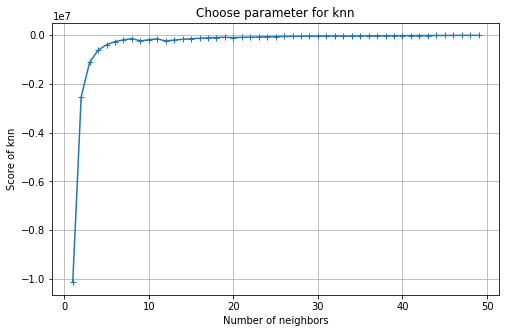

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -23793.9281876
Score for generalization with KNeighborsRegressor -0.0234076573997
Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -8.386391e+05 -8.388892e+05 -8.385950e+05
huber                       -1.772194e-02 -1.772838e-02 -1.772043e-02
epsilon_insensitive         -1.153570e-02 -1.164782e-02 -1.152737e-02
squared_epsilon_insensitive -1.017605e+06 -1.017735e+06 -1.017583e+06
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0115273666827
Score for generalization with Stochastic Gradient Descent Regressor  -0.00398072214341
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-14551200.701395903, -9989.8387785608193, -12.882367466065187]
Parameters :  {'sol

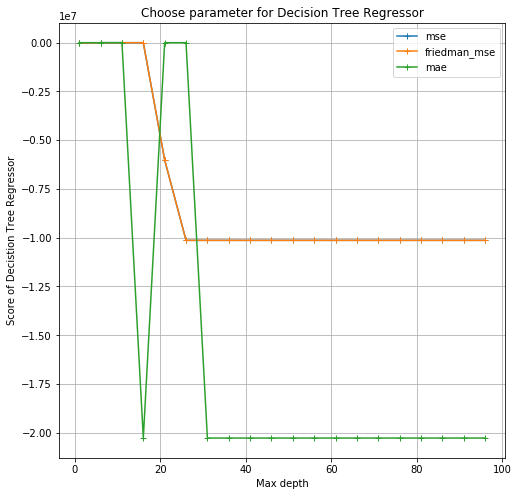

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0199665734333
Score for generalization with Descision Tree Regression -0.00398001319355
Max depth : 1
Number of estimators : 6


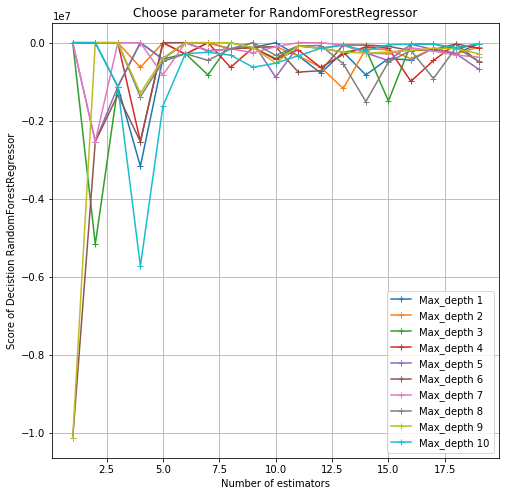

Parameters :  {'max_features': 'auto', 'max_depth': 1, 'n_estimators': 6}
Score cross validation with Random Forest Regressor -1126280.12038
Score for generalization with Random Forest Regressor -0.00394502326418
For regressor :  Drama
Score for the different regressors 
                                           Score
Linear Regression                      -0.653431
KNeighborsRegressor                    -0.023408
Stochastic Gradient Descent Regressor  -0.003981
Multi Layer Perceptron Regressor       -0.003053
Descision Tree Regression              -0.003980
Random Forest Regressor                -0.003945
Support Vector Regressor               -0.003981


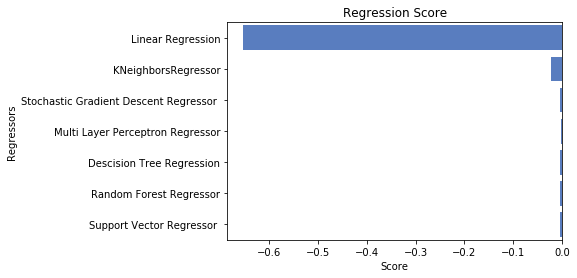

Comedy


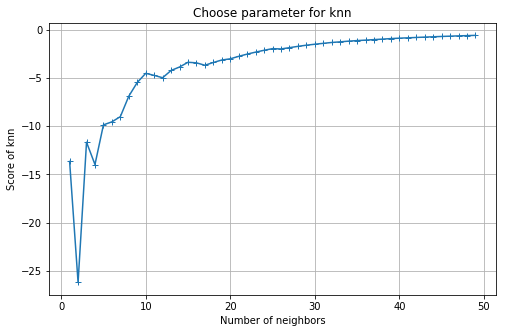

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -0.598259811813
Score for generalization with KNeighborsRegressor -0.00612079703607
Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -6.487152e+06 -6.491709e+06 -6.486348e+06
huber                       -5.295312e-02 -5.299009e-02 -5.294625e-02
epsilon_insensitive         -2.346570e-02 -2.345668e-02 -2.388146e-02
squared_epsilon_insensitive -7.332761e+06 -7.335017e+06 -7.332364e+06
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0234566828327
Score for generalization with Stochastic Gradient Descent Regressor  -0.00614084935098
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-163.02723923686128, -93076.478332218918, -56.88204409575296]
Parameters :  {'so

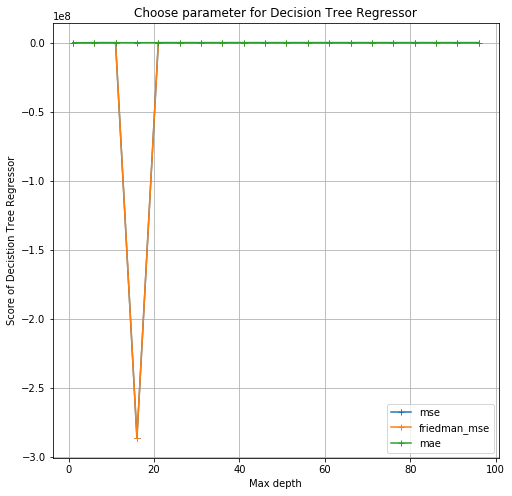

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0376489143594
Score for generalization with Descision Tree Regression -0.00614060423633
Max depth : 8
Number of estimators : 1


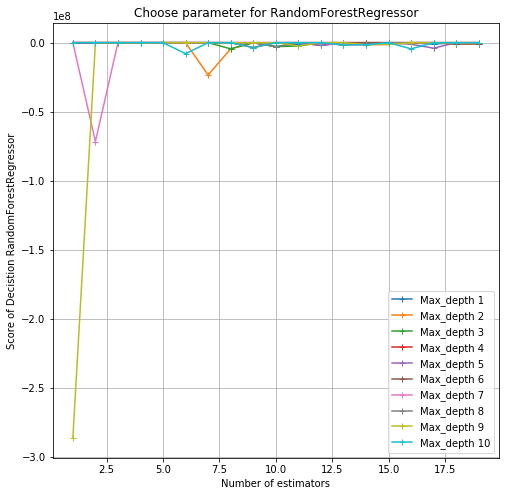

Parameters :  {'max_features': 'auto', 'max_depth': 8, 'n_estimators': 1}
Score cross validation with Random Forest Regressor -104.419517178
Score for generalization with Random Forest Regressor -0.00614074882336
For regressor :  Comedy
Score for the different regressors 
                                           Score
Linear Regression                      -0.017489
KNeighborsRegressor                    -0.006121
Stochastic Gradient Descent Regressor  -0.006141
Multi Layer Perceptron Regressor       -0.006079
Descision Tree Regression              -0.006141
Random Forest Regressor                -0.006141
Support Vector Regressor               -0.006141


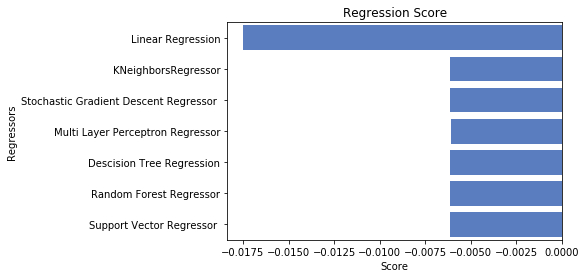

Thriller


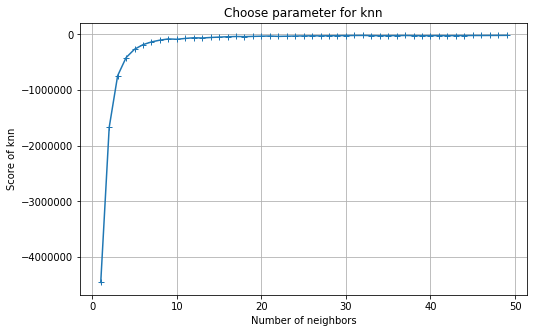

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -18546.2293882
Score for generalization with KNeighborsRegressor -1554541.02368
Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -24857.209171 -24897.630177 -24850.099881
huber                           -0.047441     -0.047463     -0.047437
epsilon_insensitive             -0.029704     -0.029447     -0.029724
squared_epsilon_insensitive -27871.484411 -27892.134434 -27867.846320
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0294466111941
Score for generalization with Stochastic Gradient Descent Regressor  -0.0302193830441
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-5.0194965054751277, -1176.6803123812103, -3.1009430348943612]
Parameters :  {'solver

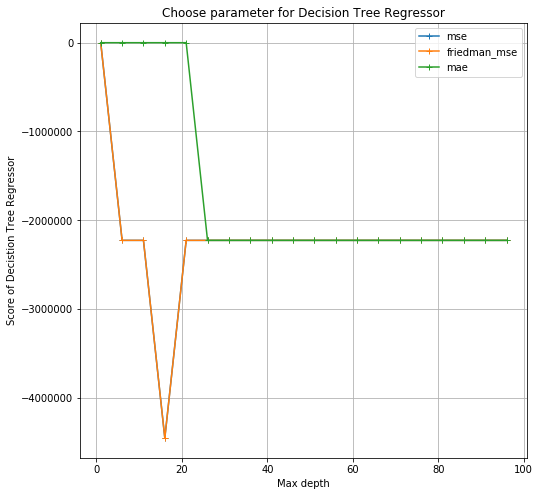

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0389430536151
Score for generalization with Descision Tree Regression -0.0833956568697
Max depth : 3
Number of estimators : 1


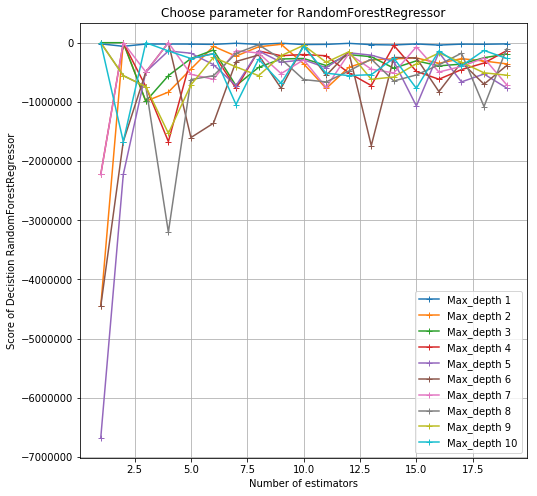

Parameters :  {'max_features': 'auto', 'max_depth': 3, 'n_estimators': 1}
Score cross validation with Random Forest Regressor -2226480.57194
Score for generalization with Random Forest Regressor -41.2801636051
For regressor :  Thriller
Score for the different regressors 
                                               Score
Linear Regression                      -1.789074e+06
KNeighborsRegressor                    -1.554541e+06
Stochastic Gradient Descent Regressor  -3.021938e-02
Multi Layer Perceptron Regressor       -4.549591e+02
Descision Tree Regression              -8.339566e-02
Random Forest Regressor                -4.128016e+01
Support Vector Regressor               -4.084108e-02


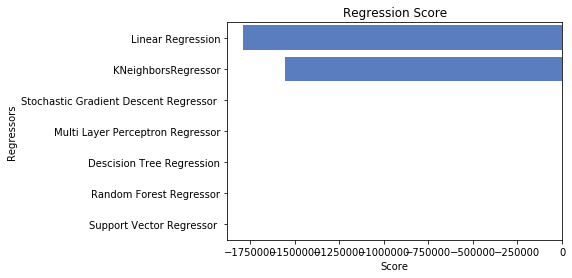

Action


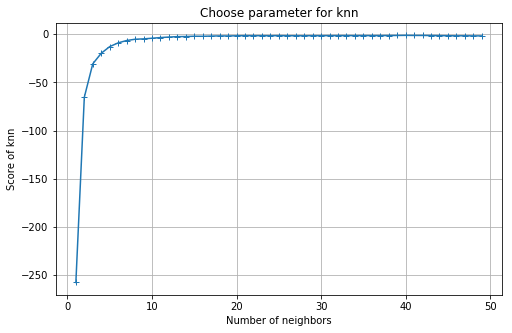

Parameters :  {'n_neighbors': 40, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -1.13161755123
Score for generalization with KNeighborsRegressor -0.00269827043671
Score for different parameters : 
                             elasticnet          l1          l2
squared_loss                -110.566793 -110.619846 -110.559619
huber                         -0.051918   -0.051944   -0.051914
epsilon_insensitive           -0.071215   -0.064201   -0.071120
squared_epsilon_insensitive -134.884119 -134.891989 -134.882723
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'huber', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0519142764753
Score for generalization with Stochastic Gradient Descent Regressor  -0.0101927616925
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-258.4054844660206, -180.90957017030607, -10.234471959719636]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate

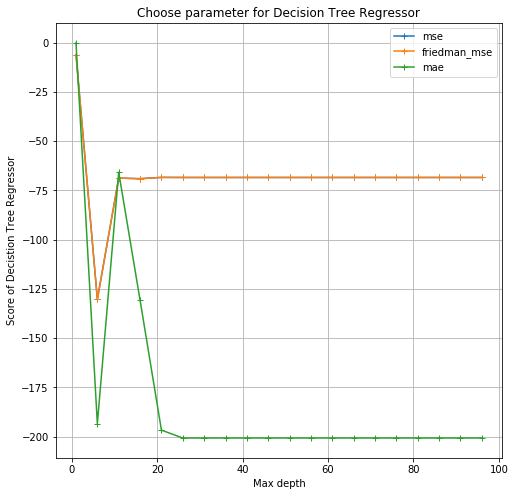

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0629870179015
Score for generalization with Descision Tree Regression -0.0111356495369
Max depth : 6
Number of estimators : 1


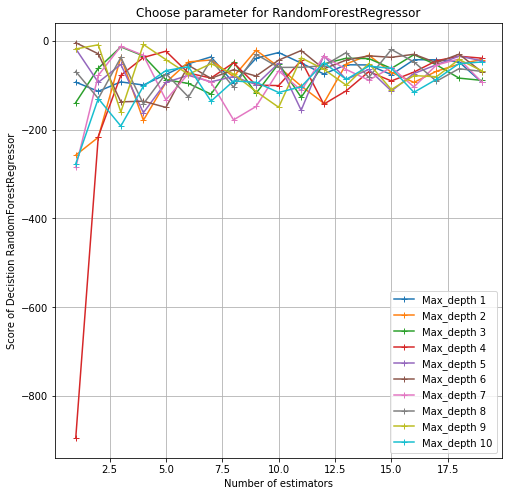

Parameters :  {'max_features': 'auto', 'max_depth': 6, 'n_estimators': 1}
Score cross validation with Random Forest Regressor -76.4145970728
Score for generalization with Random Forest Regressor 0.287456697647
For regressor :  Action
Score for the different regressors 
                                           Score
Linear Regression                      -0.519143
KNeighborsRegressor                    -0.002698
Stochastic Gradient Descent Regressor  -0.010193
Multi Layer Perceptron Regressor       -0.140867
Descision Tree Regression              -0.011136
Random Forest Regressor                 0.287457
Support Vector Regressor               -0.005951


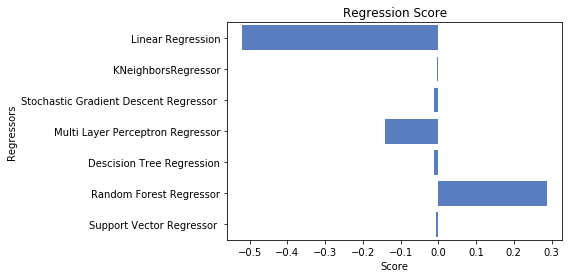

Adventure


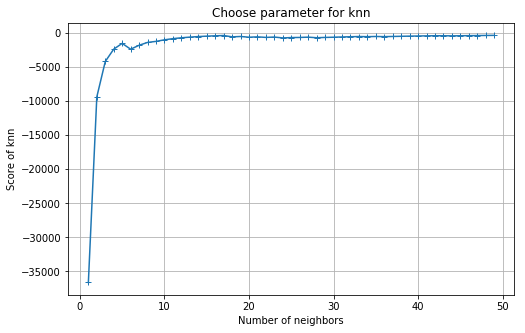

Parameters :  {'n_neighbors': 49, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -321.866634988
Score for generalization with KNeighborsRegressor -0.576420905201
Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -11263.150614 -11266.930539 -11262.483951
huber                           -0.074891     -0.074912     -0.074887
epsilon_insensitive             -0.009032     -0.008173     -0.007042
squared_epsilon_insensitive -10854.533620 -10856.295207 -10854.222759
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l2', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.00704207850844
Score for generalization with Stochastic Gradient Descent Regressor  -0.0129129626811
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-47002.477335202595, -0.15328394651075858, -48.072533395682633]
Parameters :  {'sol

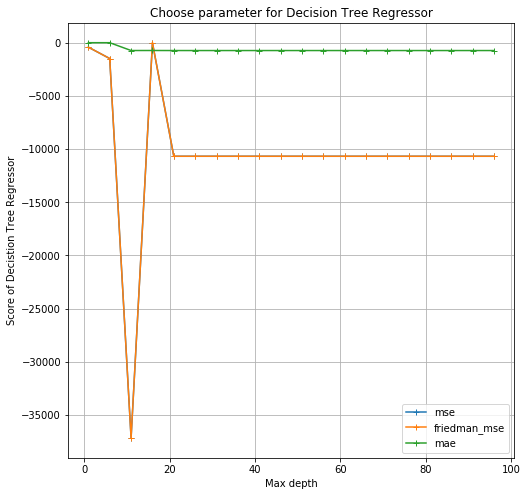

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0562791247462
Score for generalization with Descision Tree Regression -0.0151842667837
Max depth : 9
Number of estimators : 1


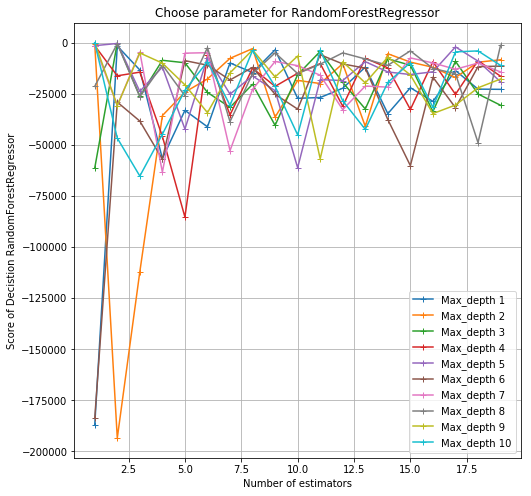

Parameters :  {'max_features': 'auto', 'max_depth': 9, 'n_estimators': 1}
Score cross validation with Random Forest Regressor -31962.9691453
Score for generalization with Random Forest Regressor 0.0877951785438
For regressor :  Adventure
Score for the different regressors 
                                           Score
Linear Regression                      -5.605632
KNeighborsRegressor                    -0.576421
Stochastic Gradient Descent Regressor  -0.012913
Multi Layer Perceptron Regressor       -0.021225
Descision Tree Regression              -0.015184
Random Forest Regressor                 0.087795
Support Vector Regressor               -0.009138


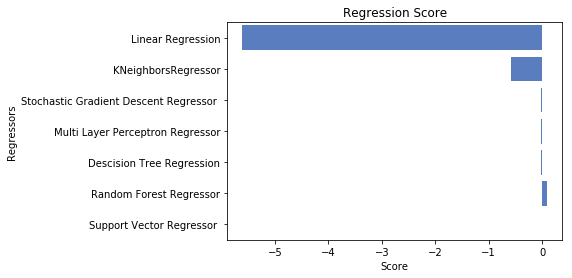

Romance


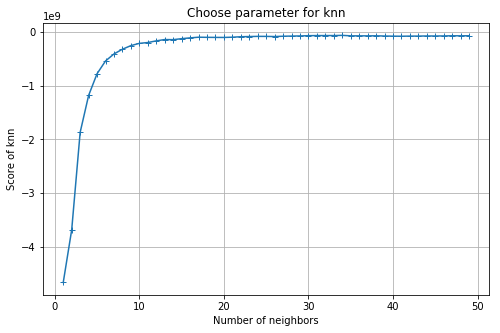

Parameters :  {'n_neighbors': 34, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -61823218.771
Score for generalization with KNeighborsRegressor -1297859.12234
Score for different parameters : 
                               elasticnet            l1            l2
squared_loss                -1.401228e+09 -1.401977e+09 -1.401096e+09
huber                       -6.820619e-02 -6.824481e-02 -6.819901e-02
epsilon_insensitive         -3.125038e-03 -2.775386e-03 -4.626708e-03
squared_epsilon_insensitive -1.428650e+09 -1.429125e+09 -1.428566e+09
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.00277538553178
Score for generalization with Stochastic Gradient Descent Regressor  -0.0282503678822
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-26761803528.475456, -31885357.690891188, -6.95431376448599]
Parameters :  {'solver':

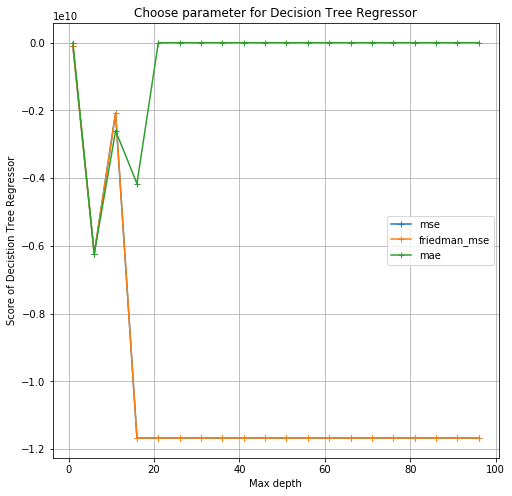

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0571786864154
Score for generalization with Descision Tree Regression -0.0351088438168
Max depth : 10
Number of estimators : 1


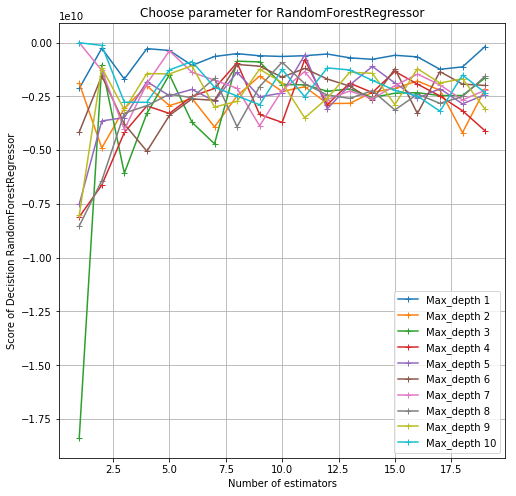

Parameters :  {'max_features': 'auto', 'max_depth': 10, 'n_estimators': 1}
Score cross validation with Random Forest Regressor -8609726737.97
Score for generalization with Random Forest Regressor -599824338.848
For regressor :  Romance
Score for the different regressors 
                                               Score
Linear Regression                      -4.594067e+06
KNeighborsRegressor                    -1.297859e+06
Stochastic Gradient Descent Regressor  -2.825037e-02
Multi Layer Perceptron Regressor       -2.096533e+00
Descision Tree Regression              -3.510884e-02
Random Forest Regressor                -5.998243e+08
Support Vector Regressor               -2.798712e-02


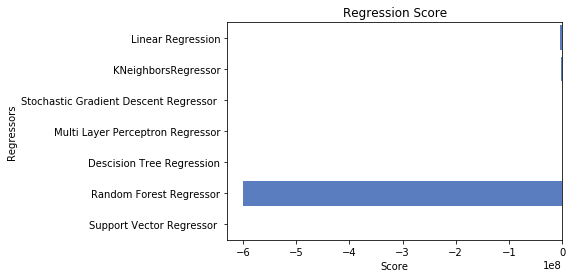

Crime


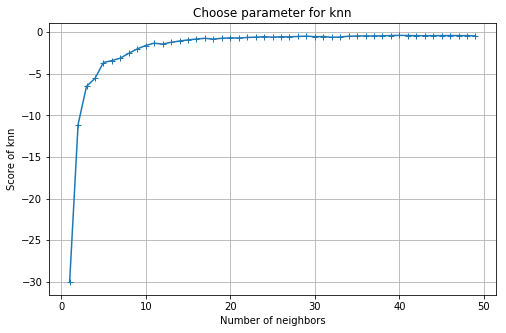

Parameters :  {'n_neighbors': 40, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -0.378329803439
Score for generalization with KNeighborsRegressor 0.0193097247989
Score for different parameters : 
                             elasticnet         l1         l2
squared_loss                 -11.505286 -11.516730 -11.501563
huber                         -0.101014  -0.100916  -0.101024
epsilon_insensitive           -0.011311  -0.010576  -0.011094
squared_epsilon_insensitive  -12.760293 -12.770213 -12.758502
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.0105755246775
Score for generalization with Stochastic Gradient Descent Regressor  -0.0310969699142
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-46.168969442274722, -38.749950918270727, -1.0038956471374991]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_

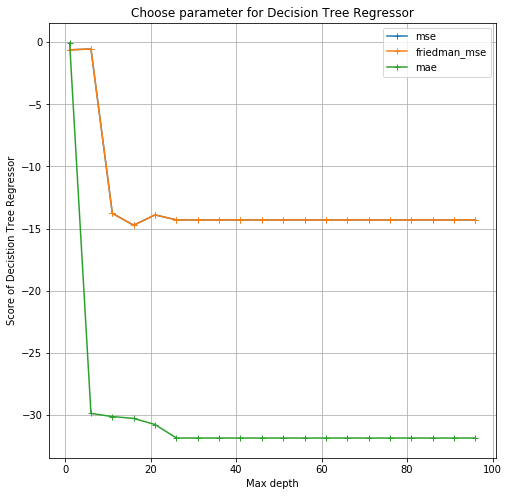

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0514414090522
Score for generalization with Descision Tree Regression -0.0354564519326
Max depth : 1
Number of estimators : 1


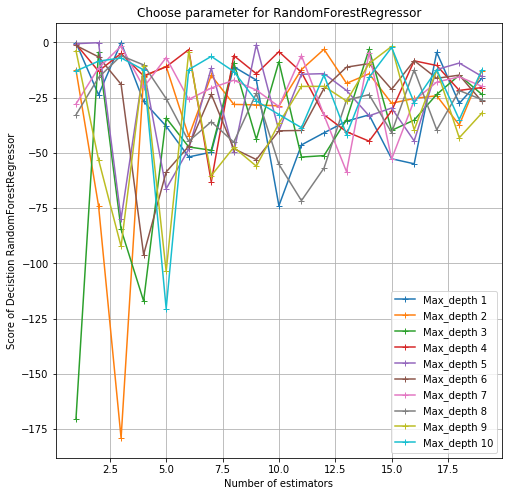

Parameters :  {'max_features': 'auto', 'max_depth': 1, 'n_estimators': 1}
Score cross validation with Random Forest Regressor -199.895568021
Score for generalization with Random Forest Regressor 0.0405853027177
For regressor :  Crime
Score for the different regressors 
                                           Score
Linear Regression                       0.010667
KNeighborsRegressor                     0.019310
Stochastic Gradient Descent Regressor  -0.031097
Multi Layer Perceptron Regressor       -0.006606
Descision Tree Regression              -0.035456
Random Forest Regressor                 0.040585
Support Vector Regressor               -0.030516


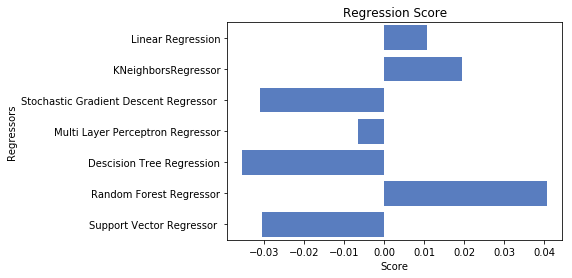

Science Fiction


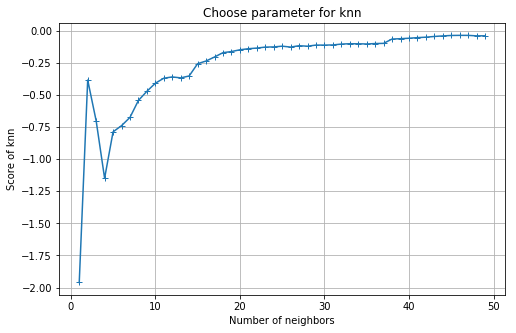

Parameters :  {'n_neighbors': 46, 'algorithm': 'auto'}
Score cross validation with KNeighborsRegressor -0.0354048814456
Score for generalization with KNeighborsRegressor -0.0990929849
Score for different parameters : 
                             elasticnet        l1        l2
squared_loss                  -1.060481 -1.060475 -1.060482
huber                         -0.124549 -0.124485 -0.124560
epsilon_insensitive           -0.049405 -0.048302 -0.049296
squared_epsilon_insensitive   -1.354540 -1.355105 -1.354500
Parameters :  {'random_state': 1, 'shuffle': False, 'loss': 'epsilon_insensitive', 'penalty': 'l1', 'max_iter': 1000}
Score cross validation with Stochastic Gradient Descent Regressor  -0.048302079729
Score for generalization with Stochastic Gradient Descent Regressor  -0.0200291553469
Score for the following solver :  ['lbfgs', 'sgd', 'adam'] [-40.253262658911538, -0.92737569537065423, -0.24524156281972637]
Parameters :  {'solver': 'adam', 'shuffle': True, 'learning_rate': 'co

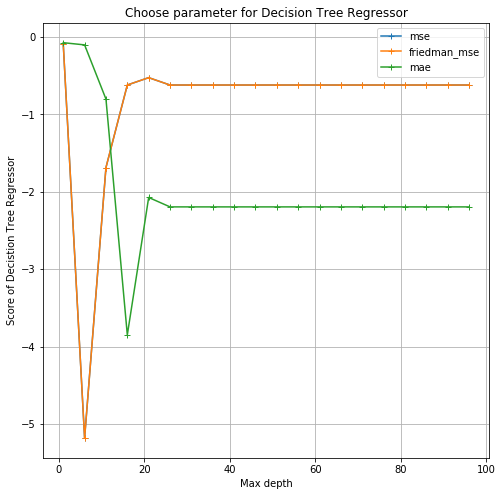

Parameters :  {'criterion': 'mae', 'max_features': 'log2', 'max_depth': 1, 'random_state': 1}
Score cross validation with Descision Tree Regression -0.0751500034401
Score for generalization with Descision Tree Regression -0.0503009000111
Max depth : 2
Number of estimators : 1


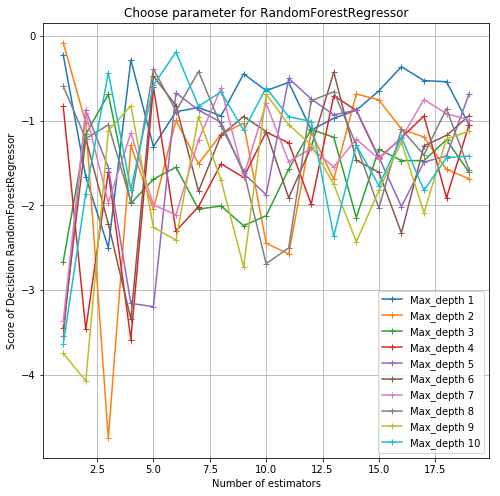

Parameters :  {'max_features': 'auto', 'max_depth': 2, 'n_estimators': 1}
Score cross validation with Random Forest Regressor -0.944085674066
Score for generalization with Random Forest Regressor -0.0854768629009
For regressor :  Science Fiction
Score for the different regressors 
                                           Score
Linear Regression                      -0.255463
KNeighborsRegressor                    -0.099093
Stochastic Gradient Descent Regressor  -0.020029
Multi Layer Perceptron Regressor       -0.209596
Descision Tree Regression              -0.050301
Random Forest Regressor                -0.085477
Support Vector Regressor               -0.019757


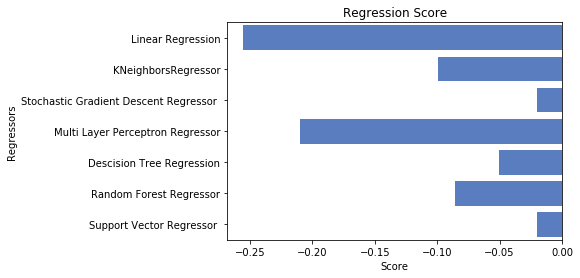

In [305]:
answer_ratio, regressors_ratio_genre = compare_genre_regression_ratio(liste_genres, dataset_genre)

In [306]:
plot_graph_genre(regressors_ratio_genre,liste_genres)

                                         Regressor used     Score
Drama                  Multi Layer Perceptron Regressor -0.003053
Comedy                 Multi Layer Perceptron Regressor -0.006079
Thriller         Stochastic Gradient Descent Regressor  -0.030219
Action                          Random Forest Regressor  0.287457
Adventure                       Random Forest Regressor  0.087795
Romance                       Support Vector Regressor  -0.027987
Crime                           Random Forest Regressor  0.040585
Science Fiction               Support Vector Regressor  -0.019757


<div class="alert alert-success">
Classification
</div>



In [307]:
# Create the instance of the Dataset class in order to normalize, split and remove features
dataset_all_c = Dataset(pre_process)
# Discretizes the grade into 100 labels
dataset_all_c.discretize(0)
# Splits the set into training and testing sets
dataset_all_c.set_sets()
# Normalization of the input
dataset_all_c.normalize()


In [308]:
# Gets the train and testing sets
X_train_g_100, X_test_g_100 , y_train_g_100, y_test_g_100 = dataset_all_c.get_grade_data(0)

In [309]:

# Class to do Classification and to vizualise it easily
class Classifications :
    def __init__(self,X_train, y_train, X_test, y_test ) :
        # Name of the classifiers used
        self.classificators_name = ['LDA','LogisticRegression','Perceptron',\
                   'SVC','Decision Trees','RandomForestClassifier','AdaBoostClassifier']
        # Input training set
        self.X_train = X_train
        # Output training set
        self.y_train = y_train
        # Input testing set
        self.X_test = X_test
        # Output testing set
        self.y_test = y_test
        # List of the parameters
        self.list_param = [0 for i in range (len(self.classificators_name)) ]
        # List of the accuracy on the testing set
        self.list_score = np.zeros((1,len(self.classificators_name)))[0]
        # List of the accuracy after cross validation
        self.liste_oof_score = np.zeros((1,len(self.classificators_name)))[0]
        # List of classifiers
        self.classifiers = [0 for i in range (len(self.classificators_name)) ]
        # List of the functions used to get the best parameters for the classifiers
        self.functions = [None for i in range(len(self.classificators_name))]
        
    def get_oof_score(self,index) :
        # Gets the accuracy after cross validation of a given classifier
        # index gives the number of the classifier in the name list
        clfr = SKlearnHelper(clf= self.classifiers[index], params = self.list_param[index]) 
        oof_score = get_oof_c(clfr, self.X_train,self.y_train)
        self.liste_oof_score[index] = oof_score
        return oof_score
    
    def get_score(self, index) :
        # Gets the accuracy of a given classifier
        clfr = SKlearnHelper(clf= self.classifiers[index], params = self.list_param[index]) 
        score = get_score_c(clfr,self.X_train,self.y_train,self.X_test,self.y_test) 
        self.list_score[index] = score
        return score
    
    def set_classifier(self, index, clf) :
        # Sets the classifier at a given position
        self.classifiers[index] = clf
    
    def set_param(self, index, param) :
        # Sets the parameters for a given classifier
        self.list_param[index] = param
        if (self.classifiers[index] is not None ):
            self.get_oof_score(index)
            self.get_score(index)
    
    def print_classifier_scores(self, index) :
        # Prints the accuracy on the training and testing set
        if (self.list_score[index] == 0 or self.liste_oof_score[index] == 0) :
            self.get_oof_score(index)
            self.get_score(index)    
        print("Score cross validation with " + self.classificators_name[index], self.liste_oof_score[index])
        print("Score for generalization with "+ self.classificators_name[index], self.list_score[index])
        
    def set_function(self, index, func) :
        # Sets the function to get the best parameters for a given classifier
        self.functions[index] = func
     
    def function(self,index) :
        # Gets the best parameters for a given classifier
        if self.functions[index] is not None :
            param,clf = self.functions[index](self.X_train, self.y_train, True)
            self.set_param(index,param)
            self.set_classifier(index, clf)
            print("Parameters : ",param)
            
    def set_regressors(self, liste_regressor) :
        # Sets the classifier to the given position 
        for index, x in enumerate(liste_regressor) :
            self.set_classifier(index, x)
        
    def set_functions(self,liste_function):
        # Sets the function to a given classifier        
        for index, x in enumerate(liste_function) :
            self.set_function(index, x)
            
    def print_all_score(self) :
        # Prints all the accuracy for all the different classifiers
        print("Score for the different classifiers ")
        score_regressors = {}
        score_regressors['Score'] = self.list_score
        score_class_df = pd.DataFrame(score_regressors, index =self.classificators_name)        
        print(score_class_df)        
        sns.set_color_codes("muted")
        score_class_df['Classifiers'] = self.classificators_name
        sns.barplot(x='Score', y='Classifiers', data=score_class_df, color="b")
        plt.xlabel('Score')
        plt.title('Regression Score')
        plt.show()

    def plot_prediction(self,name) :
        # It takes the model that maximizes the accuracy 
        index = np.argmax(self.list_score)
        clf = self.classifiers[index]
        print("Regressor chosen :",self.classificators_name[index])
        params = self.list_param[index]
        classifier = SKlearnHelper(clf=clf, params = params)
        classifier.fit(self.X_train, self.y_train)
        y_predict = classifier.predict(self.X_test)
        f, ax = plt.subplots(figsize=(8, 8))
        plt.scatter([i for i in range(len(y_predict))] ,y_predict, color='b', label="Prediction",\
                   marker='+')
        plt.scatter([i for i in range(len(y_predict))],self.y_test,color='r',label="Real Value",\
                    marker='+')
        plt.xlabel("Number of instance")
        plt.ylabel(name)
        plt.title("Comparaison of the model with the real values")
        plt.legend()
        plt.show()

    def print_best_classifier(self) :
        # It will prints the best classifiers (for the training set) and 
        # returns its accuracy with the testing set
        index = np.argmax(self.liste_oof_score)
        answer = "Best regressor : " + str(self.classificators_name[index]) +\
        " for a score : " + str(self.list_score[index])
        return answer
        
       
        
            
        
        
            

<div class="alert alert-success">
Grade discretized as 100 labels
</div>



In [310]:
# Classifier instance that will be used to train our model on our data
# We take the grade with 100 label as output
classifier_100 = Classifications(X_train_g_100, y_train_g_100, X_test_g_100 , y_test_g_100)

In [311]:
# Declaration of the functions and classifiers that we'r going to use 
liste_function_classifier = [get_lda , get_lreg, get_perc ,get_mlpc, get_svm,get_dtc ,\
                            get_rfc, get_ada]
liste_classifiers = [LinearDiscriminantAnalysis, LogisticRegression,Perceptron, MLPClassifier,\
                    SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier]



In [312]:
# Sets the functions and classifier to our instance 
classifier_100.set_functions(liste_function_classifier)
classifier_100.set_regressors(liste_classifiers)

* Linear Discriminant Analysis

In [313]:
# Fits the data with the best parameters and then it retunrs the score for LDA
classifier_100.function(0)
classifier_100.print_classifier_scores(0)

Solver chosen :  lsqr
Score after cross validation for LDA  0.114438502674
Parameters :  {'solver': 'lsqr'}
Score cross validation with LDA 0.114438502674
Score for generalization with LDA 0.118584070796


* Logistic Regression

In [314]:
# Fits the data with the best parameters and then it retunrs the score for Logistic Regression
classifier_100.function(1)
classifier_100.print_classifier_scores(1)

Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0754010695187
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.0754010695187
Score for generalization with LogisticRegression 0.0991150442478


* Perceptron

In [315]:
# Fits the data with the best parameters and then it retunrs the score for Perceptron
classifier_100.function(2)
classifier_100.print_classifier_scores(2)

Penalty chosen :  l2
Score after cross validation for Perceptron 0.0401069518717
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.0401069518717
Score for generalization with Perceptron 0.0389380530973


* Multi Layer Perceptron Classifier

In [316]:
# Fits the data with the best parameters and then it retunrs the score for MLPC
classifier_100.function(3)
classifier_100.print_classifier_scores(3)

Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.048128342246
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.048128342246
Score for generalization with MLPClassifier 0.0725663716814


* Support Vector Machine Classifier

In [317]:
# Fits the data with the best parameters and then it retunrs the score for SVMC
classifier_100.function(4)
classifier_100.print_classifier_scores(4)

Kernel used :  sigmoid
Score after cross validation for SVM 0.0641711229947
Parameters :  {'gamma': 'auto', 'kernel': 'sigmoid', 'random_state': 1}
Score cross validation with SVC 0.0641711229947
Score for generalization with SVC 0.111504424779


* Decision Trees


In [318]:
# Fits the data with the best parameters and then it retunrs the score for Decision Trees
classifier_100.function(5)
classifier_100.print_classifier_scores(5)

Max depth chosen :  18
Score after cross validation for Decision Tree 0.0967914438503
Parameters :  {'max_features': 'auto', 'max_depth': 18, 'random_state': 1, 'splitter': 'best'}
Score cross validation with Decision Trees 0.0967914438503
Score for generalization with Decision Trees 0.109734513274


* Random Forest Classifier

Score after cross validation for Random Forest 0.134759358289


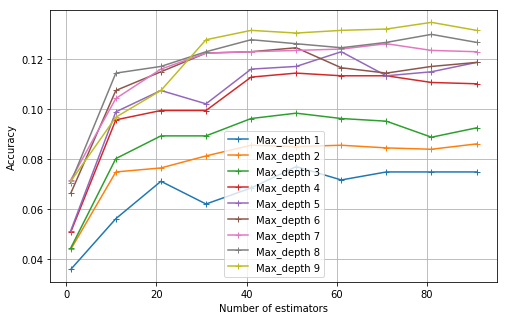

Number of estimators :  40
Max depth :  9
Parameters :  {'random_state': 1, 'max_depth': 9, 'n_estimators': 40}
Score cross validation with RandomForestClassifier 0.128342245989
Score for generalization with RandomForestClassifier 0.130973451327


In [319]:
# Fits the data with the best parameters and then it retunrs the score for Random Forest Classifier
classifier_100.function(6)
classifier_100.print_classifier_scores(6)

* AdaBoost Classifier

In [320]:
# Fits the data with the best parameters and then it retunrs the score for Adaboost Classifier
classifier_100.function(7)
classifier_100.print_classifier_scores(7)

Number of estimators :  21
Score after cross validation for Adaboost 0.118181818182
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 21}
Score cross validation with AdaBoostClassifier 0.118181818182
Score for generalization with AdaBoostClassifier 0.0991150442478


Score for the different classifiers 
                           Score
LDA                     0.118584
LogisticRegression      0.099115
Perceptron              0.038938
MLPClassifier           0.072566
SVC                     0.111504
Decision Trees          0.109735
RandomForestClassifier  0.130973
AdaBoostClassifier      0.099115


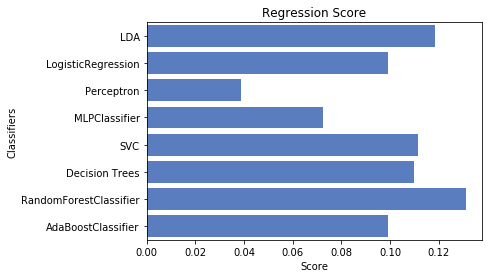

In [321]:
# Prints the result and summarize it 
classifier_100.print_all_score()

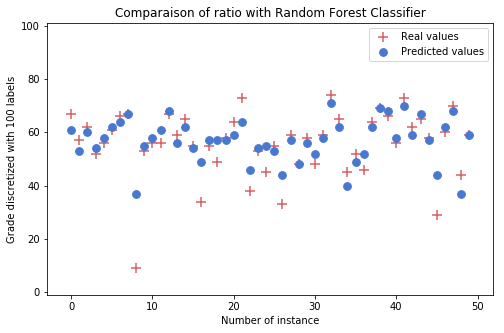

In [322]:
# Plots the 50 first instances of the testing set with the real output and the predicted one 
plot_predict_real(classifier_100, 50, "Grade discretized with 100 labels", \
                  "Random Forest Classifier", [-1,101],6)

<div class="alert alert-success">
Grade discretized as 20 labels
</div>



In [323]:
# Creation of Dataset instance
dataset_all_c_20 = Dataset(pre_process)
# Discretize as 20 labels
dataset_all_c_20.discretize(1)
# Spits it into train and test sets
dataset_all_c_20.set_sets()
# Normalization
dataset_all_c_20.normalize()


In [324]:
# Splits it into training and testing sets
X_train_g_20, X_test_g_20 , y_train_g_20, y_test_g_20 = dataset_all_c_20.get_grade_data(0)

In [325]:
# Creation of Classifier instance
classifier_20 = Classifications(X_train_g_20, y_train_g_20, X_test_g_20 , y_test_g_20)
# Sets the function to get the best parameters
classifier_20.set_functions(liste_function_classifier)
# Sets the classifiers that we're going to use
classifier_20.set_regressors(liste_classifiers)



* Linear Discriminant Analysis


In [326]:
# Fits the data with the best parameters and then it retunrs the score for LDA
classifier_20.function(0)
classifier_20.print_classifier_scores(0)


Solver chosen :  lsqr
Score after cross validation for LDA  0.540106951872
Parameters :  {'solver': 'lsqr'}
Score cross validation with LDA 0.540106951872
Score for generalization with LDA 0.566371681416



* Logistic Regression

In [327]:
# Fits the data with the best parameters and then it retunrs the score for Logistic Regression
classifier_20.function(1)
classifier_20.print_classifier_scores(1)


Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.477005347594
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.477005347594
Score for generalization with LogisticRegression 0.552212389381


* Perceptron

In [328]:
# Fits the data with the best parameters and then it retunrs the score for Perceptron
classifier_20.function(2)
classifier_20.print_classifier_scores(2)


Penalty chosen :  l2
Score after cross validation for Perceptron 0.21871657754
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.21871657754
Score for generalization with Perceptron 0.214159292035


* Multi Layer Perceptron Classifier


In [329]:
# Fits the data with the best parameters and then it retunrs the score for MLPC
classifier_20.function(3)
classifier_20.print_classifier_scores(3)


Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.280213903743
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.280213903743
Score for generalization with MLPClassifier 0.313274336283


* Support Vector Machine Classifier


In [330]:
# Fits the data with the best parameters and then it retunrs the score for SVMC
classifier_20.function(4)
classifier_20.print_classifier_scores(4)


Kernel used :  sigmoid
Score after cross validation for SVM 0.460427807487
Parameters :  {'gamma': 'auto', 'kernel': 'sigmoid', 'random_state': 1}
Score cross validation with SVC 0.460427807487
Score for generalization with SVC 0.518584070796



* Decision Trees

In [331]:
# Fits the data with the best parameters and then it retunrs the score for Decision Trees
classifier_20.function(5)
classifier_20.print_classifier_scores(5)


Max depth chosen :  19
Score after cross validation for Decision Tree 0.409625668449
Parameters :  {'max_features': 'auto', 'max_depth': 19, 'random_state': 1, 'splitter': 'best'}
Score cross validation with Decision Trees 0.409625668449
Score for generalization with Decision Trees 0.4


* Random Forest Classifier


Score after cross validation for Random Forest 0.573262032086


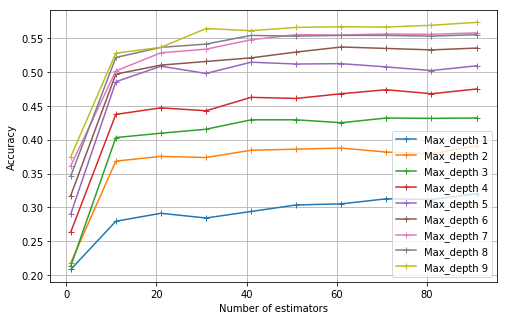

Number of estimators :  40
Max depth :  9
Parameters :  {'random_state': 1, 'max_depth': 9, 'n_estimators': 40}


In [332]:
# Fits the data with the best parameters and then it retunrs the score for Random Forest Classifier
classifier_20.function(6)

In [333]:
# Prints the results
classifier_20.print_classifier_scores(6)

Score cross validation with RandomForestClassifier 0.560427807487
Score for generalization with RandomForestClassifier 0.504424778761



* AdaBoost Classifier

In [334]:
# Fits the data with the best parameters and then it retunrs the score for Adaboost Classifier
classifier_20.function(7)
classifier_20.print_classifier_scores(7)


Number of estimators :  61
Score after cross validation for Adaboost 0.473262032086
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 61}
Score cross validation with AdaBoostClassifier 0.473262032086
Score for generalization with AdaBoostClassifier 0.426548672566


Score for the different classifiers 
                           Score
LDA                     0.566372
LogisticRegression      0.552212
Perceptron              0.214159
MLPClassifier           0.313274
SVC                     0.518584
Decision Trees          0.400000
RandomForestClassifier  0.504425
AdaBoostClassifier      0.426549


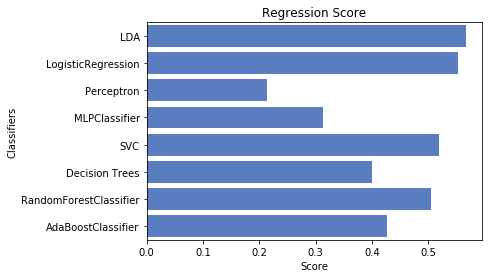

In [335]:
# Prints the result and summarize it 
classifier_20.print_all_score()

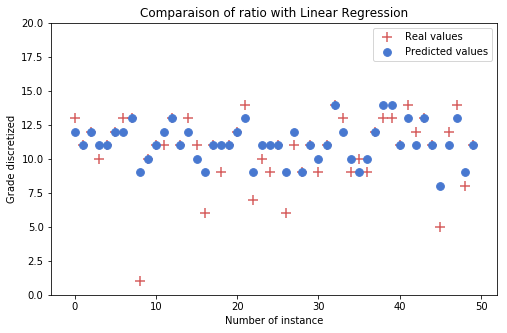

In [336]:
# Plots the 50 first instances of the testing set with the real output and the predicted one
plot_predict_real(classifier_20, 50, "Grade discretized", "Linear Regression", [0,20],-2)

<div class="alert alert-success">
Revenue discretized as 3 labels
</div>



In [337]:
# Creation of Dataset instance
dataset_all_r = Dataset(pre_process)
# Discretizes the revenue as 3 labels : low revenue, medium revenue and high revenue
dataset_all_r.discretize_revenue()
# Splits to train and test sets
dataset_all_r.set_sets()
# Normalization of the inputs
dataset_all_r.normalize()


In [338]:
# Creation of our training and testing subsets
X_train_c_r, X_test_c_r , y_train_c_r, y_test_c_r = dataset_all_r.get_revenue_data(0)

# Creation of a Classification instance
classifier_r = Classifications(X_train_c_r, y_train_c_r, X_test_c_r , y_test_c_r)
# Sets the functions to get the best parameters
classifier_r.set_functions(liste_function_classifier)
# Sets the classifiers
classifier_r.set_regressors(liste_classifiers)



Solver chosen :  svd
Score after cross validation for LDA  0.653475935829
Parameters :  {'solver': 'svd'}
Score cross validation with LDA 0.653475935829
Score for generalization with LDA 0.58407079646
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.683422459893
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.683422459893
Score for generalization with LogisticRegression 0.630088495575
Penalty chosen :  l1
Score after cross validation for Perceptron 0.605347593583
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.605347593583
Score for generalization with Perceptron 0.561061946903
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.570588235294
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score 

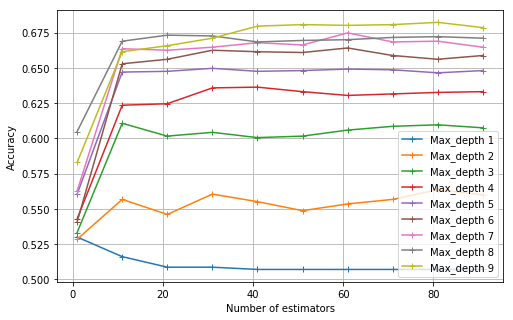

Number of estimators :  40
Max depth :  9
Parameters :  {'random_state': 1, 'max_depth': 9, 'n_estimators': 40}
Score cross validation with RandomForestClassifier 0.675401069519
Score for generalization with RandomForestClassifier 0.628318584071
Number of estimators :  91
Score after cross validation for Adaboost 0.68449197861
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 91}
Score cross validation with AdaBoostClassifier 0.68449197861
Score for generalization with AdaBoostClassifier 0.646017699115


In [339]:
# Loops through all the classifiers
for i in range(len(classifier_r.classificators_name)) :
    # Gets the best parameters through a cross validation process 
    # to get the scores with the current parameters
    classifier_r.function(i)
    # Pritns the accuracy of the classifiers
    classifier_r.print_classifier_scores(i)

Score for the different classifiers 
                           Score
LDA                     0.584071
LogisticRegression      0.630088
Perceptron              0.561062
MLPClassifier           0.628319
SVC                     0.596460
Decision Trees          0.530973
RandomForestClassifier  0.628319
AdaBoostClassifier      0.646018


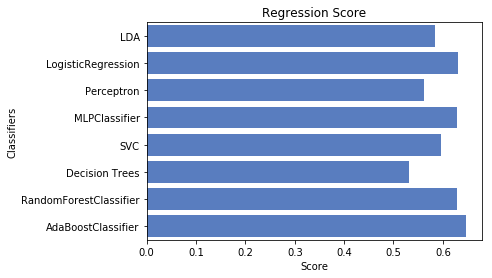

In [340]:
# Plots the results of the previous process with all the accuracy of all the classifiers
classifier_r.print_all_score()

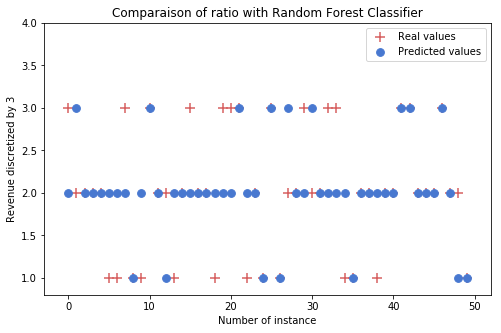

In [341]:
# Plots the 50 first instances of our testing set with the real and the predicted outputs
plot_predict_real(classifier_r, 50, "Revenue discretized by 3", "Random Forest Classifier",\
                  [0.8,4],6)

<div class="alert alert-success">
Splitting our data into genre sets
</div>



In [342]:
# Creation of an instance of Preprocess to deal with the dataset
pre_process_genre = Preprocess(data)
# Splits the dataset into 8 genres subsets
pre_process_genre.split_by_genre(8)
# Splits into train and test 
pre_process_genre.split_train_test()


['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime', 'Science Fiction']


In [343]:
# Computes the keyword_grade, crew_grade and cast_grade
pre_process_genre.compute_grade(liste_all_grade)


In [344]:
# Creation of a Dataset instance
dataset_genre = Dataset(pre_process_genre)
# Discretization into 100 labels
dataset_genre.discretize(0)
# Splits into train and test subsets
dataset_genre.set_sets()
# Normalization of the inputs
dataset_genre.normalize()


Drama


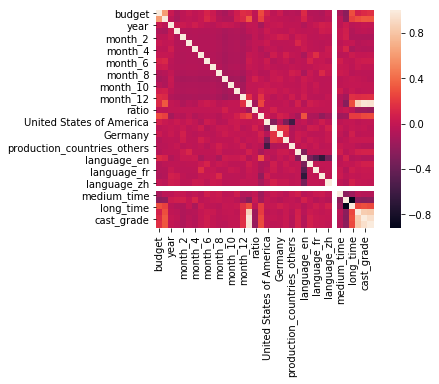

Comedy


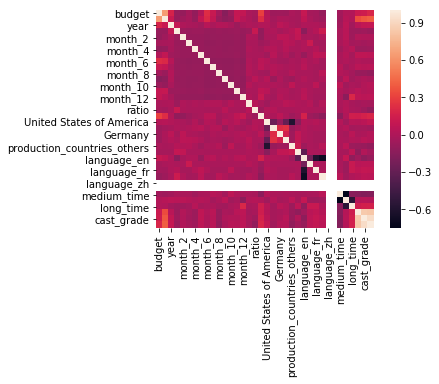

Thriller


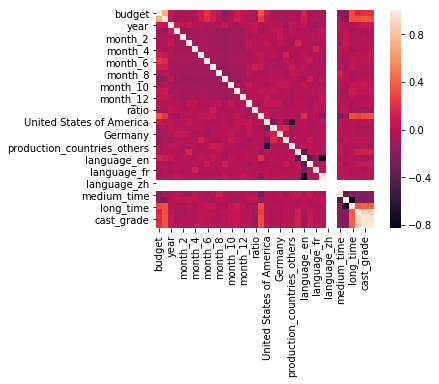

Action


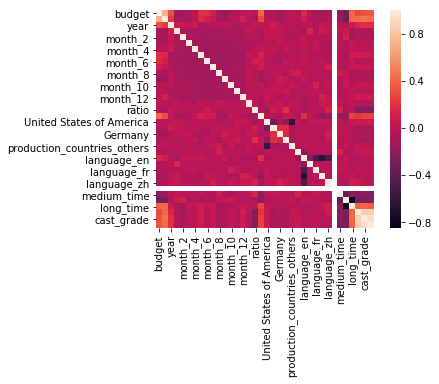

Adventure


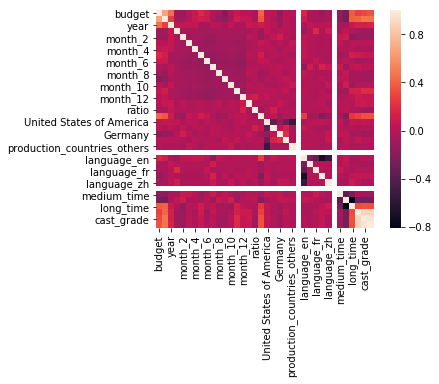

Romance


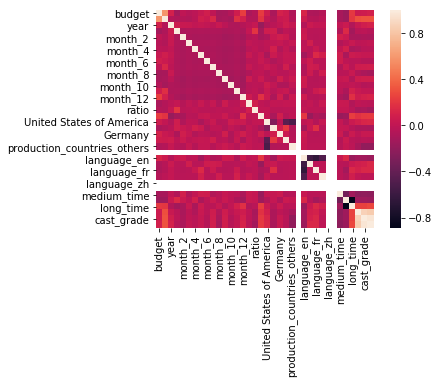

Crime


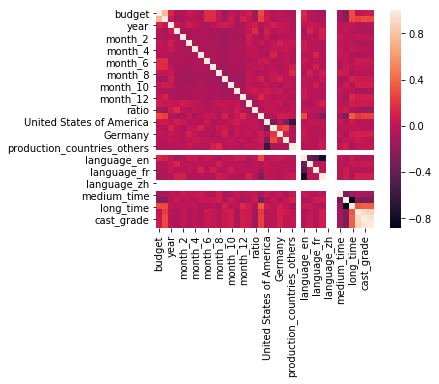

Science Fiction


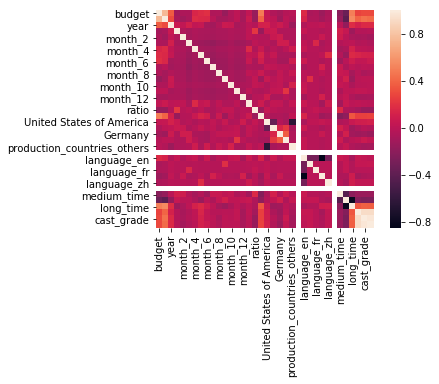

In [345]:
# List with the names of the 8 genres that we'll use
liste_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance','Crime',\
               'Science Fiction']
# List of the correlation matrixes by genre
liste_corr_genre = [dataset_genre.pre_process.train[i].corr() for i in range(len(liste_genres))] 
for index, x in enumerate(liste_corr_genre) :
    print(liste_genres[index])
    sns.heatmap(x, vmax=1, square=True)
    plt.show()

In [346]:
# Functions that we'll returns the classifiers that best fit the data
# It will also give, for each genre, the accuracy and the classifier used to get its accuracy
# It is made for grade as label
def compare_classification_genre(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_function_classifier = [get_lda , get_lreg, get_perc ,get_mlpc, get_svm,get_dtc ,\
                            get_rfc, get_ada]
    liste_classifiers = [LinearDiscriminantAnalysis, LogisticRegression,Perceptron, MLPClassifier,\
                    SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier]
    liste_class = []
    for i in range(len(liste_classifiers)) :
        X_train, X_test, y_train, y_test = dataset_genre.get_grade_data(i)    
        print(liste_genres[i])
        classifier = Classifications(X_train, y_train, X_test, y_test)
        classifier.set_regressors(liste_classifiers)
        classifier.set_functions(liste_function_classifier)
        for j in range(1,len(liste_function_classifier)) : 
            classifier.function(j)
            classifier.print_classifier_scores(j)
        print("For Classifier : ", liste_genres[i])
        classifier.print_all_score()
        liste_class.append(classifier)
        answer.append(classifier.print_best_classifier())
    return answer , liste_class



<div class="alert alert-success">
Grade as 100 different labels for the genre splits
    
</div>



Drama
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0903614457831
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.0903614457831
Score for generalization with LogisticRegression 0.0671936758893
Penalty chosen :  l2
Score after cross validation for Perceptron 0.0409638554217
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.0409638554217
Score for generalization with Perceptron 0.0316205533597
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.0457831325301
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.0457831325301
Score for generalization with MLPClassifier 0.0395256916996
Kernel used :  sigmoid
Score after cross validation for SVM 0.0638554216867


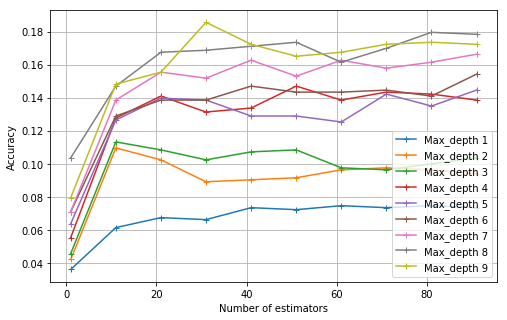

Number of estimators :  31
Max depth :  9
Parameters :  {'random_state': 1, 'max_depth': 9, 'n_estimators': 31}
Score cross validation with RandomForestClassifier 0.185542168675
Score for generalization with RandomForestClassifier 0.130434782609
Number of estimators :  91
Score after cross validation for Adaboost 0.0963855421687
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 91}
Score cross validation with AdaBoostClassifier 0.0963855421687
Score for generalization with AdaBoostClassifier 0.0592885375494
For Classifier :  Drama
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.067194
Perceptron              0.031621
MLPClassifier           0.039526
SVC                     0.067194
Decision Trees          0.083004
RandomForestClassifier  0.130435
AdaBoostClassifier      0.059289


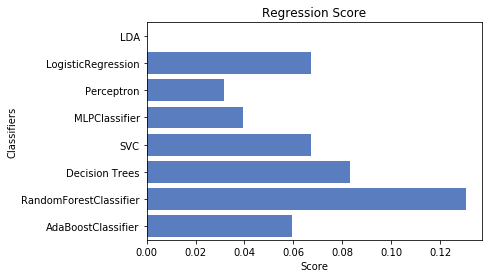

Comedy
Solver chosen :  sag
Score after cross validation for Logistic Regression  0.0335877862595
Parameters :  {'solver': 'sag', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.0335877862595
Score for generalization with LogisticRegression 0.0398009950249
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0229007633588
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0229007633588
Score for generalization with Perceptron 0.0199004975124
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.0351145038168
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.0351145038168
Score for generalization with MLPClassifier 0.0248756218905
Kernel used :  sigmoid
Score after cross validation for SVM 0.0396946564885
Parameters 

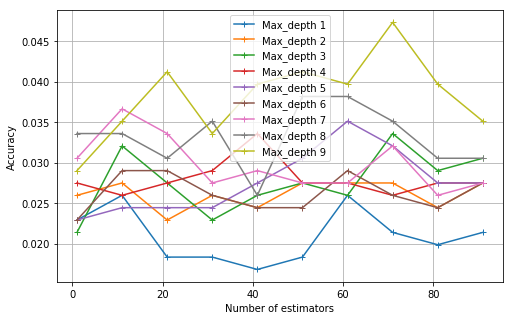

Number of estimators :  40
Max depth :  9
Parameters :  {'random_state': 1, 'max_depth': 9, 'n_estimators': 40}
Score cross validation with RandomForestClassifier 0.0381679389313
Score for generalization with RandomForestClassifier 0.0199004975124
Number of estimators :  141
Score after cross validation for Adaboost 0.0458015267176
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 141}
Score cross validation with AdaBoostClassifier 0.0458015267176
Score for generalization with AdaBoostClassifier 0.0497512437811
For Classifier :  Comedy
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.039801
Perceptron              0.019900
MLPClassifier           0.024876
SVC                     0.044776
Decision Trees          0.029851
RandomForestClassifier  0.019900
AdaBoostClassifier      0.049751


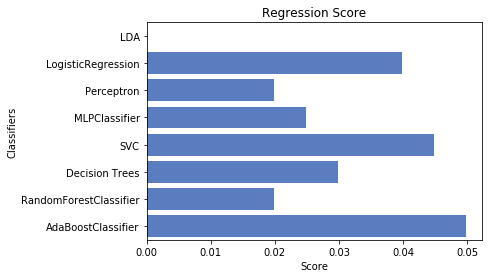

Thriller
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0315789473684
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.0315789473684
Score for generalization with LogisticRegression 0.0236686390533
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0350877192982
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0350877192982
Score for generalization with Perceptron 0.0532544378698
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.0263157894737
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.0263157894737
Score for generalization with MLPClassifier 0.0236686390533
Kernel used :  sigmoid
Score after cross validation for SVM 0.04385964912

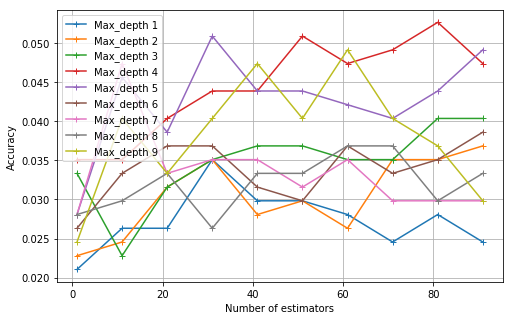

Number of estimators :  40
Max depth :  4
Parameters :  {'random_state': 1, 'max_depth': 4, 'n_estimators': 40}
Score cross validation with RandomForestClassifier 0.0438596491228
Score for generalization with RandomForestClassifier 0.0414201183432
Number of estimators :  11
Score after cross validation for Adaboost 0.0385964912281
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 11}
Score cross validation with AdaBoostClassifier 0.0385964912281
Score for generalization with AdaBoostClassifier 0.0118343195266
For Classifier :  Thriller
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.023669
Perceptron              0.053254
MLPClassifier           0.023669
SVC                     0.035503
Decision Trees          0.041420
RandomForestClassifier  0.041420
AdaBoostClassifier      0.011834


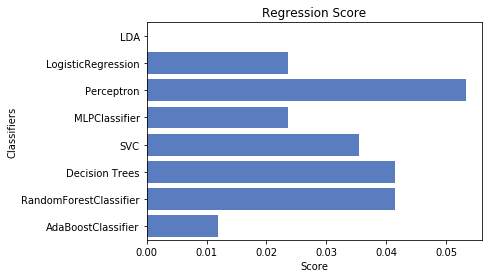

Action
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.0333333333333
Parameters :  {'solver': 'saga', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.0333333333333
Score for generalization with LogisticRegression 0.0487804878049
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0296296296296
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0296296296296
Score for generalization with Perceptron 0.0121951219512
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.0351851851852
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.0351851851852
Score for generalization with MLPClassifier 0.0182926829268
Kernel used :  sigmoid
Score after cross validation for SVM 0.0296296296296
Parameter

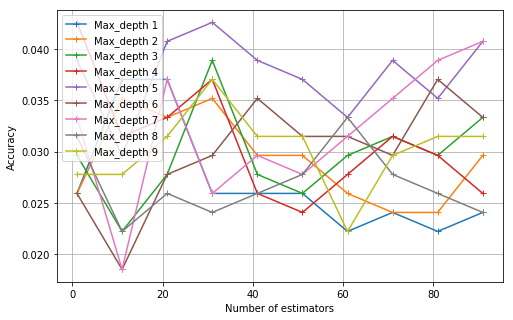

Number of estimators :  1
Max depth :  4
Parameters :  {'random_state': 1, 'max_depth': 4, 'n_estimators': 1}
Score cross validation with RandomForestClassifier 0.0425925925926
Score for generalization with RandomForestClassifier 0.0182926829268
Number of estimators :  81
Score after cross validation for Adaboost 0.0462962962963
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 81}
Score cross validation with AdaBoostClassifier 0.0462962962963
Score for generalization with AdaBoostClassifier 0.0121951219512
For Classifier :  Action
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.048780
Perceptron              0.012195
MLPClassifier           0.018293
SVC                     0.036585
Decision Trees          0.048780
RandomForestClassifier  0.018293
AdaBoostClassifier      0.012195


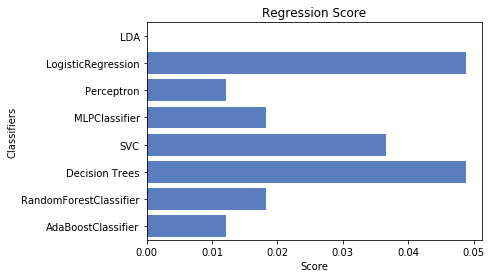

Adventure
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0410256410256
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.0410256410256
Score for generalization with LogisticRegression 0.025641025641
Penalty chosen :  l2
Score after cross validation for Perceptron 0.0282051282051
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.0282051282051
Score for generalization with Perceptron 0.025641025641
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.0333333333333
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.0333333333333
Score for generalization with MLPClassifier 0.0512820512821
Kernel used :  sigmoid
Score after cross validation for SVM 0.046153846153

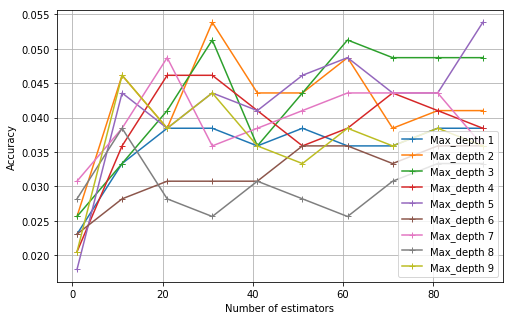

Number of estimators :  31
Max depth :  2
Parameters :  {'random_state': 1, 'max_depth': 2, 'n_estimators': 31}
Score cross validation with RandomForestClassifier 0.0538461538462
Score for generalization with RandomForestClassifier 0.042735042735
Number of estimators :  11
Score after cross validation for Adaboost 0.0435897435897
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 11}
Score cross validation with AdaBoostClassifier 0.0435897435897
Score for generalization with AdaBoostClassifier 0.0598290598291
For Classifier :  Adventure
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.025641
Perceptron              0.025641
MLPClassifier           0.051282
SVC                     0.042735
Decision Trees          0.034188
RandomForestClassifier  0.042735
AdaBoostClassifier      0.059829


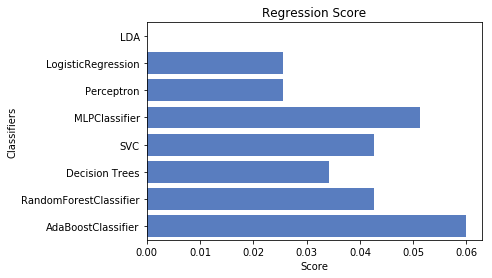

Romance
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.0276923076923
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.0276923076923
Score for generalization with LogisticRegression 0.010101010101
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0430769230769
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0430769230769
Score for generalization with Perceptron 0.040404040404
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.0430769230769
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.0430769230769
Score for generalization with MLPClassifier 0.040404040404
Kernel used :  sigmoid
Score after cross validation for SVM 0.0492307692308
P

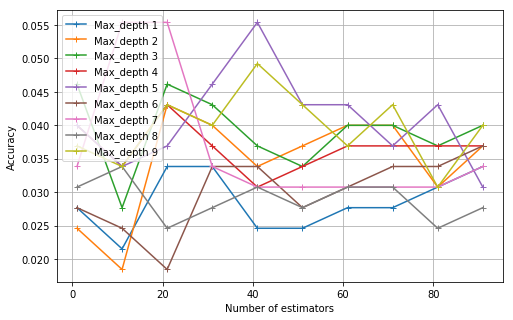

Number of estimators :  11
Max depth :  7
Parameters :  {'random_state': 1, 'max_depth': 7, 'n_estimators': 11}
Score cross validation with RandomForestClassifier 0.0553846153846
Score for generalization with RandomForestClassifier 0.040404040404
Number of estimators :  11
Score after cross validation for Adaboost 0.0461538461538
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 11}
Score cross validation with AdaBoostClassifier 0.0461538461538
Score for generalization with AdaBoostClassifier 0.030303030303
For Classifier :  Romance
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.010101
Perceptron              0.040404
MLPClassifier           0.040404
SVC                     0.020202
Decision Trees          0.030303
RandomForestClassifier  0.040404
AdaBoostClassifier      0.030303


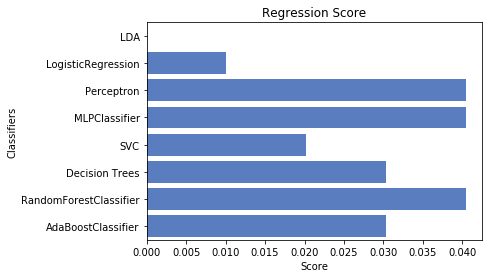

Crime
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.015873015873
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.015873015873
Score for generalization with LogisticRegression 0.0103092783505
Penalty chosen :  l1
Score after cross validation for Perceptron 0.0222222222222
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.0222222222222
Score for generalization with Perceptron 0.0103092783505
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.0285714285714
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.0285714285714
Score for generalization with MLPClassifier 0.0412371134021
Kernel used :  sigmoid
Score after cross validation for SVM 0.031746031746
Par

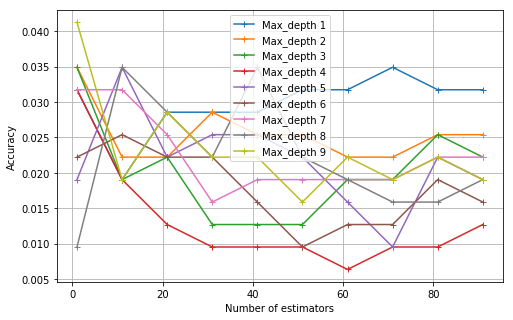

Number of estimators :  1
Max depth :  9
Parameters :  {'random_state': 1, 'max_depth': 9, 'n_estimators': 1}
Score cross validation with RandomForestClassifier 0.0412698412698
Score for generalization with RandomForestClassifier 0.0515463917526
Number of estimators :  91
Score after cross validation for Adaboost 0.0285714285714
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 91}
Score cross validation with AdaBoostClassifier 0.0285714285714
Score for generalization with AdaBoostClassifier 0.020618556701
For Classifier :  Crime
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.010309
Perceptron              0.010309
MLPClassifier           0.041237
SVC                     0.030928
Decision Trees          0.041237
RandomForestClassifier  0.051546
AdaBoostClassifier      0.020619


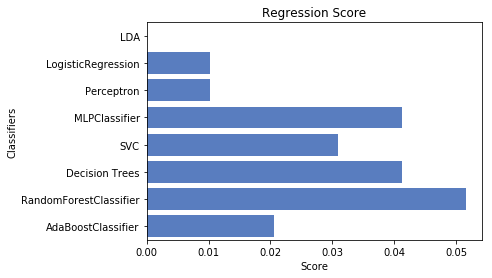

Science Fiction
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.028
Parameters :  {'solver': 'saga', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.028
Score for generalization with LogisticRegression 0.0266666666667
Penalty chosen :  l1
Score after cross validation for Perceptron 0.02
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.02
Score for generalization with Perceptron 0.04
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.032
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.032
Score for generalization with MLPClassifier 0.0266666666667
Kernel used :  rbf
Score after cross validation for SVM 0.036
Parameters :  {'gamma': 'auto', 'kernel': 'rbf', 'random_state': 1}
Score cross validat

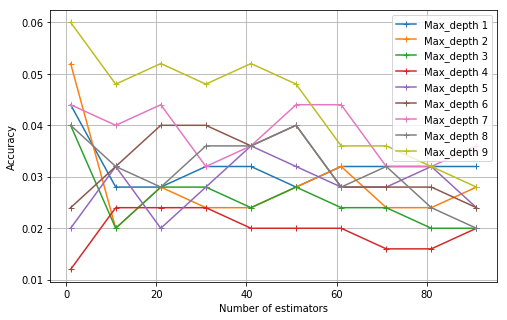

Number of estimators :  1
Max depth :  9
Parameters :  {'random_state': 1, 'max_depth': 9, 'n_estimators': 1}
Score cross validation with RandomForestClassifier 0.06
Score for generalization with RandomForestClassifier 0.0666666666667
Number of estimators :  41
Score after cross validation for Adaboost 0.04
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 41}
Score cross validation with AdaBoostClassifier 0.04
Score for generalization with AdaBoostClassifier 0.0133333333333
For Classifier :  Science Fiction
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.026667
Perceptron              0.040000
MLPClassifier           0.026667
SVC                     0.013333
Decision Trees          0.026667
RandomForestClassifier  0.066667
AdaBoostClassifier      0.013333


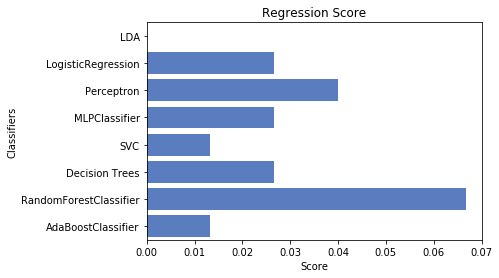

In [347]:
# Gets the results for all the genres
answer_c_100 , liste_classifiers_g_100 =  compare_classification_genre(liste_genres, dataset_genre)

In [348]:
# It will plot the classifiers, accuracy for each genre
def plot_graph_genre_c(classifiers,liste_genres) :
    liste_max_score = []
    liste_name_reg = []
    for index, classifier in enumerate(classifiers) :
        max_score = np.max(classifier.list_score)
        index_max = np.argmax(classifier.list_score)
        name_reg = classifier.classificators_name[index_max]
        liste_max_score.append(max_score)
        liste_name_reg.append(name_reg)
    
    score_classifiers = {}
    score_classifiers['Accuracy'] = liste_max_score
    score_classifiers['Classifier used'] = liste_name_reg
    score_class_df = pd.DataFrame(score_classifiers, index =liste_genres)        
    print(score_class_df)            


In [349]:
# Prints the results for each genre with 100 labels as grade
plot_graph_genre_c(liste_classifiers_g_100,liste_genres)

                 Accuracy         Classifier used
Drama            0.130435  RandomForestClassifier
Comedy           0.049751      AdaBoostClassifier
Thriller         0.053254              Perceptron
Action           0.048780      LogisticRegression
Adventure        0.059829      AdaBoostClassifier
Romance          0.040404              Perceptron
Crime            0.051546  RandomForestClassifier
Science Fiction  0.066667  RandomForestClassifier


<div class="alert alert-success">
Grade as 20 different labels for the genre splits
    
</div>



In [350]:
# Creation of a Dataset instance
dataset_genre_20 = Dataset(pre_process_genre)
# Discretization into 20 labels
dataset_genre_20.discretize(1)
# Splits into train and test subsets
dataset_genre_20.set_sets()
# Normalization of the inputs
dataset_genre_20.normalize()


Drama
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.487951807229
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.487951807229
Score for generalization with LogisticRegression 0.446640316206
Penalty chosen :  l2
Score after cross validation for Perceptron 0.230120481928
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.230120481928
Score for generalization with Perceptron 0.217391304348
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.324096385542
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.324096385542
Score for generalization with MLPClassifier 0.284584980237
Kernel used :  sigmoid
Score after cross validation for SVM 0.471084337349
Parameters

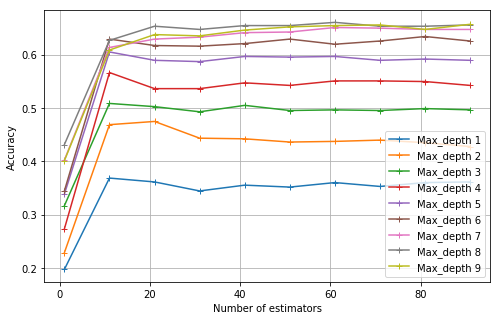

Number of estimators :  40
Max depth :  8
Parameters :  {'random_state': 1, 'max_depth': 8, 'n_estimators': 40}
Score cross validation with RandomForestClassifier 0.65421686747
Score for generalization with RandomForestClassifier 0.490118577075
Number of estimators :  61
Score after cross validation for Adaboost 0.419277108434
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 61}
Score cross validation with AdaBoostClassifier 0.419277108434
Score for generalization with AdaBoostClassifier 0.264822134387
For Classifier :  Drama
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.446640
Perceptron              0.217391
MLPClassifier           0.284585
SVC                     0.430830
Decision Trees          0.379447
RandomForestClassifier  0.490119
AdaBoostClassifier      0.264822


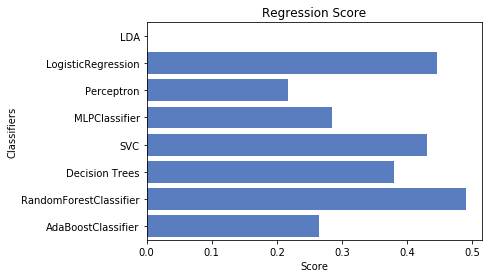

Comedy
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.83358778626
Parameters :  {'solver': 'saga', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.83358778626
Score for generalization with LogisticRegression 0.796019900498
Penalty chosen :  l2
Score after cross validation for Perceptron 0.75572519084
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.75572519084
Score for generalization with Perceptron 0.65671641791
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.842748091603
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.842748091603
Score for generalization with MLPClassifier 0.796019900498
Kernel used :  rbf
Score after cross validation for SVM 0.842748091603
Parameters :  {'gamma': 'aut

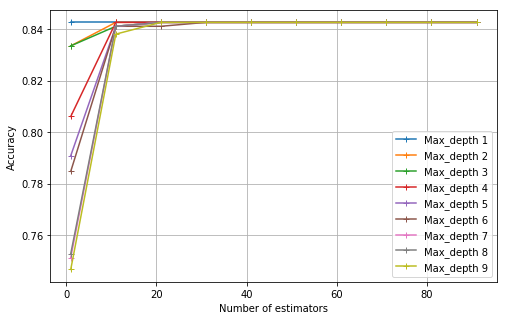

Number of estimators :  1
Max depth :  1
Parameters :  {'random_state': 1, 'max_depth': 1, 'n_estimators': 1}
Score cross validation with RandomForestClassifier 0.842748091603
Score for generalization with RandomForestClassifier 0.796019900498
Number of estimators :  11
Score after cross validation for Adaboost 0.839694656489
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 11}
Score cross validation with AdaBoostClassifier 0.839694656489
Score for generalization with AdaBoostClassifier 0.796019900498
For Classifier :  Comedy
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.796020
Perceptron              0.656716
MLPClassifier           0.796020
SVC                     0.796020
Decision Trees          0.796020
RandomForestClassifier  0.796020
AdaBoostClassifier      0.796020


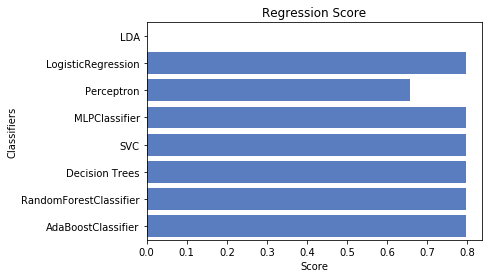

Thriller
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.836842105263
Parameters :  {'solver': 'saga', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.836842105263
Score for generalization with LogisticRegression 0.792899408284
Penalty chosen :  l1
Score after cross validation for Perceptron 0.798245614035
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.798245614035
Score for generalization with Perceptron 0.786982248521
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.829824561404
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.829824561404
Score for generalization with MLPClassifier 0.792899408284
Kernel used :  poly
Score after cross validation for SVM 0.845614035088
Parameters :  {'gamm

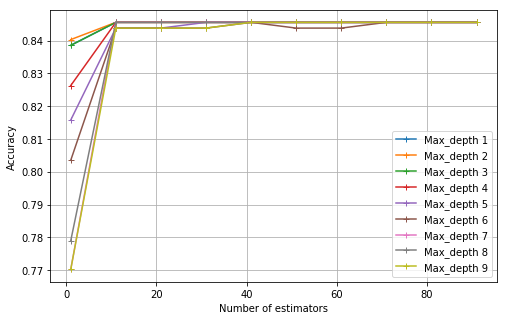

Number of estimators :  11
Max depth :  1
Parameters :  {'random_state': 1, 'max_depth': 1, 'n_estimators': 11}
Score cross validation with RandomForestClassifier 0.845614035088
Score for generalization with RandomForestClassifier 0.792899408284
Number of estimators :  1
Score after cross validation for Adaboost 0.842105263158
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 1}
Score cross validation with AdaBoostClassifier 0.842105263158
Score for generalization with AdaBoostClassifier 0.792899408284
For Classifier :  Thriller
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.792899
Perceptron              0.786982
MLPClassifier           0.792899
SVC                     0.786982
Decision Trees          0.792899
RandomForestClassifier  0.792899
AdaBoostClassifier      0.792899


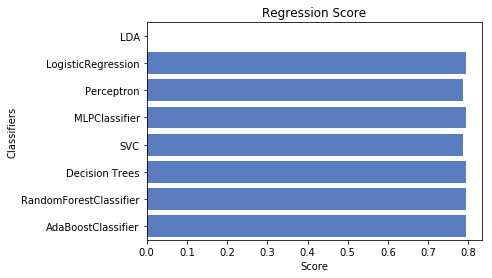

Action
Solver chosen :  sag
Score after cross validation for Logistic Regression  0.837037037037
Parameters :  {'solver': 'sag', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.837037037037
Score for generalization with LogisticRegression 0.780487804878
Penalty chosen :  l1
Score after cross validation for Perceptron 0.768518518519
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.768518518519
Score for generalization with Perceptron 0.719512195122
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.82037037037
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.82037037037
Score for generalization with MLPClassifier 0.786585365854
Kernel used :  rbf
Score after cross validation for SVM 0.844444444444
Parameters :  {'gamma': 'au

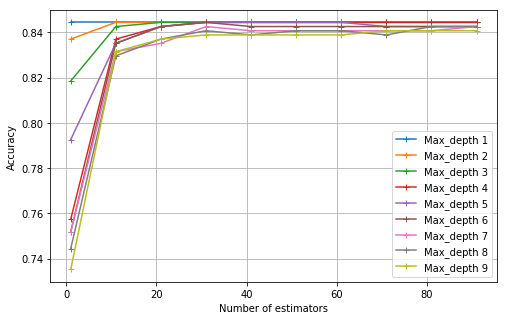

Number of estimators :  1
Max depth :  1
Parameters :  {'random_state': 1, 'max_depth': 1, 'n_estimators': 1}
Score cross validation with RandomForestClassifier 0.844444444444
Score for generalization with RandomForestClassifier 0.786585365854
Number of estimators :  11
Score after cross validation for Adaboost 0.833333333333
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 11}
Score cross validation with AdaBoostClassifier 0.833333333333
Score for generalization with AdaBoostClassifier 0.786585365854
For Classifier :  Action
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.780488
Perceptron              0.719512
MLPClassifier           0.786585
SVC                     0.786585
Decision Trees          0.786585
RandomForestClassifier  0.786585
AdaBoostClassifier      0.786585


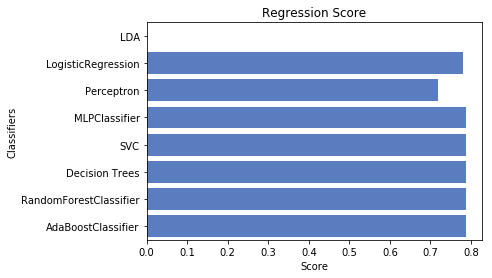

Adventure
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.797435897436
Parameters :  {'solver': 'saga', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.797435897436
Score for generalization with LogisticRegression 0.794871794872
Penalty chosen :  l2
Score after cross validation for Perceptron 0.751282051282
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.751282051282
Score for generalization with Perceptron 0.641025641026
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.658974358974
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.658974358974
Score for generalization with MLPClassifier 0.803418803419
Kernel used :  poly
Score after cross validation for SVM 0.823076923077
Parameters :  {'gam

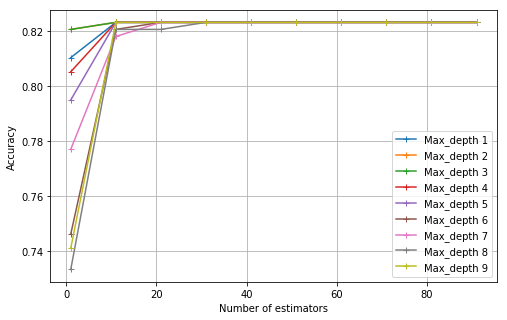

Number of estimators :  11
Max depth :  1
Parameters :  {'random_state': 1, 'max_depth': 1, 'n_estimators': 11}
Score cross validation with RandomForestClassifier 0.823076923077
Score for generalization with RandomForestClassifier 0.803418803419
Number of estimators :  1
Score after cross validation for Adaboost 0.823076923077
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 1}
Score cross validation with AdaBoostClassifier 0.823076923077
Score for generalization with AdaBoostClassifier 0.803418803419
For Classifier :  Adventure
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.794872
Perceptron              0.641026
MLPClassifier           0.803419
SVC                     0.786325
Decision Trees          0.803419
RandomForestClassifier  0.803419
AdaBoostClassifier      0.803419


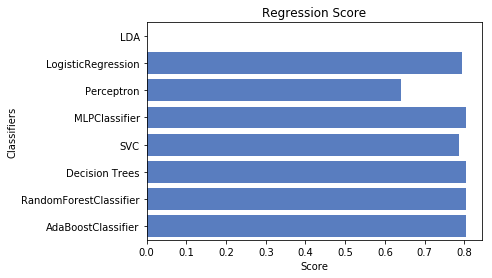

Romance
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.8
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.8
Score for generalization with LogisticRegression 0.767676767677
Penalty chosen :  l1
Score after cross validation for Perceptron 0.76
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.76
Score for generalization with Perceptron 0.707070707071
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.661538461538
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.661538461538
Score for generalization with MLPClassifier 0.808080808081
Kernel used :  rbf
Score after cross validation for SVM 0.827692307692
Parameters :  {'gamma': 'auto', 'kernel': 'rbf', 'rand

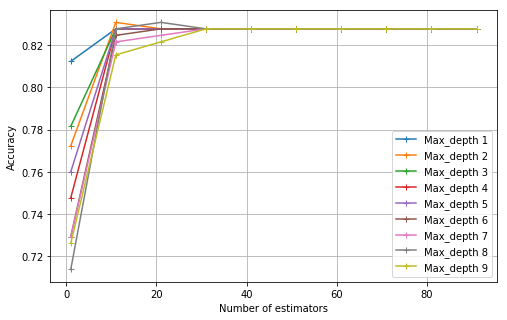

Number of estimators :  11
Max depth :  2
Parameters :  {'random_state': 1, 'max_depth': 2, 'n_estimators': 11}
Score cross validation with RandomForestClassifier 0.830769230769
Score for generalization with RandomForestClassifier 0.767676767677
Number of estimators :  1
Score after cross validation for Adaboost 0.827692307692
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 1}
Score cross validation with AdaBoostClassifier 0.827692307692
Score for generalization with AdaBoostClassifier 0.767676767677
For Classifier :  Romance
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.767677
Perceptron              0.707071
MLPClassifier           0.808081
SVC                     0.808081
Decision Trees          0.808081
RandomForestClassifier  0.767677
AdaBoostClassifier      0.767677


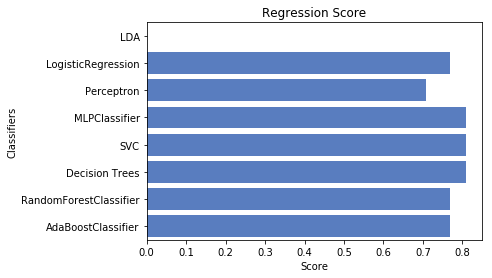

Crime
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.8
Parameters :  {'solver': 'saga', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.8
Score for generalization with LogisticRegression 0.79381443299
Penalty chosen :  l2
Score after cross validation for Perceptron 0.72380952381
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.72380952381
Score for generalization with Perceptron 0.731958762887
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.663492063492
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.663492063492
Score for generalization with MLPClassifier 0.814432989691
Kernel used :  poly
Score after cross validation for SVM 0.825396825397
Parameters :  {'gamma': 'auto', 'kernel': 'poly'

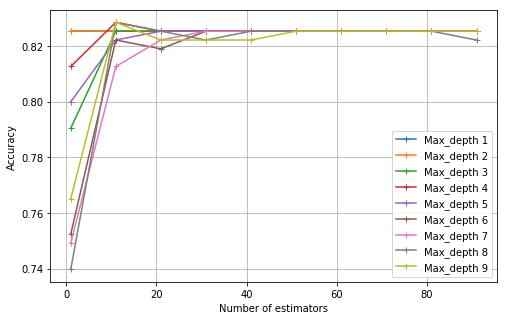

Number of estimators :  11
Max depth :  4
Parameters :  {'random_state': 1, 'max_depth': 4, 'n_estimators': 11}
Score cross validation with RandomForestClassifier 0.828571428571
Score for generalization with RandomForestClassifier 0.814432989691
Number of estimators :  1
Score after cross validation for Adaboost 0.825396825397
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 1}
Score cross validation with AdaBoostClassifier 0.825396825397
Score for generalization with AdaBoostClassifier 0.814432989691
For Classifier :  Crime
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.793814
Perceptron              0.731959
MLPClassifier           0.814433
SVC                     0.804124
Decision Trees          0.814433
RandomForestClassifier  0.814433
AdaBoostClassifier      0.814433


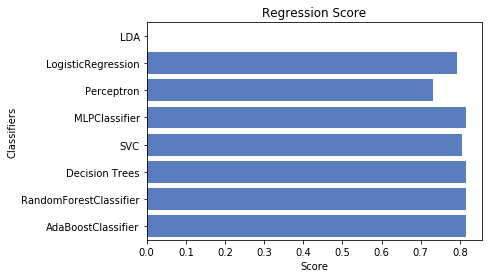

Science Fiction
Solver chosen :  saga
Score after cross validation for Logistic Regression  0.772
Parameters :  {'solver': 'saga', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.772
Score for generalization with LogisticRegression 0.8
Penalty chosen :  l2
Score after cross validation for Perceptron 0.668
Parameters :  {'random_state': 1, 'penalty': 'l2'}
Score cross validation with Perceptron 0.668
Score for generalization with Perceptron 0.706666666667
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.66
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.66
Score for generalization with MLPClassifier 0.8
Kernel used :  rbf
Score after cross validation for SVM 0.82
Parameters :  {'gamma': 'auto', 'kernel': 'rbf', 'random_state': 1}
Score cross validation with SVC 0.

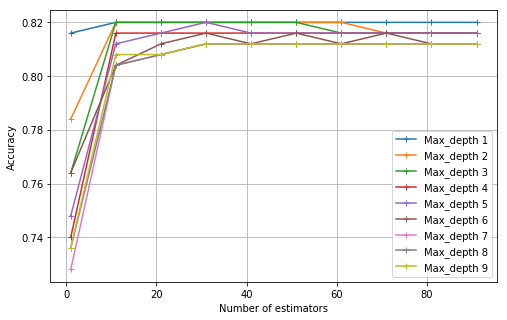

Number of estimators :  11
Max depth :  1
Parameters :  {'random_state': 1, 'max_depth': 1, 'n_estimators': 11}
Score cross validation with RandomForestClassifier 0.82
Score for generalization with RandomForestClassifier 0.8
Number of estimators :  1
Score after cross validation for Adaboost 0.804
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 1}
Score cross validation with AdaBoostClassifier 0.804
Score for generalization with AdaBoostClassifier 0.8
For Classifier :  Science Fiction
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.800000
Perceptron              0.706667
MLPClassifier           0.800000
SVC                     0.800000
Decision Trees          0.800000
RandomForestClassifier  0.800000
AdaBoostClassifier      0.800000


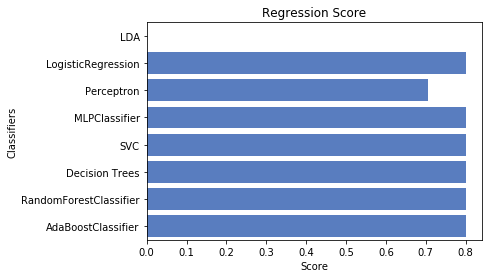

In [351]:
# Gets the results for all the genres
answer_c_20 , liste_classifiers_g_20 =  compare_classification_genre(liste_genres, dataset_genre_20)

In [352]:
# Prints the results for each genre with 20 labels as grade
plot_graph_genre_c(liste_classifiers_g_20,liste_genres)

                 Accuracy         Classifier used
Drama            0.490119  RandomForestClassifier
Comedy           0.796020      LogisticRegression
Thriller         0.792899      LogisticRegression
Action           0.786585           MLPClassifier
Adventure        0.803419           MLPClassifier
Romance          0.808081           MLPClassifier
Crime            0.814433           MLPClassifier
Science Fiction  0.800000      LogisticRegression


<div class="alert alert-success">
Revenue as 3 different labels for the genre splits
    
</div>



In [353]:
# Creation of a Dataset instance
dataset_genre_r = Dataset(pre_process_genre)
# Discretization revenue into 3 labels
dataset_genre_r.discretize_revenue()
# Splits into train and test subsets
dataset_genre_r.set_sets()
# Normalization of the inputs
dataset_genre_r.normalize()


In [354]:
# Functions that we'll returns the classifiers that best fit the data
# It will also give, for each genre, the accuracy and the classifier used to get its accuracy
# It is made for revenue label
def compare_revenue_genre(liste_genres, dataset_genre) :
    # Compares all the algorithm of regression for all the genre set
    answer = []
    liste_function_classifier = [get_lda , get_lreg, get_perc ,get_mlpc, get_svm,get_dtc ,\
                            get_rfc, get_ada]
    liste_classifiers = [LinearDiscriminantAnalysis, LogisticRegression,Perceptron, MLPClassifier,\
                    SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier]
    liste_class = []
    for i in range(1) :
        X_train, X_test, y_train, y_test = dataset_genre.get_revenue_data(i)    
        print(liste_genres[i])
        classifier = Classifications(X_train, y_train, X_test, y_test)
        classifier.set_regressors(liste_classifiers)
        classifier.set_functions(liste_function_classifier)
        for j in range(1,len(liste_function_classifier)) : 
            classifier.function(j)
            classifier.print_classifier_scores(j)
        print("For Classifier : ", liste_genres[i])
        classifier.print_all_score()
        liste_class.append(classifier)
        answer.append(classifier.print_best_classifier())
    return answer , liste_class



Drama
Solver chosen :  newton-cg
Score after cross validation for Logistic Regression  0.653012048193
Parameters :  {'solver': 'newton-cg', 'multi_class': 'multinomial', 'random_state': 1}
Score cross validation with LogisticRegression 0.653012048193
Score for generalization with LogisticRegression 0.640316205534
Penalty chosen :  l1
Score after cross validation for Perceptron 0.587951807229
Parameters :  {'random_state': 1, 'penalty': 'l1'}
Score cross validation with Perceptron 0.587951807229
Score for generalization with Perceptron 0.557312252964
Number of hidden layers :  (50, 1)
Score after cross validation for MLPC 0.581927710843
Parameters :  {'solver': 'adam', 'random_state': 1, 'activation': 'logistic', 'learning_rate': 'adaptive', 'max_iter': 500, 'hidden_layer_sizes': (50, 1)}
Score cross validation with MLPClassifier 0.581927710843
Score for generalization with MLPClassifier 0.569169960474
Kernel used :  sigmoid
Score after cross validation for SVM 0.624096385542
Parameters

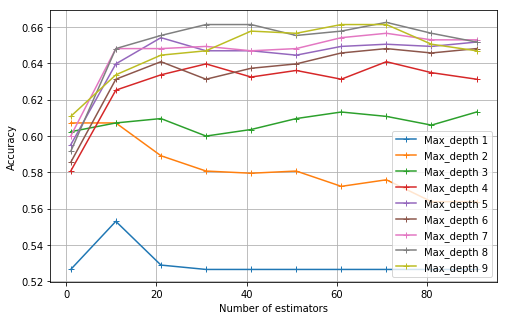

Number of estimators :  40
Max depth :  8
Parameters :  {'random_state': 1, 'max_depth': 8, 'n_estimators': 40}
Score cross validation with RandomForestClassifier 0.660240963855
Score for generalization with RandomForestClassifier 0.584980237154
Number of estimators :  71
Score after cross validation for Adaboost 0.68313253012
Parameters :  {'learning_rate': 0.5, 'random_state': 1, 'n_estimators': 71}
Score cross validation with AdaBoostClassifier 0.68313253012
Score for generalization with AdaBoostClassifier 0.636363636364
For Classifier :  Drama
Score for the different classifiers 
                           Score
LDA                     0.000000
LogisticRegression      0.640316
Perceptron              0.557312
MLPClassifier           0.569170
SVC                     0.616601
Decision Trees          0.478261
RandomForestClassifier  0.584980
AdaBoostClassifier      0.636364


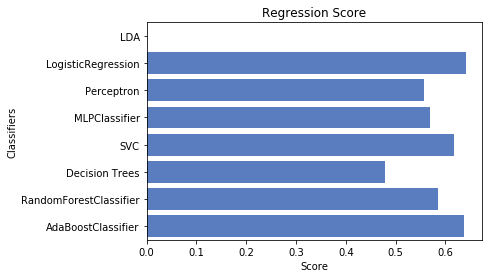

In [355]:
# Gets the results for all the genres
answer_r , liste_classifiers_r =  compare_revenue_genre(liste_genres, dataset_genre_r)

In [356]:
plot_graph_genre_c(liste_classifiers_r,liste_genres)

                 Accuracy     Classifier used
Drama            0.640316  LogisticRegression
Comedy           0.640316  LogisticRegression
Thriller         0.640316  LogisticRegression
Action           0.640316  LogisticRegression
Adventure        0.640316  LogisticRegression
Romance          0.640316  LogisticRegression
Crime            0.640316  LogisticRegression
Science Fiction  0.640316  LogisticRegression


<div class="alert alert-success">
We get back all the data and print the coefficient of the linear regression depending on the features
    
</div>



In [376]:
# Gets the coefficients
coefs = regressor_grade.classifiers[0]().fit(regressor_grade.X_train, regressor_grade.y_train).coef_
# Gets the name of the features
name_features = pre_process.train[0].columns
# Index where the features are the highest
index_max = np.where( coefs >= -2e12)[0]

In [377]:
coefs

array([ -2.26008893e-02,  -1.31788854e-02,  -1.46577807e+12,
        -1.56431191e+12,  -1.62100120e+12,  -1.52741314e+12,
        -1.61753813e+12,  -1.68491792e+12,  -1.69469813e+12,
        -1.73929053e+12,  -2.01626092e+12,  -1.72987664e+12,
        -1.63132901e+12,  -1.84101706e+12,  -2.00768153e-02,
         1.03494557e-02,  -6.14920792e-03,   2.06121852e-03,
        -9.33548022e-03,  -9.79093518e-03,   8.75169248e-03,
         2.46969542e-04,  -9.40166542e-03,  -6.47097617e-03,
         1.67997488e-02,  -4.25771940e-03,   9.68445555e-03,
        -6.11202326e-04,  -1.23152371e-02,   2.73765158e-03,
        -1.29494648e-02,   5.78331947e-03,   8.67025567e+11,
        -3.48510742e-02,   3.17382812e-03,  -6.10351562e-03,
        -3.90625000e-03,  -6.10351562e-03,  -9.76562500e-04,
        -5.35428392e+11,  -2.20001870e+12,  -8.16714476e+11,
        -1.04513179e+12,  -1.54846984e+12,  -7.24327729e+11,
        -1.69887445e+11,  -2.71091380e+12,  -4.34023958e+12,
        -3.97510000e+12,

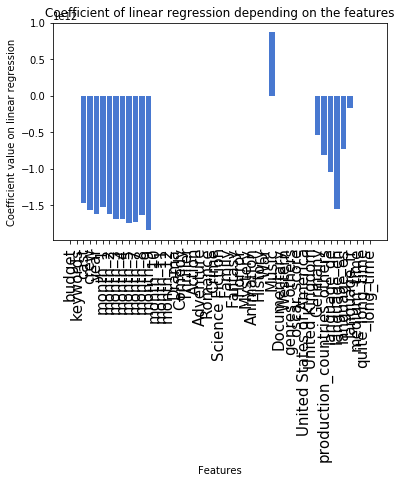

In [378]:


new_column = np.array([x for x in data.columns if (x!='revenue' and x!='ratio' and x!='grade')])[index_max]

# Plots 
plt.xticks(rotation=90, fontsize = 15)
plt.ylabel("Coefficient value on linear regression")
plt.xlabel("Features")
plt.bar(new_column, coefs[index_max], align = 'center', color='b')
plt.title("Coefficient of linear regression depending on the features")
plt.show()

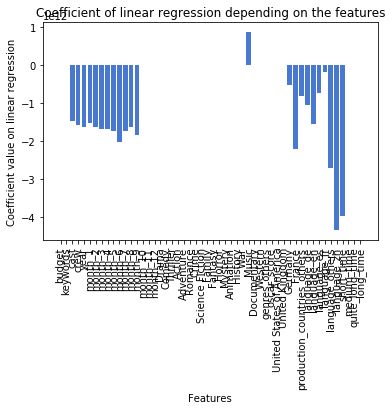

In [379]:
# Plots all
new_column = np.array([x for x in data.columns if (x!='revenue' and x!='ratio' and x!='grade')])
plt.xticks(rotation=90, fontsize = 10)
plt.ylabel("Coefficient value on linear regression")
plt.xlabel("Features")
plt.bar(new_column, coefs, align = 'center', color='b')
plt.title("Coefficient of linear regression depending on the features")
plt.show()

array([ 6.25371272,  5.54912287,  5.92168147,  5.33769709,  5.74345881,
        6.07549006,  6.65312678,  6.77275569,  1.24004084,  5.3557635 ,
        5.69658381,  5.894826  ,  6.75273616,  5.65361506,  6.19463069,
        5.52080256,  4.67070491,  5.66484553,  5.53496272,  5.73613459,
        6.01250178,  6.94414241,  4.58867366,  5.61552912,  4.86015803,
        5.38213069,  3.91875178,  5.77617366,  4.91338069,  5.72734553,
        5.22685725,  5.89189631,  7.42851741,  6.43193537,  4.68974787,
        5.14287287,  5.35478694,  6.23759944,  7.19658381,  6.88213069,
        5.70830256,  7.04619319,  5.98466975,  6.45049006,  5.68535334,
        3.44560725,  6.14238459,  6.98564631,  4.41777522,  5.78935725,
        5.24736506,  6.85478694,  6.30547053,  6.6370135 ,  5.65556819,
        5.77275569,  5.6526385 ,  5.38506037,  6.25322444,  6.61064631,
        6.73955256,  5.30644709,  5.28203303,  4.82939631,  5.78642756,
        5.40459162,  7.07549006,  5.88847834,  5.13896662,  4.17

In [372]:
dataset_all.pre_process.test

[        budget    revenue  year  month_1  month_2  month_3  month_4  month_5  \
 0     14000000  173046663  1996        0        0        0        0        0   
 1     85000000  137298489  1993        0        0        0        0        0   
 2      6500000   28451622  1999        0        0        0        1        0   
 3     10000000   21786738  2007        0        0        0        0        1   
 4     32000000  152036382  1996        0        0        0        0        0   
 5      2200000   11502151  2006        1        0        0        0        0   
 6      6500000   17693675  2011        0        0        0        0        0   
 7     24000000  182016617  1995        0        0        0        0        1   
 8     12000000    4922166  2003        0        0        0        0        0   
 9     25000000    4152230  1999        0        0        0        1        0   
 10   170000000  396600000  2012        0        0        0        0        1   
 11    10000000   85978266  

In [373]:
datatest = data.copy()

In [374]:
datatest.sort_values("year", axis = 0, ascending = True, 
                 inplace = True, na_position ='last') 

In [375]:
train_t, test_t = train_test_split(datatest, test_size=0.2, shuffle=False)

In [387]:
print(test_t[:10].grade)

1323    5.946225
2010    7.354707
1681    4.923610
1310    4.560836
1198    5.389695
623     5.660475
218     6.159697
18      6.044957
132     5.492386
80      5.620914
Name: grade, dtype: float64


In [429]:
y_grade_predict = regressor_grade.classifiers[0]().fit(regressor_grade.X_train, regressor_grade.y_train).\
predict(regressor_grade.X_test)

In [385]:
regressor_grade.y_test[:10]

array([ 6.7397104 ,  5.72523416,  6.28571429,  5.27452375,  5.64358512,
        6.18465383,  6.6619383 ,  6.79035281,  0.91485586,  5.35875068])

In [414]:
dataset[dataset.grade == regressor_grade.y_test[:10][0] ].original_title

2282    Scream
Name: original_title, dtype: object

In [417]:
liste_title = []
for index,x in enumerate(regressor_grade.y_test) :
    liste_title.append((index,dataset[dataset.grade == x ].original_title))


In [418]:
print(liste_title)

[(0, 2282    Scream
Name: original_title, dtype: object), (1, 403    Last Action Hero
Name: original_title, dtype: object), (2, 3425    Go
Name: original_title, dtype: object), (3, 1315              Rock Star
3095    My Blueberry Nights
Name: original_title, dtype: object), (4, 1495    Phenomenon
Name: original_title, dtype: object), (5, 3543    Rang De Basanti
Name: original_title, dtype: object), (6, 3430    Shame
Name: original_title, dtype: object), (7, 2022    The Bridges of Madison County
Name: original_title, dtype: object), (8, 2872    From Justin to Kelly
Name: original_title, dtype: object), (9, 2626    Idle Hands
Name: original_title, dtype: object), (10, 80    Snow White and the Huntsman
Name: original_title, dtype: object), (11, 3025    The Second Best Exotic Marigold Hotel
Name: original_title, dtype: object), (12, 3596    Y tu mamá también
Name: original_title, dtype: object), (13, 1091          Nixon
1325    The Express
Name: original_title, dtype: object), (14, 1156   

In [ ]:
movie_to_print = ["54, 36, Transformers: Age of Extinction",\
                  "78,22, The Hobbit: The Desolation of Smaug", "86, 635, Apollo 13",\
                 "522, 95  Interstellar"]

In [425]:
dataset.loc[95,:]

budget                                                          165000000
genres                  [{"id": 12, "name": "Adventure"}, {"id": 18, "...
homepage                                http://www.interstellarmovie.net/
id                                                                 157336
keywords                [{"id": 83, "name": "saving the world"}, {"id"...
original_language                                                      en
original_title                                               Interstellar
overview                Interstellar chronicles the adventures of a gr...
popularity                                                        724.248
production_companies    [{"name": "Paramount Pictures", "id": 4}, {"na...
production_countries    [{"iso_3166_1": "CA", "name": "Canada"}, {"iso...
release_date                                                   2014-11-05
revenue                                                         675120017
runtime                               

In [399]:
tmdb = pd.read_csv("TMDB/tmdb_5000_movies.csv")
tmdb2 = pd.read_csv("TMDB/tmdb_5000_credits.csv")
tmdb2.rename(columns={'movie_id':'id'}, inplace=True)
dataset = pd.merge(tmdb,tmdb2, on='id')
dataset['grade'] = dataset.vote_average - 10/np.sqrt(dataset.vote_count) 

In [555]:
index_grade = [54,78,86,522]
movie_grade_lr = []
for i in index_grade :
    movie_grade_lr.append(y_grade_predict[i])

In [556]:

print(movie_grade_lr)

[5.6555681863503908, 7.4524431863503908, 6.9338884988503908, 7.4153338113503908]


In [557]:
index_id_grade = [36,22,635, 95]
movie_grade_real = []
for i in index_id_grade :
    movie_grade_real.append(dataset.loc[i,"grade"])
    print(dataset.loc[i,"genres"])

[{"id": 878, "name": "Science Fiction"}, {"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}]
[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}]
[{"id": 18, "name": "Drama"}]
[{"id": 12, "name": "Adventure"}, {"id": 18, "name": "Drama"}, {"id": 878, "name": "Science Fiction"}]


In [558]:
print(movie_grade_real)

[5.6202496795385963, 7.4513247416374861, 7.0499218383598219, 8.0040720493676414]


In [559]:
liste_all_grade = []
for grade_pred in movie_grade_real :
    liste_grade = []
    for i in range(len(regressors_genre_grade)) :
        #index_drama = np.argmax(regressors_genre_grade[i].liste_oof_score)
        #drama_clf = SKlearnHelper(clf = regressors_genre_grade[i].classifiers[index_drama] , \
        #                 params = regressors_genre_grade[i].list_param[index_drama])
        
        liste_grade.append(np.where(regressors_genre_grade[i].y_test == grade_pred)[0])
    liste_all_grade.append(liste_grade)
        
        
#drama_clf.fit(regressors_genre_grade[1].X_train,regressors_genre_grade[1].y_train )

In [560]:
['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance', 'Crime', 'Science Fiction']

['Drama',
 'Comedy',
 'Thriller',
 'Action',
 'Adventure',
 'Romance',
 'Crime',
 'Science Fiction']

In [561]:
drama_index = [0, 0,219,22 ]
sf_index = [63,0,0,62]
adventure_index = [43,0,0,0]



In [562]:
index_drama = np.argmax( liste_classifiers_g_100[0].liste_oof_score)
drama_clf = SKlearnHelper(clf = liste_classifiers_g_100[0].classifiers[index_drama] , \
                params = liste_classifiers_g_100[0].list_param[index_drama])
drama_clf.fit(liste_classifiers_g_100[0].X_train, liste_classifiers_g_100[0].y_train)
print(drama_clf.predict(liste_classifiers_g_100[0].X_test)[22])


62


In [566]:
name_movies = ["Transformers: Age of Extinction",\
                  "The Hobbit: The Desolation of Smaug", " Apollo 13",\
                 "Interstellar"]
drama_precit = [np.nan,np.nan,6.5763701953550466,7.1106541935727101  ]
sf_predict = [5.78496323, np.nan,np.nan,7.14356886]
adventure_predict = [5.6635241800527316, np.nan, np.nan, np.nan]
adventure_predict_20 = [(9.5,10) ,np.nan , np.nan, np.nan    ] 
drama_predict_20 = [np.nan,np.nan,  (6,6.5), (6,6.5)  ]
sf_predict_20 = [  (9.5,10), np.nan , np.nan, (9.5,10)  ]
sf_predict_100 = [6.2, np.nan , np.nan , np.nan ] 
adventure_predict_100 = [  5.9, np.nan , np.nan, 6.4  ]
drama_predict_100 = [np.nan,np.nan,  6.1, 6.2  ]
movie_grade_real
print(movie_grade_lr)

[5.6555681863503908, 7.4524431863503908, 6.9338884988503908, 7.4153338113503908]


In [579]:
print("Score for 4 movies with our different models ")
score_regressors = {}
#score_regressors['Real values'] = movie_grade_real
#score_regressors['Linear Regression'] = movie_grade_lr
#score_regressors['Drama regression'] = drama_precit
#score_regressors['Drama classification (20)'] = drama_predict_20
#score_regressors['Drama classification (100)'] = drama_predict_100
score_regressors['Science fiction regression'] = sf_predict
#score_regressors['Science fiction classification (20)'] = sf_predict_20
#score_regressors['Science fiction classification (20)'] = sf_predict_100

score_regressors['Adventure classification (100)'] = sf_predict_100
score_regressors['Adventure regression'] = adventure_predict
score_regressors['Adventure classification (20)'] = adventure_predict_20
#score_regressors['Adventure classification (100)'] = adventure_predict_100
#score_regressors['Classification (20)'] =  movie_grade_20
#score_regressors['Classification (100)'] =  movie_grade_100

score_class_df = pd.DataFrame(score_regressors, index =name_movies)        
print(score_class_df)                
sns.set_color_codes("muted")
sns.barplot(x='Real values', y='Drama regression', data=score_class_df, color="b")
plt.xlabel('Score')
plt.title('Regression Score')
plt.show()

Score for 4 movies with our different models 
                                     Adventure classification (100)  \
Transformers: Age of Extinction                                 6.2   
The Hobbit: The Desolation of Smaug                             NaN   
 Apollo 13                                                      NaN   
Interstellar                                                    NaN   

                                    Adventure classification (20)  \
Transformers: Age of Extinction                         (9.5, 10)   
The Hobbit: The Desolation of Smaug                           NaN   
 Apollo 13                                                    NaN   
Interstellar                                                  NaN   

                                     Adventure regression  \
Transformers: Age of Extinction                  5.663524   
The Hobbit: The Desolation of Smaug                   NaN   
 Apollo 13                                            NaN   
Interste

ValueError: Could not interpret input 'Real values'

In [ ]:
        score_regressors = {}
        score_regressors['Score'] = self.list_score
        score_class_df = pd.DataFrame(score_regressors, index =self.regressors_name)        
        print(score_class_df)        
        sns.set_color_codes("muted")
        score_class_df['Regressors'] = self.regressors_name
        sns.barplot(x='Score', y='Regressors', data=score_class_df, color="b")
        plt.xlabel('Score')
        plt.title('Regression Score')
        plt.show()

In [525]:
index_grade_100 = np.argmax(classifier_100.liste_oof_score)
grade_100_clf = SKlearnHelper(clf = classifier_100.classifiers[index_grade_100] , \
                params = classifier_100.list_param[index_grade_100])
grade_100_clf.fit(classifier_100.X_train, classifier_100.y_train)
y_predict_100 = grade_100_clf.predict(classifier_100.X_test)


In [528]:
movie_grade_100 = []
for i in index_grade :
    movie_grade_100.append(y_predict_100[i])

In [529]:
movie_grade_100

[63, 72, 67, 73]

In [530]:
index_grade_20 = np.argmax(classifier_20.liste_oof_score)
grade_20_clf = SKlearnHelper(clf = classifier_20.classifiers[index_grade_20] , \
                params = classifier_20.list_param[index_grade_20])
grade_20_clf.fit(classifier_20.X_train, classifier_20.y_train)
y_predict_20 = grade_20_clf.predict(classifier_20.X_test)


In [531]:
movie_grade_20 = []
for i in index_grade :
    movie_grade_20.append(y_predict_20[i])

In [533]:
movie_grade_20 = [(5.5,6),(7,7.5),(6.5,7),(7,7.5)]

In [ ]:
elif x>=1 and x<1.5 :
        return 2
    elif x>=1.5 and x<2 :
        return 3
    elif x>=2 and x<2.5 :
        return 4
    elif x>=2.5 and x<3 :
        return 5
    elif x>=3 and x<3.5 :
        return 6
    elif x>=3.5 and x<4 :
        return 7
    elif x>=4 and x<4.5 :
        return 8
    elif x>=4.5 and x<5 :
        return 9
    elif x>=5  and x<5.5 :
        return 10
    elif x>=5.5 and x<6 :
        return 11
    elif x>=6 and x<6.5 :
        return 12
    elif x>=6.5 and x<7 :
        return 13
    elif x>=7 and x<7.5 :
        return 14
    elif x>=7.5 and x<8 :
        return 15
    elif x>=8 and x<8.5 :
        return 16
    elif x>=8.5 and x<9 :
        return 17
    elif x>=9 and x<9.5 :
        return 18
    